# Pipeline base com PyNILM:  avaliação de Taxa Amostral e Janelas na base REDD

In [1]:
import os
import sys
import gc
from pprint import pprint
from collections import Counter
import copy
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

# TODO: implementar rotina na classe PyNILM.utils
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def listar_variaveis_memoria(ambiente):
    print("* Variáveis instanciadas em memória:")
    print("---")
    total = 0
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in ambiente.items()),
                             key= lambda x: -x[1])[:10]:
        total += size
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    print("---")
    print("Total:", sizeof_fmt(total))
    
# TODO: implementar na classe utils
def highlight_col(x):
    r = 'background-color: #D9D9D9'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, -2] = r
    return df1   

In [2]:
# CONSTANTES FUNDAMENTAIS DE ORGANIZACAO DE PASTAS/ARQUIVOS

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK) e outros insumos fundamentais
caminho_dados = "D:/Projetos/phd-thesis/datasets/"

# Definir diretorios onde iremos salvar os insumos gerados do notebook (dados, imagens, etc.)
caminho_dados_notebook = os.path.join(caminho_dados, "17") # Num. notebook
if not os.path.isdir(caminho_dados_notebook):
    os.makedirs(caminho_dados_notebook)
caminho_imagens_notebook = os.path.join(caminho_dados_notebook, "imagens") # Num. notebook
if not os.path.isdir(caminho_imagens_notebook):
    os.makedirs(caminho_imagens_notebook)

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK)
caminho_redd = os.path.join(caminho_dados, "REDD/low_freq")

# Path completo do arquivo REDD
arquivo_dataset = os.path.join(caminho_redd, "redd.h5")

# VARIAVEL AUXILIAR
# Path dos arquivos relacionados as janelas
caminho_janelas = os.path.join(caminho_redd, "../../phd")
if not os.path.isdir(caminho_janelas):
    os.makedirs(caminho_janelas)

# Dados

## Base REDD

In [3]:
# Exemplo de carregamento da base REDD no NILMTK
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.dataset_converters import convert_redd

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from PyNILM.dados.janelas import Janelas

# Gerar arquivo H5 (Nilmtk) do dataset REDD, caso n exista
if not os.path.isfile(arquivo_dataset):
    print("Gerando arquivo H5 (NILMTK) da base REDD, aguarde...")
    print("-----")
    convert_redd(caminho_redd, arquivo_dataset)

# Carregando dataset REDD no objeto NILMTK
redd = DataSet(arquivo_dataset)
print("NILMTK -> Detalhes sobre o dataset REDD:")
print_dict(redd.metadata)

NILMTK -> Detalhes sobre o dataset REDD:


## Preparando Janelas utilizadas no Experimento

Consumo geral dos medidores/aparelhos no período:


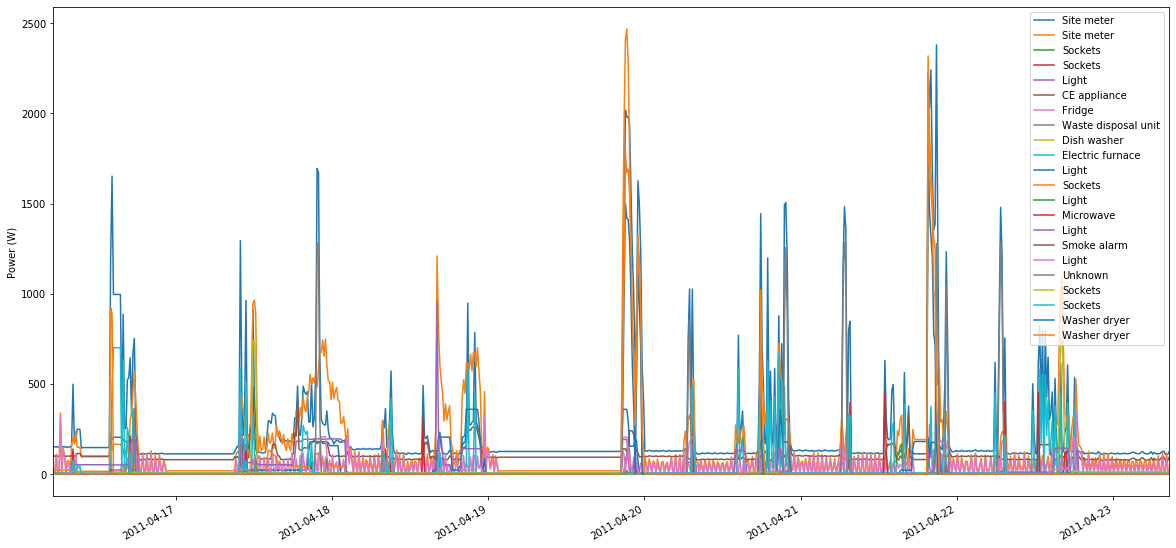

In [4]:
# Teste da classe
janelas = Janelas(
    base=redd,
    id_residencia=3,
    inicio_intervalo='2011-04-16 05:11:30',
    fim_intervalo='2011-04-23 08:43:26',
    debug = False
)


# Plots
fig = plt.figure(figsize=(20, 10))
print("Consumo geral dos medidores/aparelhos no período:")
for m in range(len(janelas.residencia.elec.meters)):
    janelas.residencia.elec.meters[m].plot();

In [5]:
# Extrair series divididas em janelas para cada medidor
# a cada 90 segundos, em uma taxa de 3s
dados_cargas = janelas.preparar(taxa_amostral=3, intervalo_medicao=90)

# Disposicao das janelas preparadas
pprint(dados_cargas)

Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
[{'carga': 'site_meter',
  'instancia': 1,
  'janelas': array([[144.82    , 146.66667 , 146.01    , ..., 162.76666 , 160.01666 ,
        153.06667 ],
       [152.77666 , 152.92667 , 153.16333 , ..., 152.35666 , 152.29001 ,
        152.03667 ],
       [152.01    , 152.95334 , 153.31    , ..., 152.32666 , 152.03    ,
        152.45999 ],
       ...,
       [107.815   , 107.939995, 107.86    , ..., 108.13    , 108.130005,
        108.19    ],
       [108.11    , 108.22    , 108.096664, ..., 122.235   , 122.27334 ,
        122.47667 ],
       [122.39667 , 122.57333 , 121.11    , ..., 123.916664, 123.66    ,
        135.86333 ]], dtype=float32),
  'rotulos': {'estado': array([1, 1, 1, ..., 1, 1, 1]),
              'media': array([147.

## Preparando Amostras (medidores residência ) e Rótulos (aparelhos)

In [6]:
# Listando as cargas que possuem janelas preparadas
janelas.lista_cargas(dados_cargas)

[(1, 'site_meter'),
 (2, 'site_meter'),
 (3, 'sockets'),
 (4, 'sockets'),
 (5, 'light'),
 (6, 'ce_appliance'),
 (7, 'fridge'),
 (8, 'waste_disposal_unit'),
 (9, 'dish_washer'),
 (10, 'electric_furnace'),
 (11, 'light'),
 (12, 'sockets'),
 (13, 'washer_dryer'),
 (14, 'washer_dryer'),
 (15, 'light'),
 (16, 'microwave'),
 (17, 'light'),
 (18, 'smoke_alarm'),
 (19, 'light'),
 (20, 'unknown')]

In [7]:
# Filtrando dados para conjunto de cargas
# NOTA: Os lares norte-americanos têm suprimentos de energia em fase dividida. 
#   Cada divisão é de 120 volts em relação ao neutro. As duas divisões 
#   totalizam 240 volts, por isso os dois 'site_meter'. 
#
#   Além disso, aparelhos que demandam energia (secadora, por exemplo) podem se 
#   conectar a ambas as divisões; na REDD se mede separadamente as duas divisões 
#   para esses tais aparelhos, contemplando no NILMTK dois medidores por 
#   dispositivo de 240 volts.

# Apenas duas fases da corrente eletrica da residencia
dados_medidores = janelas.filtrar_cargas(
    dados_cargas,
    filtros=[
        (1, 'site_meter'),
        (2, 'site_meter'),    
    ]
)
print("Dados das janelas de ambos medidores da residência:")
print("---")
pprint(dados_medidores)

print("\n\n")

# Apenas dados de aparelhos da residencia
dados_aparelhos = janelas.filtrar_cargas(
    dados_cargas,
    filtros=[
        (3, 'sockets'),
        (4, 'sockets'),
        (5, 'light'),
        (6, 'ce_appliance'),
        (7, 'fridge'),
        (8, 'waste_disposal_unit'),
        (9, 'dish_washer'),
        (10, 'electric_furnace'),
        (11, 'light'),
        (12, 'sockets'),
        (13, 'washer_dryer'),
        (14, 'washer_dryer'),
        (15, 'light'),
        (16, 'microwave'),
        (17, 'light'),
        (18, 'smoke_alarm'),
        (19, 'light'),
        (20, 'unknown')
    ]
)
print("Dados das janelas dos aparelhos da residência:")
print("---")
pprint(dados_aparelhos)

Dados das janelas de ambos medidores da residência:
---
[{'carga': 'site_meter',
  'instancia': 1,
  'janelas': array([[144.82    , 146.66667 , 146.01    , ..., 162.76666 , 160.01666 ,
        153.06667 ],
       [152.77666 , 152.92667 , 153.16333 , ..., 152.35666 , 152.29001 ,
        152.03667 ],
       [152.01    , 152.95334 , 153.31    , ..., 152.32666 , 152.03    ,
        152.45999 ],
       ...,
       [107.815   , 107.939995, 107.86    , ..., 108.13    , 108.130005,
        108.19    ],
       [108.11    , 108.22    , 108.096664, ..., 122.235   , 122.27334 ,
        122.47667 ],
       [122.39667 , 122.57333 , 121.11    , ..., 123.916664, 123.66    ,
        135.86333 ]], dtype=float32),
  'rotulos': {'estado': array([1, 1, 1, ..., 1, 1, 1]),
              'media': array([147.05612, 153.01077, 152.7641 , ..., 107.80511, 116.91384,
       122.40183], dtype=float32),
              'total': array([4411.6836, 4590.323 , 4582.923 , ..., 3234.1533, 3507.4153,
       3672.055 ], dtype

              'media': array([1.        , 1.        , 1.        , ..., 0.96666664, 0.96666664,
       1.        ], dtype=float32),
              'total': array([30., 30., 30., ..., 29., 29., 30.], dtype=float32)}},
 {'carga': 'unknown',
  'instancia': 20,
  'janelas': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  'rotulos': {'estado': array([0, 0, 0, ..., 0, 0, 0]),
              'media': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
              'total': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}}]


In [8]:

# Janelas do medidores agregados
X = dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"]

# Normalizando dados
# X = MinMaxScaler().fit_transform(X.T).T

print("* Dados dos medidores (Amostras / X):")
print("   - Shape:", X.shape)
print("   - Media:", np.mean(X))
print("   - Desvio:", np.std(X))

# Y = irá depender da carga a ser classificada

* Dados dos medidores (Amostras / X):
   - Shape: (6861, 30)
   - Media: 413.0859
   - Desvio: 673.9321


In [9]:
# Verificar apenas janelas válidaso: com medicao total MAIOR QUE ZERO 
# (ou seja, amostras que possuam ao menos uma carga ativa - janelas zeradas
# são INÚTEIS para aprendizado do modelo, além de contribuir para desbalanceamento)
idx_janelas_validas = np.where(np.sum(X, axis=1)>0)[0]
print("* Janelas com TODOS aparelhos desligados: {} (~{:.1f}% das amostras)".format(
    X.shape[0] - len(idx_janelas_validas), 
    ( 1 - (len(idx_janelas_validas)/X.shape[0]) )*100 
))
print()

# AMOSTRAS -> Filtrando apenas JANELAS validas
X = X[idx_janelas_validas]
print("* Amostras validadas (X shape):", X.shape)
print()

# APARELHOS -> Filtrando apenas JANELAS validas
print("* Rotulos (estado) validados:")
for i in range(len(dados_aparelhos)):
    
    dados_aparelhos[i]["janelas"] = dados_aparelhos[i]["janelas"][idx_janelas_validas]
    
    rotulos = copy.deepcopy(dados_aparelhos[i]["rotulos"])
    
    dados_aparelhos[i]["rotulos"]["estado"] = rotulos["estado"][idx_janelas_validas]
    dados_aparelhos[i]["rotulos"]["media"]  = rotulos["media"][idx_janelas_validas]
    dados_aparelhos[i]["rotulos"]["total"]  = rotulos["total"][idx_janelas_validas]
    print("   - `{}-{}`: {} -> {}".format(
        dados_aparelhos[i]["carga"].upper(), dados_aparelhos[i]["instancia"],
        Counter(rotulos["estado"]), 
        Counter(dados_aparelhos[i]["rotulos"]["estado"])
    ))

* Janelas com TODOS aparelhos desligados: 0 (~0.0% das amostras)

* Amostras validadas (X shape): (6861, 30)

* Rotulos (estado) validados:
   - `SOCKETS-3`: Counter({0: 4497, 1: 2364}) -> Counter({0: 4497, 1: 2364})
   - `SOCKETS-4`: Counter({0: 5858, 1: 1003}) -> Counter({0: 5858, 1: 1003})
   - `LIGHT-5`: Counter({0: 6092, 1: 769}) -> Counter({0: 6092, 1: 769})
   - `CE_APPLIANCE-6`: Counter({1: 6861}) -> Counter({1: 6861})
   - `FRIDGE-7`: Counter({1: 5844, 0: 1017}) -> Counter({1: 5844, 0: 1017})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 6138, 1: 723}) -> Counter({0: 6138, 1: 723})
   - `DISH_WASHER-9`: Counter({1: 6339, 0: 522}) -> Counter({1: 6339, 0: 522})
   - `ELECTRIC_FURNACE-10`: Counter({1: 6833, 0: 28}) -> Counter({1: 6833, 0: 28})
   - `LIGHT-11`: Counter({0: 5056, 1: 1805}) -> Counter({0: 5056, 1: 1805})
   - `SOCKETS-12`: Counter({0: 4866, 1: 1995}) -> Counter({0: 4866, 1: 1995})
   - `WASHER_DRYER-13`: Counter({0: 6613, 1: 248}) -> Counter({0: 6613, 1: 248})
   - `WAS

In [10]:
# TOP-5 aparelhos com maior consumo
top_aparelhos_consumo = []
for m in janelas.residencia.elec.submeters().select_top_k(5).meters:
    instancia = m.instance()
    carga = m.label().lower().replace(" ","_")
    if type(instancia)==tuple and len(instancia) > 1:
        for i in instancia:
            top_aparelhos_consumo.append((i, carga))
    else:
        top_aparelhos_consumo.append((instancia, carga))
        
print("\n")
print("------------------------------------------------------------------")
print("* Top-5 aparelhos com maior consumo total de energia no intervalo:")
print("------------------------------------------------------------------")
pprint(top_aparelhos_consumo)
print("----------------------------------------------")

19/19 MeterGroup(meters==22, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=5)])1)])1)])])
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=14, building=3, dataset='REDD') ...   

------------------------------------------------------------------
* Top-5 aparelhos com maior consumo total de energia no intervalo:
------------------------------------------------------------------
[(6, 'ce_appliance'),
 (13, 'washer_dryer'),
 (14, 'washer_dryer'),
 (7, 'fridge'),
 (10, 'electric_furnace'),
 (17, 'light')]
----------------------------------------------


**Distribuções dos estados (rótulos classificação):**

   - `CE_APPLIANCE-6`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {1: 5264}
   - `FRIDGE-7`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {1: 5125, 0: 139}
   - `ELECTRIC_FURNACE-10`: {1: 5236, 0: 28}
   - `WASHER_DRYER-13`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {0: 5018, 1: 246}
   - `WASHER_DRYER-14`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {0: 4945, 1: 319}
   - `LIGHT-17`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {0: 3134, 1: 2130})
   
   
<u>**CONCLUSÕES PARCIAIS:**</u>
1. É possível perceber que o aparelho `CE_APPLIANCE-6` é inviável de treinar nestas configurações, pois há apenas amostras positivas;
2. `LIGHT-17` é o aparelho com melhor equlibrio de amostras, ou seja, possui menor grau de desbalanceamento;
3. De resto, todos os aparelhos possuem grande desbalanceamento; `talvez seja necessário avaliar individualmente o tamanho da janela considerada para cada aparelho`.
    * Corrobora [Fagiani *et. al* (2019)](https://www.mdpi.com/1996-1073/12/7/1371), os quais afirmam que *"(...) geralmente, apesar da tarefa a ser resolvida dependendo da formulação do algoritmo, a precisão da desagregação diminui proporcionalmente com a variação da taxa de amostragem."*

Portanto, vamos considerar avaliar diferentes 'sample rate' em um pipeline de classificação (RP+CNN) comum neste estudo, considerando as cargas de maior consumo.

In [11]:
# Eletrônicos, Luzes, refrigerador, lava loucas, aquecedor, secadora de
# roupas, alarmes de incêndio, equipamentos de banheiro, utensílios de
# cozinha, Micro-ondas, utensílios externos.

In [12]:
# # TOP-5 aparelhos com maior DEMANDA de energia
# df_energia = janelas.residencia.elec.dataframe_of_meters()

# fig = plt.figure(figsize=(20,8))
# cargas = janelas.residencia.elec.get_labels(df_energia.columns)[2:]
# legenda = []
# dados_energia = [] # Lista com estatisticas por caga
# for i, coluna in enumerate(df_energia.columns[2:]):
#     instancia = ""
#     if hasattr(coluna, "instance"):
#         instancia = coluna.instance
#     else:
#         instancia = tuple([m.instance for m in coluna.meters])

#     serie = np.nan_to_num(df_energia[coluna].values)
#     dados_energia.append({
#         "carga": cargas[i],
#         "instancia": instancia,
#         "total": np.sum(serie),
#         "maximo": np.max(serie),
#         "minimo": np.min(serie),
#         "media": np.mean(serie),
#         "desvio": np.std(serie)
#     })
#     legenda.append(f"{cargas[i]}-{str(instancia)}")
#     plt.plot(np.arange(df_energia.shape[0]), serie)
# plt.legend(legenda);
# plt.title("Consumo por Dispositivo dentro do Intervalo")
# plt.show();

# sorted(dados_energia, key=lambda k: k['maximo'], reverse=False) 

## Transformar Séries (Janelas) em Imagens

In [397]:

# fig, axes = plt.subplots(1,4, figsize=(20,5))

# axes[0].plot(np.arange(len(X[3])), X[3])
# axes[0].set_title("Série Original (Janela)")
# # axes[0].grid(False)

# # RPs
# X_rp = RecurrencePlot().fit_transform(X)
# axes[1].imshow(X_rp[3], cmap="plasma");
# axes[1].set_title("RP")
# axes[1].grid(False)

# # GASF
# X_gasf = GramianAngularField(method="summation").fit_transform(X)
# axes[2].imshow(X_gasf[3], cmap="plasma");
# axes[2].set_title("GASF")
# axes[2].grid(False)

# # GASF
# X_gadf = GramianAngularField(method="difference").fit_transform(X)
# axes[3].imshow(X_gadf[3], cmap="plasma");
# axes[3].set_title("GADF")
# axes[3].grid(False)

# # # MTF
# # X_mtf = MarkovTransitionField().fit_transform(X[np.where(np.sum(X, axis=1)>0)[0]])
# # plt.imshow(X_mtf[3], cmap="plasma");
# # plt.title("MTF")
# # plt.grid(False)
# # plt.show()
# plt.show()

# # Gerando imagens RGB N canais
# X_imagem = np.stack([X_rp, X_gasf, X_gadf], axis=-1)
# print("* Shape da matriz de amostras:", X_imagem.shape)

# Modelagem

In [4]:
# from PyNILM.dados.janelas import Janelas

from PyNILM.avaliacao.metricas import *
from PyNILM.avaliacao.graficos import *
from PyNILM.avaliacao.analises import *

from sklearn.model_selection import train_test_split

from pyts.image import RecurrencePlot

import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPool1D
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import backend as K
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


from pyts.image import RecurrencePlot, GramianAngularField

# Garantindo reprodutibilidade
import random as rn
# Constantes dos experimentos
SEED = 33
FRACAO_TESTE = 0.25
EPOCAS = 100
TAMANHO_LOTE = 32
VERBOSIDADE = 0
PARAMETROS_RP = {
    "dimension": 1,
    "time_delay": 1,
    "threshold": None,
    "percentage": 10
}
# PARAMETROS_RP={
#     "dimension": 3,
#     "time_delay": 8,
#     "threshold": 0.1
# }
# Travar Seed's
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
np.random.seed(SEED)
rn.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
tf.random.set_seed(SEED)

# Habilitando/limitando utilização de GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*5)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("# GPUs habilitadas:", "{} física(s)".format(len(gpus)), "/", "{} lógica(s)".format(len(gpus)))
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
        
def convnet(
    input_shape_ = (30, 30, 1), 
    output_dim=6, 
    loss_function = 'binary_crossentropy', 
    metrics=['accuracy'],
    output_activation = 'softmax'
):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape_))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(output_dim, activation=output_activation))

    model.compile(optimizer='adam', loss=[loss_function], metrics=metrics)
    
    return model

# GPUs habilitadas: 1 física(s) / 1 lógica(s)


In [5]:
# NOTA IMPORTANTE: Este notebook já foi executado, e os resultados persistidos
#  no arquivo `17-resultados_taxa-amostragem_janelas`.
#  O notebook ORIGINAL (com os outputs desta célula) foi corrompido, devido
#  ao tamanho resultante (>70MB).

if not os.path.isfile(os.path.join(caminho_dados_notebook, 'resultados_taxa-amostragem_janelas.csv')):
    # Cenarios de avaliacao:
    # ---
    resultados = {
        "carga": [],
        "taxa_amostragem": [],
        "janela": [],
        "loss": [],
        "acuracia": [],
        "precisao": [],
        "recall": [],
        "f1": [],
        "f1_macro": []
    }

    # Intervalo de tempo e residencia considerados na base REDD
    janelas = Janelas(
        base=redd,
        id_residencia=3,
        inicio_intervalo='2011-04-16 05:11:30',
        fim_intervalo='2011-04-23 08:43:26',
        debug = False
    )

    # Testar diferentes taxas de amostragem
    taxas_amostragem = [1, 2, 3, 5, 8]
    for taxa in taxas_amostragem:
        for janela in [30, 60, 90, 180, 360, 540, 720, 900, 1080]: # nao foi possivel devido ao limite modelo/GPU

            print()
            print("-="*10, f"AMOSTRAGEM `{taxa}s` / JANELA `{janela}`", "=-"*10)
            print()

            # Extrair series divididas em janelas para cada medidor
            print("* Preparando dados das janelas para a taxa de amostragem...")
            # TODO: corrigir output com counter duplicados
            dados_cargas = janelas.preparar(
                taxa_amostral = taxa, 
                intervalo_medicao= janela 
            )
            print()

            # Apenas duas fases da corrente eletrica da residencia
            print("* Dividindo cargas entre medidores (mains) e aparelhos...")
            dados_medidores = janelas.filtrar_cargas(
                dados_cargas,
                filtros=[
                    (1, 'site_meter'),
                    (2, 'site_meter'),    
                ]
            )
            # Apenas dados de aparelhos da residencia
            dados_aparelhos = janelas.filtrar_cargas(
                dados_cargas,
                filtros=[
                    (3, 'sockets'),
                    (4, 'sockets'),
                    (5, 'light'),
                    (6, 'ce_appliance'),
                    (7, 'fridge'),
                    (8, 'waste_disposal_unit'),
                    (9, 'dish_washer'),
                    (10, 'electric_furnace'),
                    (11, 'light'),
                    (12, 'sockets'),
                    (13, 'washer_dryer'),
                    (14, 'washer_dryer'),
                    (15, 'light'),
                    (16, 'microwave'),
                    (17, 'light'),
                    (18, 'smoke_alarm'),
                    (19, 'light'),
                    (20, 'unknown')
                ]
            )

            # <<< Limpando memoria >>>
            dados_cargas = None
            del dados_cargas
            gc.collect()
            # <<< Limpando memoria >>>

            print()

            # Gerar matriz de amostras do modelo (X) e preparar rotulos Y (estado das cargas)
            print("* Preparando amostras e rótulos...")

            # Validar tamanho dos dados de medidores (podem ter mais registros que os aparelhos)
            janela_media_medidores = int(np.sum([len(d["janelas"])for d in dados_medidores])/len(dados_medidores))
            janela_media_aparelhos = int(np.sum([len(d["janelas"])for d in dados_aparelhos])/len(dados_aparelhos))

            # Ajustando para medidores terem o mesmo shape de janelas dos aparelhos 
            if janela_media_medidores > janela_media_aparelhos:
                diferenca = janela_media_medidores-janela_media_aparelhos
                print("  -> Diferenca encontrada entre medidores/aparelhos:", diferenca, ", ajustando..")
                for i in range(len(dados_medidores)):
                    removidos = 0
                    while removidos < diferenca:
                        # Remover ultima janela
                        dados_medidores[i]["janelas"] = dados_medidores[i]["janelas"][:-1,:]
                        removidos += 1


            X = dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"]

            # <<< Limpando memoria >>>
            dados_medidores = None
            del dados_medidores
            gc.collect()
            # <<< Limpando memoria >>>

            # Normalizacao dos dados (DESUSO)
            #X = MinMaxScaler().fit_transform(X.T).T # Normalizando dados

            # Selecionando apenas janelas VALIDAS (ocorrencia de ao menos 1 carga)
            # TODO: Implementar na biblioteca esta rotina de validacao
            idx_janelas_validas = np.where(np.sum(X, axis=1)>0)[0]
            X = X[idx_janelas_validas]
            for i in range(len(dados_aparelhos)):
                dados_aparelhos[i]["janelas"] = dados_aparelhos[i]["janelas"][idx_janelas_validas]
                rotulos = copy.deepcopy(dados_aparelhos[i]["rotulos"])
                dados_aparelhos[i]["rotulos"]["estado"] = rotulos["estado"][idx_janelas_validas]
                dados_aparelhos[i]["rotulos"]["media"]  = rotulos["media"][idx_janelas_validas]
                dados_aparelhos[i]["rotulos"]["total"]  = rotulos["total"][idx_janelas_validas]
                print("   - `{}-{}`: {} -> {}".format(
                    dados_aparelhos[i]["carga"].upper(), dados_aparelhos[i]["instancia"],
                    Counter(rotulos["estado"]), 
                    Counter(dados_aparelhos[i]["rotulos"]["estado"])
                ))
            print()

            print("* Transformando séries (amostras) em imagens...")
            # Transformacao das series em RPs...
            X_rp = RecurrencePlot().set_params(**PARAMETROS_RP).fit_transform(X)


            # <<< Limpando memoria >>>
            X = None
            del X
            gc.collect()
            # <<< Limpando memoria >>>

            # Projetando RPs em canais...
            X_imagem = np.stack([X_rp], axis=-1).astype(np.float16) # 1 canal

            # <<< Limpando memoria >>>
            X_rp = None
            del X_rp
            gc.collect()
            # <<< Limpando memoria >>>

            print("  -> Shape da matriz de amostras:", X_imagem.shape)
            print()

            # Loop sobre TODOS os aparelhos (binarios, parametros similares estudo ja feito)
            print("* Avaliando modelos binários para cada um dos aparelhos, aguarde...")
            print()
            for aparelho in dados_aparelhos:
                caminho_persistencia_resultados = os.path.join(
                    caminho_imagens_notebook, 
                    'taxa-{}_janela-{}_{}'.format(
                        taxa, janela, f'{aparelho["carga"]}-{aparelho["instancia"]}' 
                    )
                )
                if not os.path.isdir(caminho_persistencia_resultados):
                    try:
                        print("-"*50)
                        print()

                        y = aparelho["rotulos"]["estado"]

                        print(f"_ Dados do aparelho `{aparelho['carga'].upper()} - {aparelho['instancia']}` (Y / rótulo:)")
                        print("   - ", Counter(y))
                        print()

                        # Split de treino / teste
                        print("_ Treinando o modelo classificador de estados...")

                        estratificacao = y
                        # Ver se é inviavel estratificacao
                        for v in Counter(y).values():
                            if v == 1:
                                estratificacao = None
                                break
                        X_treino, X_teste, y_treino, y_teste = train_test_split(
                            X_imagem, y,
                            test_size=FRACAO_TESTE,
                            stratify=estratificacao,
                            random_state=SEED
                        )

                        # Treinando modelo
                        modelo = convnet(
                            input_shape_= X_imagem[0,:,:].shape,
                            output_dim = 1,
                            loss_function='binary_crossentropy',
                            metrics=['accuracy'],
                            output_activation='sigmoid'
                        )

                        historico = modelo.fit(
                            X_treino, y_treino,
                            validation_data=(X_teste, y_teste),
                            epochs=EPOCAS,
                            batch_size=TAMANHO_LOTE,
                            verbose=VERBOSIDADE
                        )

                        print()

                        # Resultados do modelo
                        r = modelo.evaluate(X_teste, y_teste)
                              
                        # TODO: implementar opção de apenas salvar imagens na pasta
                        #   do notebook ao inves de exibi-las no IPython notebook
                        #   padrao -> os.path.join(CAMINHO_IMAGENS_NOTEBOOK, 'taxa-{}.janela-{}_convergencia-loss.png'.format(taxa, janela))
                        # ---                 
                        # Avaliando modelo
                        relatorio_classificacao_aparelho(
                            modelo, X_teste, y_teste, 
                            f'{aparelho["carga"]} - {aparelho["instancia"]}',
                            caminho_persistencia=caminho_persistencia_resultados
                        )
                                                   
                        # Considerando resultados adicionais da analise
                        df_resultados = pd.read_csv(
                            os.path.join(
                                caminho_persistencia_resultados,
                                "resultados_analise.csv"
                            )
                        )
                              
                        # Incluindo dados no dataframe
                        resultados["carga"].append(f'{aparelho["carga"]} - {aparelho["instancia"]}')
                        resultados["taxa_amostragem"].append(taxa)
                        resultados["janela"].append(janela)
                        resultados["loss"].append(r[0])
                        resultados["acuracia"].append(r[1])
                        resultados["precisao"].append(df_resultados["Precisão"].values[0])
                        resultados["recall"].append(df_resultados["Recall"].values[0])
                        resultados["f1"].append(df_resultados["F1-score"].values[0])
                        resultados["f1_macro"].append(df_resultados["F1-macro"].values[0])
                                                   
                        # Persistindo o log individual do modelo (backup)
                        if not os.path.isdir(os.path.join(caminho_persistencia_resultados)):
                            os.makedirs(caminho_persistencia_resultados)
                        with open(os.path.join(caminho_persistencia_resultados, "resultados_modelo.log"), "w") as log:
                            log.write(
                                "{},{},{},{},{}".format(
                                    f'{aparelho["carga"]} - {aparelho["instancia"]}',
                                    taxa,
                                    janela,
                                    r[0],
                                    r[1]
                                )
                            )
                              
                        print()

                    except Exception as e:
                        print(f" !# Não foi possível treinar o modelo para a combinação de taxa `{str(taxa)}` / janela `{str(janela)}`: {str(e)}")
                else:
                    print(f" !# Modelo já treinado para a combinação de carga `{aparelho['carga']}-{aparelho['instancia']}` / taxa `{str(taxa)}` / janela `{str(janela)}`")
                    print()
                          
                    # Considerando resultados adicionais da analise
                    df_resultados = pd.read_csv(
                        os.path.join(
                            caminho_persistencia_resultados,
                            "resultados_analise.csv"
                        ),
                    )
                                               
                    # Lendo resultados dos logs
                    with open(os.path.join(caminho_persistencia_resultados, "resultados_modelo.log"), "r") as log:
                        dados = log.readlines()[0].split(',')
                        resultados["carga"].append(dados[0])
                        resultados["taxa_amostragem"].append(int(dados[1]))
                        resultados["janela"].append(int(dados[2]))
                        resultados["loss"].append(float(dados[3]))
                        resultados["acuracia"].append(round(float(dados[4]),7))
                        resultados["precisao"].append(df_resultados["Precisão"].values[0])
                        resultados["recall"].append(df_resultados["Recall"].values[0])
                        resultados["f1"].append(df_resultados["F1-score"].values[0])
                        resultados["f1_macro"].append(df_resultados["F1-macro"].values[0])

            # <<< Limpando memoria >>>
            X_imagem = None
            del X_imagem
            dados_aparelhos = None
            del dados_aparelhos
            gc.collect()
            # <<< Limpando memoria >>>

            print()

    # Exportar resultados
    df_resultados = pd.DataFrame(resultados)
    df_resultados.to_csv(os.path.join(caminho_dados_notebook, "resultados_taxa-amostragem_janelas.csv"))
                              
else:
    print("####################################")
    print(f"#          A T E N Ç Ã O           #")
    print("####################################")
    print("\nExecução já realizada anteriormente.")
    print(f"\nOs resultados estão disponíveis no arquivo \n`{os.path.join(caminho_dados_notebook,'resultados_taxa-amostragem_janelas.csv')}`")
    print("\n####################################")


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `1s` / JANELA `30` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 20381, 1: 202}) -> Counter({0: 20381, 1: 202})
   - `SOCKETS-4`: Counter({0: 20583}) -> Counter({0: 20583})
   - `LIGHT-5`: Counter({0: 20545, 1: 38}) -> Counter({0: 20545, 1: 38})
   - `CE_APPLIANCE-6`: Counter({1: 20583}) -> Counter({1: 20583})
   - `FRIDGE-7`: Counter({0: 14723, 1: 5860}) -> Counter({0: 14723, 1: 5860})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 20569, 1: 14}) -> Counter({0: 20569, 1: 14})
   - `DISH_WASHER-9`: Counter({0: 20343, 1: 240}) -> Counter({0: 20343, 1: 240})
   - `ELECTRIC_FURNACE-10`: Counter({0: 19655, 1: 928}) -> Counter({0: 19655, 1: 928})
   - `LIGHT-11`: Counter(

,Sockets - 3
Acurácia,99.44
Precisão,72.92
Recall,68.63
F1-score,70.71
F1-macro,85.21
Hamming Loss,0.01
AUC,0.84
Suporte (y=0),5095.00
Suporte (y=1),51.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 20583})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 2.5561e-14 - accuracy: 1.00 - ETA: 0s - loss: 3.1561e-14 - accuracy: 1.00 - ETA: 0s - loss: 3.6957e-14 - accuracy: 1.00 - ETA: 0s - loss: 3.5661e-14 - accuracy: 1.00 - ETA: 0s - loss: 3.5369e-14 - accuracy: 1.00 - ETA: 0s - loss: 3.4988e-14 - accuracy: 1.00 - ETA: 0s - loss: 3.5560e-14 - accuracy: 1.00 - ETA: 0s - loss: 3.5509e-14 - accuracy: 1.00 - 0s 74us/sample - loss: 3.5539e-14 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),5146.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 20545, 1: 38})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 1.00 - ETA: 0s - loss: 0.0090 - accuracy: 0.99 - ETA: 0s - loss: 0.0084 - accuracy: 0.99 - ETA: 0s - loss: 0.0081 - accuracy: 0.99 - ETA: 0s - loss: 0.0137 - accuracy: 0.99 - ETA: 0s - loss: 0.0146 - accuracy: 0.99 - ETA: 0s - loss: 0.0135 - accuracy: 0.99 - ETA: 0s - loss: 0.0134 - accuracy: 0.99 - ETA: 0s - loss: 0.0129 - accuracy: 0.99 - 0s 83us/sample - loss: 0.0127 - accuracy: 0.9981
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.81
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.95
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),5136.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 20583})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 1.7429e-13 - accuracy: 1.00 - ETA: 0s - loss: 2.0671e-13 - accuracy: 1.00 - ETA: 0s - loss: 2.0595e-13 - accuracy: 1.00 - ETA: 0s - loss: 2.1240e-13 - accuracy: 1.00 - ETA: 0s - loss: 2.1306e-13 - accuracy: 1.00 - ETA: 0s - loss: 2.1726e-13 - accuracy: 1.00 - ETA: 0s - loss: 2.2045e-13 - accuracy: 1.00 - ETA: 0s - loss: 2.2494e-13 - accuracy: 1.00 - ETA: 0s - loss: 2.2690e-13 - accuracy: 1.00 - 0s 86us/sample - loss: 2.2704e-13 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),5146.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 14723, 1: 5860})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.3325 - accuracy: 0.84 - ETA: 0s - loss: 0.4973 - accuracy: 0.71 - ETA: 0s - loss: 0.4644 - accuracy: 0.73 - ETA: 0s - loss: 0.4776 - accuracy: 0.73 - ETA: 0s - loss: 0.4816 - accuracy: 0.73 - ETA: 0s - loss: 0.4822 - accuracy: 0.73 - ETA: 0s - loss: 0.4917 - accuracy: 0.73 - ETA: 0s - loss: 0.4863 - accuracy: 0.73 - 0s 80us/sample - loss: 0.4865 - accuracy: 0.7380
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,73.80
Precisão,58.14
Recall,28.53
F1-score,38.28
F1-macro,60.83
Hamming Loss,0.26
AUC,0.60
Suporte (y=0),3681.00
Suporte (y=1),1465.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 20569, 1: 14})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 6.3304e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0180 - accuracy: 0.9969   - ETA: 0s - loss: 0.0094 - accuracy: 0.99 - ETA: 0s - loss: 0.0064 - accuracy: 0.99 - ETA: 0s - loss: 0.0085 - accuracy: 0.99 - ETA: 0s - loss: 0.0070 - accuracy: 0.99 - ETA: 0s - loss: 0.0062 - accuracy: 0.99 - ETA: 0s - loss: 0.0054 - accuracy: 0.99 - ETA: 0s - loss: 0.0050 - accuracy: 0.99 - ETA: 0s - loss: 0.0047 - accuracy: 0.99 - ETA: 0s - loss: 0.0055 - accuracy: 0.99 - 1s 104us/sample - loss: 0.0054 - accuracy: 0.9992
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.92
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.98
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),5142.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 20343, 1: 240})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 1.00 - ETA: 0s - loss: 0.0828 - accuracy: 0.98 - ETA: 0s - loss: 0.0758 - accuracy: 0.98 - ETA: 0s - loss: 0.0766 - accuracy: 0.98 - ETA: 0s - loss: 0.0708 - accuracy: 0.98 - ETA: 0s - loss: 0.1028 - accuracy: 0.98 - ETA: 0s - loss: 0.0917 - accuracy: 0.98 - ETA: 0s - loss: 0.0876 - accuracy: 0.98 - ETA: 0s - loss: 0.0844 - accuracy: 0.98 - ETA: 0s - loss: 0.0807 - accuracy: 0.98 - 1s 99us/sample - loss: 0.0771 - accuracy: 0.9883
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.83
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.71
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),5086.00
Suporte (y=1),60.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 19655, 1: 928})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.96 - ETA: 0s - loss: 0.1521 - accuracy: 0.95 - ETA: 0s - loss: 0.1436 - accuracy: 0.95 - ETA: 0s - loss: 0.1426 - accuracy: 0.95 - ETA: 0s - loss: 0.1558 - accuracy: 0.94 - ETA: 0s - loss: 0.1552 - accuracy: 0.94 - ETA: 0s - loss: 0.1484 - accuracy: 0.95 - ETA: 0s - loss: 0.1485 - accuracy: 0.95 - 0s 81us/sample - loss: 0.1447 - accuracy: 0.9516
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,95.16
Precisão,25.71
Recall,3.88
F1-score,6.74
F1-macro,52.13
Hamming Loss,0.05
AUC,0.52
Suporte (y=0),4914.00
Suporte (y=1),232.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 16027, 1: 4556})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.87 - ETA: 0s - loss: 0.4397 - accuracy: 0.82 - ETA: 0s - loss: 0.4304 - accuracy: 0.82 - ETA: 0s - loss: 0.4017 - accuracy: 0.83 - ETA: 0s - loss: 0.3859 - accuracy: 0.84 - ETA: 0s - loss: 0.3924 - accuracy: 0.84 - ETA: 0s - loss: 0.3868 - accuracy: 0.84 - ETA: 0s - loss: 0.3830 - accuracy: 0.84 - 0s 79us/sample - loss: 0.3840 - accuracy: 0.8449
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,84.49
Precisão,66.63
Recall,59.96
F1-score,63.12
F1-macro,76.65
Hamming Loss,0.16
AUC,0.76
Suporte (y=0),4007.00
Suporte (y=1),1139.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 17129, 1: 3454})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.3085 - accuracy: 0.84 - ETA: 0s - loss: 0.2824 - accuracy: 0.88 - ETA: 0s - loss: 0.2538 - accuracy: 0.89 - ETA: 0s - loss: 0.2650 - accuracy: 0.89 - ETA: 0s - loss: 0.2583 - accuracy: 0.89 - ETA: 0s - loss: 0.2602 - accuracy: 0.89 - ETA: 0s - loss: 0.2699 - accuracy: 0.88 - ETA: 0s - loss: 0.2704 - accuracy: 0.89 - 0s 80us/sample - loss: 0.2660 - accuracy: 0.8923
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,89.23
Precisão,74.14
Recall,55.09
F1-score,63.21
F1-macro,78.45
Hamming Loss,0.11
AUC,0.76
Suporte (y=0),4282.00
Suporte (y=1),864.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 20289, 1: 294})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 1.00 - ETA: 0s - loss: 0.0249 - accuracy: 0.99 - ETA: 0s - loss: 0.0275 - accuracy: 0.99 - ETA: 0s - loss: 0.0247 - accuracy: 0.98 - ETA: 0s - loss: 0.0198 - accuracy: 0.99 - ETA: 0s - loss: 0.0204 - accuracy: 0.99 - ETA: 0s - loss: 0.0202 - accuracy: 0.99 - ETA: 0s - loss: 0.0215 - accuracy: 0.99 - ETA: 0s - loss: 0.0228 - accuracy: 0.99 - 0s 85us/sample - loss: 0.0220 - accuracy: 0.9913
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.13
Precisão,75.44
Recall,58.11
F1-score,65.65
F1-macro,82.60
Hamming Loss,0.01
AUC,0.79
Suporte (y=0),5072.00
Suporte (y=1),74.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 19965, 1: 618})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.1600 - accuracy: 0.93 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - ETA: 0s - loss: 0.1164 - accuracy: 0.96 - ETA: 0s - loss: 0.1093 - accuracy: 0.96 - ETA: 0s - loss: 0.1053 - accuracy: 0.96 - ETA: 0s - loss: 0.1055 - accuracy: 0.96 - ETA: 0s - loss: 0.0979 - accuracy: 0.97 - ETA: 0s - loss: 0.0933 - accuracy: 0.97 - ETA: 0s - loss: 0.0964 - accuracy: 0.97 - 0s 88us/sample - loss: 0.0947 - accuracy: 0.9718
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.18
Precisão,54.63
Recall,38.06
F1-score,44.87
F1-macro,71.71
Hamming Loss,0.03
AUC,0.69
Suporte (y=0),4991.00
Suporte (y=1),155.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 20581, 1: 2})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 3.5939e-16 - accuracy: 1.00 - ETA: 0s - loss: 47.9223 - accuracy: 0.9985   - ETA: 0s - loss: 23.4039 - accuracy: 0.999 - ETA: 0s - loss: 16.2318 - accuracy: 0.999 - ETA: 0s - loss: 12.4243 - accuracy: 0.999 - ETA: 0s - loss: 10.1653 - accuracy: 0.999 - ETA: 0s - loss: 8.4569 - accuracy: 0.999 - ETA: 0s - loss: 7.1884 - accuracy: 0.99 - 0s 81us/sample - loss: 6.2580 - accuracy: 0.9998
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.98
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,50.00
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),5145.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 20440, 1: 143})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 1.00 - ETA: 0s - loss: 0.0509 - accuracy: 0.99 - ETA: 0s - loss: 0.0487 - accuracy: 0.99 - ETA: 0s - loss: 0.0598 - accuracy: 0.99 - ETA: 0s - loss: 0.0507 - accuracy: 0.99 - ETA: 0s - loss: 0.0464 - accuracy: 0.99 - ETA: 0s - loss: 0.0421 - accuracy: 0.99 - ETA: 0s - loss: 0.0412 - accuracy: 0.99 - ETA: 0s - loss: 0.0387 - accuracy: 0.99 - 0s 82us/sample - loss: 0.0384 - accuracy: 0.9926
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,99.26
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.81
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),5110.00
Suporte (y=1),36.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 14742, 1: 5841})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.3769 - accuracy: 0.84 - ETA: 0s - loss: 0.4322 - accuracy: 0.81 - ETA: 0s - loss: 0.4314 - accuracy: 0.81 - ETA: 0s - loss: 0.4223 - accuracy: 0.81 - ETA: 0s - loss: 0.4215 - accuracy: 0.82 - ETA: 0s - loss: 0.4171 - accuracy: 0.82 - ETA: 0s - loss: 0.4255 - accuracy: 0.82 - ETA: 0s - loss: 0.4188 - accuracy: 0.82 - ETA: 0s - loss: 0.4178 - accuracy: 0.82 - 0s 83us/sample - loss: 0.4174 - accuracy: 0.8247
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,82.47
Precisão,72.14
Recall,62.26
F1-score,66.84
F1-macro,77.46
Hamming Loss,0.18
AUC,0.76
Suporte (y=0),3686.00
Suporte (y=1),1460.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 20579, 1: 4})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 1.7597e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0117 - accuracy: 0.9984   - ETA: 0s - loss: 0.0061 - accuracy: 0.99 - ETA: 0s - loss: 0.0041 - accuracy: 0.99 - ETA: 0s - loss: 0.0032 - accuracy: 0.99 - ETA: 0s - loss: 0.0026 - accuracy: 0.99 - ETA: 0s - loss: 0.0022 - accuracy: 0.99 - ETA: 0s - loss: 0.0019 - accuracy: 0.99 - ETA: 0s - loss: 0.0016 - accuracy: 0.99 - 0s 82us/sample - loss: 0.0016 - accuracy: 0.9998
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.98
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,50.00
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),5145.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 16509, 1: 4074})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.3311 - accuracy: 0.84 - ETA: 0s - loss: 0.3730 - accuracy: 0.82 - ETA: 0s - loss: 0.3609 - accuracy: 0.83 - ETA: 0s - loss: 0.3604 - accuracy: 0.84 - ETA: 0s - loss: 0.3537 - accuracy: 0.84 - ETA: 0s - loss: 0.3631 - accuracy: 0.84 - ETA: 0s - loss: 0.3609 - accuracy: 0.84 - ETA: 0s - loss: 0.3582 - accuracy: 0.84 - ETA: 0s - loss: 0.3561 - accuracy: 0.84 - 0s 83us/sample - loss: 0.3584 - accuracy: 0.8438
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,84.38
Precisão,59.82
Recall,64.28
F1-score,61.97
F1-macro,76.07
Hamming Loss,0.16
AUC,0.77
Suporte (y=0),4127.00
Suporte (y=1),1019.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 19822, 1: 761})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.93 - ETA: 0s - loss: 0.1321 - accuracy: 0.95 - ETA: 0s - loss: 0.1560 - accuracy: 0.95 - ETA: 0s - loss: 0.1602 - accuracy: 0.95 - ETA: 0s - loss: 0.1531 - accuracy: 0.95 - ETA: 0s - loss: 0.1443 - accuracy: 0.95 - ETA: 0s - loss: 0.1406 - accuracy: 0.95 - ETA: 0s - loss: 0.1362 - accuracy: 0.96 - ETA: 0s - loss: 0.1329 - accuracy: 0.96 - 0s 83us/sample - loss: 0.1324 - accuracy: 0.9619
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,96.19
Precisão,12.50
Recall,0.53
F1-score,1.01
F1-macro,49.53
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),4956.00
Suporte (y=1),190.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `1s` / JANELA `60` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 10189, 1: 102}) -> Counter({0: 10189, 1: 102})
   - `SOCKETS-4`: Counter({0: 10291}) -> Counter({0: 10291})
   - `LIGHT-5`: Counter({0: 10271, 1: 20}) -> Counter({0: 10271, 1: 20})
   - `CE_APPLIANCE-6`: Counter({1: 10291}) -> Counter({1: 10291})
   - `FRIDGE-7`: Counter({0: 7228, 1: 3063}) -> Counter({0: 7228, 1: 3063})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 10279, 1: 12}) -> Counter({0: 10279, 1: 12})
   - `DISH_WASHER-9`: Counter({0: 10164, 1: 127}) -> Counter({0: 10164, 1: 127})
   - `

,Sockets - 3
Acurácia,99.38
Precisão,75.00
Recall,57.69
F1-score,65.22
F1-macro,82.45
Hamming Loss,0.01
AUC,0.79
Suporte (y=0),2547.00
Suporte (y=1),26.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 10291})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 2.1880e-12 - accuracy: 1.00 - ETA: 0s - loss: 3.8289e-12 - accuracy: 1.00 - ETA: 0s - loss: 3.9083e-12 - accuracy: 1.00 - ETA: 0s - loss: 3.9206e-12 - accuracy: 1.00 - ETA: 0s - loss: 4.0516e-12 - accuracy: 1.00 - ETA: 0s - loss: 4.0397e-12 - accuracy: 1.00 - 0s 120us/sample - loss: 4.0501e-12 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),2573.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 10271, 1: 20})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 1.9035e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0453 - accuracy: 0.9955   - ETA: 0s - loss: 0.0295 - accuracy: 0.99 - ETA: 0s - loss: 0.0202 - accuracy: 0.99 - ETA: 0s - loss: 0.0257 - accuracy: 0.99 - ETA: 0s - loss: 0.0210 - accuracy: 0.99 - 0s 123us/sample - loss: 0.0190 - accuracy: 0.9969
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.69
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.92
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),2568.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 10291})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 5.4647e-12 - accuracy: 1.00 - ETA: 0s - loss: 9.5633e-12 - accuracy: 1.00 - ETA: 0s - loss: 9.8200e-12 - accuracy: 1.00 - ETA: 0s - loss: 9.7366e-12 - accuracy: 1.00 - ETA: 0s - loss: 1.0158e-11 - accuracy: 1.00 - ETA: 0s - loss: 1.0062e-11 - accuracy: 1.00 - ETA: 0s - loss: 1.0129e-11 - accuracy: 1.00 - 0s 126us/sample - loss: 1.0112e-11 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),2573.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 7228, 1: 3063})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.4280 - accuracy: 0.81 - ETA: 0s - loss: 0.5019 - accuracy: 0.73 - ETA: 0s - loss: 0.5185 - accuracy: 0.72 - ETA: 0s - loss: 0.5193 - accuracy: 0.72 - ETA: 0s - loss: 0.5046 - accuracy: 0.73 - ETA: 0s - loss: 0.5100 - accuracy: 0.73 - 0s 120us/sample - loss: 0.5084 - accuracy: 0.7330
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,73.30
Precisão,53.56
Recall,77.68
F1-score,63.40
F1-macro,71.19
Hamming Loss,0.27
AUC,0.75
Suporte (y=0),1807.00
Suporte (y=1),766.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 10279, 1: 12})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 5.1748e-04 - accuracy: 1.00 - ETA: 0s - loss: 8.7510e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0295 - accuracy: 0.9989   - ETA: 0s - loss: 0.0247 - accuracy: 0.99 - ETA: 0s - loss: 0.0240 - accuracy: 0.99 - ETA: 0s - loss: 0.0196 - accuracy: 0.99 - 0s 122us/sample - loss: 0.0169 - accuracy: 0.9988
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.88
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.97
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),2570.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 10164, 1: 127})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 1.00 - ETA: 0s - loss: 0.0763 - accuracy: 0.98 - ETA: 0s - loss: 0.0858 - accuracy: 0.98 - ETA: 0s - loss: 0.0797 - accuracy: 0.98 - ETA: 0s - loss: 0.0766 - accuracy: 0.98 - ETA: 0s - loss: 0.0823 - accuracy: 0.98 - ETA: 0s - loss: 0.0837 - accuracy: 0.98 - 0s 131us/sample - loss: 0.0841 - accuracy: 0.9872
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.72
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.68
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),2541.00
Suporte (y=1),32.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 9808, 1: 483})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.96 - ETA: 0s - loss: 0.2087 - accuracy: 0.95 - ETA: 0s - loss: 0.1988 - accuracy: 0.95 - ETA: 0s - loss: 0.1834 - accuracy: 0.95 - ETA: 0s - loss: 0.1855 - accuracy: 0.94 - ETA: 0s - loss: 0.1731 - accuracy: 0.95 - 0s 120us/sample - loss: 0.1928 - accuracy: 0.9518
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,95.18
Precisão,45.16
Recall,11.57
F1-score,18.42
F1-macro,57.97
Hamming Loss,0.05
AUC,0.55
Suporte (y=0),2452.00
Suporte (y=1),121.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 8004, 1: 2287})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.3659 - accuracy: 0.84 - ETA: 0s - loss: 0.4339 - accuracy: 0.86 - ETA: 0s - loss: 0.4888 - accuracy: 0.85 - ETA: 0s - loss: 0.4972 - accuracy: 0.84 - ETA: 0s - loss: 0.4934 - accuracy: 0.85 - ETA: 0s - loss: 0.5143 - accuracy: 0.85 - 0s 123us/sample - loss: 0.4974 - accuracy: 0.8527
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,85.27
Precisão,67.32
Recall,65.56
F1-score,66.43
F1-macro,78.50
Hamming Loss,0.15
AUC,0.78
Suporte (y=0),2001.00
Suporte (y=1),572.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 8559, 1: 1732})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.3018 - accuracy: 0.84 - ETA: 0s - loss: 0.3131 - accuracy: 0.89 - ETA: 0s - loss: 0.3300 - accuracy: 0.88 - ETA: 0s - loss: 0.3223 - accuracy: 0.87 - ETA: 0s - loss: 0.3334 - accuracy: 0.87 - ETA: 0s - loss: 0.3461 - accuracy: 0.87 - ETA: 0s - loss: 0.3330 - accuracy: 0.87 - 0s 124us/sample - loss: 0.3327 - accuracy: 0.8764
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,87.64
Precisão,67.37
Recall,51.50
F1-score,58.38
F1-macro,75.56
Hamming Loss,0.12
AUC,0.73
Suporte (y=0),2140.00
Suporte (y=1),433.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 10109, 1: 182})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 1.00 - ETA: 0s - loss: 0.0614 - accuracy: 0.97 - ETA: 0s - loss: 0.0387 - accuracy: 0.98 - ETA: 0s - loss: 0.0445 - accuracy: 0.98 - ETA: 0s - loss: 0.0497 - accuracy: 0.98 - ETA: 0s - loss: 0.0480 - accuracy: 0.98 - ETA: 0s - loss: 0.0408 - accuracy: 0.98 - 0s 126us/sample - loss: 0.0406 - accuracy: 0.9880
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.80
Precisão,80.00
Recall,43.48
F1-score,56.34
F1-macro,77.86
Hamming Loss,0.01
AUC,0.72
Suporte (y=0),2527.00
Suporte (y=1),46.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 9979, 1: 312})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 1.00 - ETA: 0s - loss: 0.1155 - accuracy: 0.98 - ETA: 0s - loss: 0.1385 - accuracy: 0.97 - ETA: 0s - loss: 0.1117 - accuracy: 0.98 - ETA: 0s - loss: 0.1106 - accuracy: 0.97 - ETA: 0s - loss: 0.1048 - accuracy: 0.98 - ETA: 0s - loss: 0.1132 - accuracy: 0.97 - 0s 127us/sample - loss: 0.1127 - accuracy: 0.9790
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.90
Precisão,74.00
Recall,47.44
F1-score,57.81
F1-macro,78.37
Hamming Loss,0.02
AUC,0.73
Suporte (y=0),2495.00
Suporte (y=1),78.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 10289, 1: 2})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.00 - ETA: 0s - loss: 1.3864e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.3375 - accuracy: 0.9988   - ETA: 0s - loss: 0.2223 - accuracy: 0.99 - ETA: 0s - loss: 0.1688 - accuracy: 0.99 - ETA: 0s - loss: 0.1361 - accuracy: 0.99 - ETA: 0s - loss: 0.1140 - accuracy: 0.99 - 0s 125us/sample - loss: 0.1134 - accuracy: 0.9996
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.96
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),2572.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 10207, 1: 84})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 1.4804e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.1592 - accuracy: 0.9866   - ETA: 0s - loss: 0.0913 - accuracy: 0.98 - ETA: 0s - loss: 0.0754 - accuracy: 0.99 - ETA: 0s - loss: 0.0638 - accuracy: 0.99 - ETA: 0s - loss: 0.0758 - accuracy: 0.99 - 0s 120us/sample - loss: 0.0781 - accuracy: 0.9903
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,99.03
Precisão,16.67
Recall,4.76
F1-score,7.41
F1-macro,53.46
Hamming Loss,0.01
AUC,0.52
Suporte (y=0),2552.00
Suporte (y=1),21.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 7301, 1: 2990})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.3799 - accuracy: 0.78 - ETA: 0s - loss: 0.4125 - accuracy: 0.84 - ETA: 0s - loss: 0.4163 - accuracy: 0.84 - ETA: 0s - loss: 0.4159 - accuracy: 0.83 - ETA: 0s - loss: 0.4153 - accuracy: 0.84 - ETA: 0s - loss: 0.4177 - accuracy: 0.83 - 0s 118us/sample - loss: 0.4147 - accuracy: 0.8399
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,83.99
Precisão,76.25
Recall,65.24
F1-score,70.32
F1-macro,79.68
Hamming Loss,0.16
AUC,0.78
Suporte (y=0),1825.00
Suporte (y=1),748.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 10287, 1: 4})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 1.7487e-04 - accuracy: 1.00 - ETA: 0s - loss: 2.0901e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0063 - accuracy: 0.9988   - ETA: 0s - loss: 0.0042 - accuracy: 0.99 - ETA: 0s - loss: 0.0032 - accuracy: 0.99 - ETA: 0s - loss: 0.0026 - accuracy: 0.99 - 0s 119us/sample - loss: 0.0023 - accuracy: 0.9996
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.96
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),2572.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 8229, 1: 2062})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.8882 - accuracy: 0.71 - ETA: 0s - loss: 0.5209 - accuracy: 0.81 - ETA: 0s - loss: 0.4794 - accuracy: 0.83 - ETA: 0s - loss: 0.4467 - accuracy: 0.83 - ETA: 0s - loss: 0.4356 - accuracy: 0.83 - ETA: 0s - loss: 0.4497 - accuracy: 0.84 - ETA: 0s - loss: 0.4453 - accuracy: 0.84 - 0s 126us/sample - loss: 0.4448 - accuracy: 0.8410
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,84.10
Precisão,60.00
Recall,62.21
F1-score,61.08
F1-macro,75.55
Hamming Loss,0.16
AUC,0.76
Suporte (y=0),2057.00
Suporte (y=1),516.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 9897, 1: 394})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0939 - accuracy: 0.96 - ETA: 0s - loss: 0.0889 - accuracy: 0.97 - ETA: 0s - loss: 0.1816 - accuracy: 0.95 - ETA: 0s - loss: 0.2044 - accuracy: 0.95 - ETA: 0s - loss: 0.2290 - accuracy: 0.95 - ETA: 0s - loss: 0.2305 - accuracy: 0.95 - 0s 118us/sample - loss: 0.2495 - accuracy: 0.9572
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,95.72
Precisão,21.05
Recall,4.04
F1-score,6.78
F1-macro,52.30
Hamming Loss,0.04
AUC,0.52
Suporte (y=0),2474.00
Suporte (y=1),99.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `1s` / JANELA `90` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 6791, 1: 70}) -> Counter({0: 6791, 1: 70})
   - `SOCKETS-4`: Counter({0: 6861}) -> Counter({0: 6861})
   - `LIGHT-5`: Counter({0: 6846, 1: 15}) -> Counter({0: 6846, 1: 15})
   - `CE_APPLIANCE-6`: Counter({1: 6861}) -> Counter({1: 6861})
   - `FRIDGE-7`: Counter({0: 4748, 1: 2113}) -> Counter({0: 4748, 1: 2113})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 6851, 1: 10}) -> Counter({0: 6851, 1: 10})
   - `DISH_WASHER-9`: Counter({0: 6775, 1: 86}) -> Counter({0: 6775, 1: 86})
   - `ELECTRIC_FURNACE

,Sockets - 3
Acurácia,99.53
Precisão,91.67
Recall,61.11
F1-score,73.33
F1-macro,86.55
Hamming Loss,0.00
AUC,0.81
Suporte (y=0),1698.00
Suporte (y=1),18.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 6861})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 6.1044e-10 - accuracy: 1.00 - ETA: 0s - loss: 6.3097e-10 - accuracy: 1.00 - ETA: 0s - loss: 6.7849e-10 - accuracy: 1.00 - ETA: 0s - loss: 6.4354e-10 - accuracy: 1.00 - ETA: 0s - loss: 6.2873e-10 - accuracy: 1.00 - ETA: 0s - loss: 6.1663e-10 - accuracy: 1.00 - 0s 172us/sample - loss: 6.2211e-10 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),1716.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 6846, 1: 15})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 5.1460e-06 - accuracy: 1.00 - ETA: 0s - loss: 0.2781 - accuracy: 0.9972   - ETA: 0s - loss: 0.1497 - accuracy: 0.99 - ETA: 0s - loss: 0.1055 - accuracy: 0.99 - ETA: 0s - loss: 0.3945 - accuracy: 0.99 - ETA: 0s - loss: 0.3173 - accuracy: 0.99 - 0s 171us/sample - loss: 0.3018 - accuracy: 0.9959
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.59
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.90
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1712.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 6861})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 3.9893e-09 - accuracy: 1.00 - ETA: 0s - loss: 4.0960e-09 - accuracy: 1.00 - ETA: 0s - loss: 4.4076e-09 - accuracy: 1.00 - ETA: 0s - loss: 4.1256e-09 - accuracy: 1.00 - ETA: 0s - loss: 4.0506e-09 - accuracy: 1.00 - ETA: 0s - loss: 4.0051e-09 - accuracy: 1.00 - 0s 169us/sample - loss: 4.0535e-09 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),1716.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 4748, 1: 2113})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.3075 - accuracy: 0.84 - ETA: 0s - loss: 0.7609 - accuracy: 0.74 - ETA: 0s - loss: 0.7226 - accuracy: 0.74 - ETA: 0s - loss: 0.7151 - accuracy: 0.75 - ETA: 0s - loss: 0.7411 - accuracy: 0.73 - ETA: 0s - loss: 0.7595 - accuracy: 0.74 - 0s 171us/sample - loss: 0.7603 - accuracy: 0.7424
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,74.24
Precisão,57.14
Recall,65.15
F1-score,60.88
F1-macro,70.84
Hamming Loss,0.26
AUC,0.72
Suporte (y=0),1188.00
Suporte (y=1),528.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 6851, 1: 10})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 1.5197e-04 - accuracy: 1.00 - ETA: 0s - loss: 2.3578e-04 - accuracy: 1.00 - ETA: 0s - loss: 3.4946e-04 - accuracy: 1.00 - ETA: 0s - loss: 4.5258e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0336 - accuracy: 0.9992   - ETA: 0s - loss: 0.0689 - accuracy: 0.99 - 0s 173us/sample - loss: 0.0656 - accuracy: 0.9983
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.83
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.96
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1713.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 6775, 1: 86})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 1.00 - ETA: 0s - loss: 0.0213 - accuracy: 0.99 - ETA: 0s - loss: 0.3104 - accuracy: 0.98 - ETA: 0s - loss: 0.4719 - accuracy: 0.98 - ETA: 0s - loss: 0.6338 - accuracy: 0.98 - ETA: 0s - loss: 0.5384 - accuracy: 0.98 - 0s 169us/sample - loss: 0.5121 - accuracy: 0.9872
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.72
Precisão,50.00
Recall,4.55
F1-score,8.33
F1-macro,53.84
Hamming Loss,0.01
AUC,0.52
Suporte (y=0),1694.00
Suporte (y=1),22.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 6525, 1: 336})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.96 - ETA: 0s - loss: 0.2526 - accuracy: 0.95 - ETA: 0s - loss: 0.3523 - accuracy: 0.95 - ETA: 0s - loss: 0.4841 - accuracy: 0.95 - ETA: 0s - loss: 0.5849 - accuracy: 0.94 - ETA: 0s - loss: 0.6340 - accuracy: 0.94 - 0s 174us/sample - loss: 0.6073 - accuracy: 0.9464
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,94.64
Precisão,41.67
Recall,23.81
F1-score,30.30
F1-macro,63.76
Hamming Loss,0.05
AUC,0.61
Suporte (y=0),1632.00
Suporte (y=1),84.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 5328, 1: 1533})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.7327 - accuracy: 0.81 - ETA: 0s - loss: 0.4980 - accuracy: 0.87 - ETA: 0s - loss: 0.5481 - accuracy: 0.85 - ETA: 0s - loss: 0.6260 - accuracy: 0.84 - ETA: 0s - loss: 0.5952 - accuracy: 0.84 - ETA: 0s - loss: 0.5886 - accuracy: 0.84 - 0s 181us/sample - loss: 0.5721 - accuracy: 0.8462
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,84.62
Precisão,68.65
Recall,57.18
F1-score,62.39
F1-macro,76.36
Hamming Loss,0.15
AUC,0.75
Suporte (y=0),1333.00
Suporte (y=1),383.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 5706, 1: 1155})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.4062 - accuracy: 0.81 - ETA: 0s - loss: 0.4457 - accuracy: 0.81 - ETA: 0s - loss: 0.3871 - accuracy: 0.83 - ETA: 0s - loss: 0.3660 - accuracy: 0.82 - ETA: 0s - loss: 0.3542 - accuracy: 0.82 - ETA: 0s - loss: 0.3506 - accuracy: 0.82 - 0s 176us/sample - loss: 0.3490 - accuracy: 0.8287
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,82.87
Precisão,45.76
Recall,9.34
F1-score,15.52
F1-macro,52.99
Hamming Loss,0.17
AUC,0.54
Suporte (y=0),1427.00
Suporte (y=1),289.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 6721, 1: 140})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 2.9668e-06 - accuracy: 1.00 - ETA: 0s - loss: 0.0416 - accuracy: 0.9943   - ETA: 0s - loss: 0.0966 - accuracy: 0.98 - ETA: 0s - loss: 0.0764 - accuracy: 0.98 - ETA: 0s - loss: 0.1547 - accuracy: 0.98 - ETA: 0s - loss: 0.1380 - accuracy: 0.98 - 0s 172us/sample - loss: 0.1321 - accuracy: 0.9883
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.83
Precisão,74.19
Recall,65.71
F1-score,69.70
F1-macro,84.55
Hamming Loss,0.01
AUC,0.83
Suporte (y=0),1681.00
Suporte (y=1),35.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 6651, 1: 210})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.93 - ETA: 0s - loss: 0.1661 - accuracy: 0.96 - ETA: 0s - loss: 0.1875 - accuracy: 0.96 - ETA: 0s - loss: 0.1989 - accuracy: 0.96 - ETA: 0s - loss: 0.2154 - accuracy: 0.96 - ETA: 0s - loss: 0.2092 - accuracy: 0.96 - 0s 173us/sample - loss: 0.2055 - accuracy: 0.9662
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.62
Precisão,39.13
Recall,16.98
F1-score,23.68
F1-macro,60.98
Hamming Loss,0.03
AUC,0.58
Suporte (y=0),1663.00
Suporte (y=1),53.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 6859, 1: 2})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.00 - ETA: 0s - loss: 4.4637e-12 - accuracy: 1.00 - ETA: 0s - loss: 3.6804e-12 - accuracy: 1.00 - ETA: 0s - loss: 3.8252e-09 - accuracy: 1.00 - ETA: 0s - loss: 0.4117 - accuracy: 0.9992   - ETA: 0s - loss: 0.3310 - accuracy: 0.99 - 0s 170us/sample - loss: 0.3148 - accuracy: 0.9994
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.94
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1715.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 6797, 1: 64})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 3.3097e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.4640 - accuracy: 0.9972   - ETA: 0s - loss: 0.3774 - accuracy: 0.99 - ETA: 0s - loss: 0.3637 - accuracy: 0.98 - ETA: 0s - loss: 0.4433 - accuracy: 0.98 - ETA: 0s - loss: 0.6911 - accuracy: 0.98 - 0s 172us/sample - loss: 0.6573 - accuracy: 0.9889
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.89
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.72
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1700.00
Suporte (y=1),16.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 4833, 1: 2028})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.3354 - accuracy: 0.81 - ETA: 0s - loss: 0.6164 - accuracy: 0.81 - ETA: 0s - loss: 0.5838 - accuracy: 0.82 - ETA: 0s - loss: 0.5995 - accuracy: 0.81 - ETA: 0s - loss: 0.5851 - accuracy: 0.81 - ETA: 0s - loss: 0.5846 - accuracy: 0.81 - ETA: 0s - loss: 0.5733 - accuracy: 0.81 - 0s 193us/sample - loss: 0.5709 - accuracy: 0.8153
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,81.53
Precisão,71.99
Recall,61.34
F1-score,66.24
F1-macro,76.76
Hamming Loss,0.18
AUC,0.76
Suporte (y=0),1209.00
Suporte (y=1),507.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 6857, 1: 4})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 5.5206e-05 - accuracy: 1.00 - ETA: 0s - loss: 5.7066e-05 - accuracy: 1.00 - ETA: 0s - loss: 9.3430e-05 - accuracy: 1.00 - ETA: 0s - loss: 8.2117e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0053 - accuracy: 0.9992   - ETA: 0s - loss: 0.0044 - accuracy: 0.99 - 0s 173us/sample - loss: 0.0041 - accuracy: 0.9994
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.94
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1715.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 5472, 1: 1389})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.5515 - accuracy: 0.81 - ETA: 0s - loss: 0.5055 - accuracy: 0.85 - ETA: 0s - loss: 0.4893 - accuracy: 0.84 - ETA: 0s - loss: 0.4965 - accuracy: 0.85 - ETA: 0s - loss: 0.4944 - accuracy: 0.85 - ETA: 0s - loss: 0.4984 - accuracy: 0.85 - 0s 183us/sample - loss: 0.5014 - accuracy: 0.8514
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,85.14
Precisão,64.02
Recall,60.52
F1-score,62.22
F1-macro,76.49
Hamming Loss,0.15
AUC,0.76
Suporte (y=0),1369.00
Suporte (y=1),347.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 6588, 1: 273})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.96 - ETA: 0s - loss: 0.3161 - accuracy: 0.95 - ETA: 0s - loss: 0.3138 - accuracy: 0.95 - ETA: 0s - loss: 0.3352 - accuracy: 0.95 - ETA: 0s - loss: 0.3766 - accuracy: 0.95 - ETA: 0s - loss: 0.3376 - accuracy: 0.95 - 0s 168us/sample - loss: 0.3463 - accuracy: 0.9563
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,95.63
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.88
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),1648.00
Suporte (y=1),68.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `1s` / JANELA `180` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 3393, 1: 37}) -> Counter({0: 3393, 1: 37})
   - `SOCKETS-4`: Counter({0: 3430}) -> Counter({0: 3430})
   - `LIGHT-5`: Counter({0: 3422, 1: 8}) -> Counter({0: 3422, 1: 8})
   - `CE_APPLIANCE-6`: Counter({1: 3430}) -> Counter({1: 3430})
   - `FRIDGE-7`: Counter({0: 2247, 1: 1183}) -> Counter({0: 2247, 1: 1183})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 3420, 1: 10}) -> Counter({0: 3420, 1: 10})
   - `DISH_WASHER-9`: Counter({0: 3385, 1: 45}) -> Counter({0: 3385, 1: 45})
   - `ELECTRIC_FURNACE-

,Sockets - 3
Acurácia,98.95
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.74
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),849.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 3430})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 1.8453e-16 - accuracy: 1.00 - ETA: 0s - loss: 1.9375e-16 - accuracy: 1.00 - ETA: 0s - loss: 1.8453e-16 - accuracy: 1.00 - ETA: 0s - loss: 1.7743e-16 - accuracy: 1.00 - ETA: 0s - loss: 1.7774e-16 - accuracy: 1.00 - ETA: 0s - loss: 1.8123e-16 - accuracy: 1.00 - ETA: 0s - loss: 1.8176e-16 - accuracy: 1.00 - 0s 431us/sample - loss: 1.8324e-16 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),858.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 3422, 1: 8})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 7.6670e-15 - accuracy: 1.00 - ETA: 0s - loss: 3.4209 - accuracy: 0.9937   - ETA: 0s - loss: 1.9005 - accuracy: 0.99 - ETA: 0s - loss: 8.5407 - accuracy: 0.99 - ETA: 0s - loss: 6.5311 - accuracy: 0.99 - ETA: 0s - loss: 5.2871 - accuracy: 0.99 - ETA: 0s - loss: 4.4412 - accuracy: 0.99 - 0s 420us/sample - loss: 4.1409 - accuracy: 0.9977
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),856.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 3430})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 4.0576e-13 - accuracy: 1.00 - ETA: 0s - loss: 4.2605e-13 - accuracy: 1.00 - ETA: 0s - loss: 4.0576e-13 - accuracy: 1.00 - ETA: 0s - loss: 3.9016e-13 - accuracy: 1.00 - ETA: 0s - loss: 3.9085e-13 - accuracy: 1.00 - ETA: 0s - loss: 3.9852e-13 - accuracy: 1.00 - ETA: 0s - loss: 3.9968e-13 - accuracy: 1.00 - 0s 420us/sample - loss: 4.0293e-13 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),858.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 2247, 1: 1183})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.4244 - accuracy: 0.81 - ETA: 0s - loss: 0.8059 - accuracy: 0.81 - ETA: 0s - loss: 2.8081 - accuracy: 0.80 - ETA: 0s - loss: 2.5849 - accuracy: 0.78 - ETA: 0s - loss: 7.1889 - accuracy: 0.77 - ETA: 0s - loss: 6.5005 - accuracy: 0.77 - ETA: 0s - loss: 5.7656 - accuracy: 0.78 - 0s 424us/sample - loss: 5.5036 - accuracy: 0.7844
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,78.44
Precisão,71.26
Recall,62.84
F1-score,66.79
F1-macro,75.41
Hamming Loss,0.22
AUC,0.75
Suporte (y=0),562.00
Suporte (y=1),296.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 3420, 1: 10})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 5.5574e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0881 - accuracy: 0.9937   - ETA: 0s - loss: 0.0490 - accuracy: 0.99 - ETA: 0s - loss: 0.5997 - accuracy: 0.99 - ETA: 0s - loss: 0.4587 - accuracy: 0.99 - ETA: 0s - loss: 0.3715 - accuracy: 0.99 - ETA: 0s - loss: 0.3121 - accuracy: 0.99 - 0s 421us/sample - loss: 0.2910 - accuracy: 0.9965
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.65
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.91
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),855.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 3385, 1: 45})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.6046 - accuracy: 0.93 - ETA: 0s - loss: 0.8116 - accuracy: 0.95 - ETA: 0s - loss: 1.2640 - accuracy: 0.96 - ETA: 0s - loss: 2.1614 - accuracy: 0.97 - ETA: 0s - loss: 1.6529 - accuracy: 0.97 - ETA: 0s - loss: 1.3382 - accuracy: 0.98 - ETA: 0s - loss: 1.3235 - accuracy: 0.98 - 0s 420us/sample - loss: 1.4739 - accuracy: 0.9779
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,97.79
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.44
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),847.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 3247, 1: 183})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 1.00 - ETA: 0s - loss: 0.1784 - accuracy: 0.95 - ETA: 0s - loss: 0.1916 - accuracy: 0.95 - ETA: 0s - loss: 0.2479 - accuracy: 0.94 - ETA: 0s - loss: 0.3637 - accuracy: 0.93 - ETA: 0s - loss: 0.3054 - accuracy: 0.94 - ETA: 0s - loss: 0.3827 - accuracy: 0.94 - 0s 430us/sample - loss: 0.3825 - accuracy: 0.9417
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,94.17
Precisão,25.00
Recall,4.35
F1-score,7.41
F1-macro,52.20
Hamming Loss,0.06
AUC,0.52
Suporte (y=0),812.00
Suporte (y=1),46.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 2657, 1: 773})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.3553 - accuracy: 0.93 - ETA: 0s - loss: 1.7426 - accuracy: 0.76 - ETA: 0s - loss: 1.3853 - accuracy: 0.79 - ETA: 0s - loss: 2.0528 - accuracy: 0.78 - ETA: 0s - loss: 2.3393 - accuracy: 0.80 - ETA: 0s - loss: 2.1495 - accuracy: 0.81 - ETA: 0s - loss: 1.9547 - accuracy: 0.80 - 0s 421us/sample - loss: 1.8861 - accuracy: 0.8089
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,80.89
Precisão,58.79
Recall,50.26
F1-score,54.19
F1-macro,71.06
Hamming Loss,0.19
AUC,0.70
Suporte (y=0),665.00
Suporte (y=1),193.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 2851, 1: 579})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.3818 - accuracy: 0.87 - ETA: 0s - loss: 0.4889 - accuracy: 0.81 - ETA: 0s - loss: 0.4549 - accuracy: 0.83 - ETA: 0s - loss: 0.4503 - accuracy: 0.83 - ETA: 0s - loss: 0.4428 - accuracy: 0.83 - ETA: 0s - loss: 0.4362 - accuracy: 0.84 - ETA: 0s - loss: 0.4584 - accuracy: 0.82 - 0s 419us/sample - loss: 0.4554 - accuracy: 0.8310
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,83.10
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,45.39
Hamming Loss,0.17
AUC,0.50
Suporte (y=0),713.00
Suporte (y=1),145.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 3355, 1: 75})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.96 - ETA: 0s - loss: 0.3841 - accuracy: 0.98 - ETA: 0s - loss: 1.3127 - accuracy: 0.98 - ETA: 0s - loss: 1.3478 - accuracy: 0.98 - ETA: 0s - loss: 1.4185 - accuracy: 0.98 - ETA: 0s - loss: 1.7696 - accuracy: 0.98 - ETA: 0s - loss: 2.0508 - accuracy: 0.98 - 0s 420us/sample - loss: 1.9122 - accuracy: 0.9825
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.25
Precisão,62.50
Recall,52.63
F1-score,57.14
F1-macro,78.13
Hamming Loss,0.02
AUC,0.76
Suporte (y=0),839.00
Suporte (y=1),19.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 3323, 1: 107})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 1.00 - ETA: 0s - loss: 0.0745 - accuracy: 0.98 - ETA: 0s - loss: 0.0641 - accuracy: 0.98 - ETA: 0s - loss: 0.1030 - accuracy: 0.97 - ETA: 0s - loss: 0.1092 - accuracy: 0.96 - ETA: 0s - loss: 0.1035 - accuracy: 0.97 - ETA: 0s - loss: 0.1120 - accuracy: 0.96 - 0s 424us/sample - loss: 0.1060 - accuracy: 0.9685
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.85
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.20
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),831.00
Suporte (y=1),27.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 3428, 1: 2})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 3.9366e-15 - accuracy: 1.00 - ETA: 0s - loss: 88.2383 - accuracy: 0.9937   - ETA: 0s - loss: 49.0213 - accuracy: 0.996 - ETA: 0s - loss: 33.9378 - accuracy: 0.997 - ETA: 0s - loss: 25.9524 - accuracy: 0.998 - ETA: 0s - loss: 21.0091 - accuracy: 0.998 - ETA: 0s - loss: 17.6477 - accuracy: 0.998 - 0s 418us/sample - loss: 16.4547 - accuracy: 0.9988
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.88
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.97
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),857.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 3386, 1: 44})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 1.1630 - accuracy: 0.93 - ETA: 0s - loss: 1.7478 - accuracy: 0.96 - ETA: 0s - loss: 0.9802 - accuracy: 0.97 - ETA: 0s - loss: 0.9222 - accuracy: 0.97 - ETA: 0s - loss: 0.7154 - accuracy: 0.98 - ETA: 0s - loss: 0.5799 - accuracy: 0.98 - ETA: 0s - loss: 0.5167 - accuracy: 0.98 - 0s 418us/sample - loss: 0.6227 - accuracy: 0.9825
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.25
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.56
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),847.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 2380, 1: 1050})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.4864 - accuracy: 0.90 - ETA: 0s - loss: 0.6844 - accuracy: 0.83 - ETA: 0s - loss: 0.6747 - accuracy: 0.84 - ETA: 0s - loss: 0.6302 - accuracy: 0.84 - ETA: 0s - loss: 0.6324 - accuracy: 0.84 - ETA: 0s - loss: 0.6286 - accuracy: 0.84 - ETA: 0s - loss: 0.6417 - accuracy: 0.83 - 0s 420us/sample - loss: 0.6312 - accuracy: 0.8345
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,83.45
Precisão,78.14
Recall,63.88
F1-score,70.29
F1-macro,79.41
Hamming Loss,0.17
AUC,0.78
Suporte (y=0),595.00
Suporte (y=1),263.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 3426, 1: 4})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 1.2726e-14 - accuracy: 1.00 - ETA: 0s - loss: 7.2402 - accuracy: 0.9937   - ETA: 0s - loss: 4.0224 - accuracy: 0.99 - ETA: 0s - loss: 2.7859 - accuracy: 0.99 - ETA: 0s - loss: 2.1304 - accuracy: 0.99 - ETA: 0s - loss: 1.7246 - accuracy: 0.99 - ETA: 0s - loss: 1.4486 - accuracy: 0.99 - 0s 416us/sample - loss: 1.3507 - accuracy: 0.9988
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.88
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.97
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),857.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 2709, 1: 721})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.87 - ETA: 0s - loss: 0.5286 - accuracy: 0.83 - ETA: 0s - loss: 0.4291 - accuracy: 0.85 - ETA: 0s - loss: 0.4579 - accuracy: 0.86 - ETA: 0s - loss: 0.4591 - accuracy: 0.85 - ETA: 0s - loss: 0.4871 - accuracy: 0.85 - ETA: 0s - loss: 0.5386 - accuracy: 0.84 - 0s 423us/sample - loss: 0.5536 - accuracy: 0.8415
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,84.15
Precisão,62.22
Recall,62.22
F1-score,62.22
F1-macro,76.10
Hamming Loss,0.16
AUC,0.76
Suporte (y=0),678.00
Suporte (y=1),180.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 3280, 1: 150})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 1.00 - ETA: 0s - loss: 0.5247 - accuracy: 0.93 - ETA: 0s - loss: 0.3651 - accuracy: 0.95 - ETA: 0s - loss: 0.4150 - accuracy: 0.93 - ETA: 0s - loss: 0.3923 - accuracy: 0.93 - ETA: 0s - loss: 0.3378 - accuracy: 0.94 - ETA: 0s - loss: 0.3597 - accuracy: 0.94 - 0s 417us/sample - loss: 0.3705 - accuracy: 0.9382
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,93.82
Precisão,10.53
Recall,5.26
F1-score,7.02
F1-macro,51.91
Hamming Loss,0.06
AUC,0.52
Suporte (y=0),820.00
Suporte (y=1),38.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `1s` / JANELA `360` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 1695, 1: 20}) -> Counter({0: 1695, 1: 20})
   - `SOCKETS-4`: Counter({0: 1715}) -> Counter({0: 1715})
   - `LIGHT-5`: Counter({0: 1710, 1: 5}) -> Counter({0: 1710, 1: 5})
   - `CE_APPLIANCE-6`: Counter({1: 1715}) -> Counter({1: 1715})
   - `FRIDGE-7`: Counter({0: 1005, 1: 710}) -> Counter({0: 1005, 1: 710})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 1705, 1: 10}) -> Counter({0: 1705, 1: 10})
   - `DISH_WASHER-9`: Counter({0: 1690, 1: 25}) -> Counter({0: 1690, 1: 25})
   - `ELECTRIC_FURNACE-10

,Sockets - 3
Acurácia,98.83
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.71
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),424.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 1715})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.2960e-34 - accuracy: 1.00 - ETA: 0s - loss: 1.3577e-34 - accuracy: 1.00 - ETA: 0s - loss: 1.2960e-34 - accuracy: 1.00 - ETA: 0s - loss: 1.2960e-34 - accuracy: 1.00 - ETA: 0s - loss: 1.2960e-34 - accuracy: 1.00 - ETA: 0s - loss: 1.3633e-34 - accuracy: 1.00 - ETA: 0s - loss: 1.3957e-34 - accuracy: 1.00 - 1s 1ms/sample - loss: 1.3948e-34 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),429.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 1710, 1: 5})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 1.00 - ETA: 0s - loss: 0.0769 - accuracy: 0.98 - ETA: 0s - loss: 0.0946 - accuracy: 0.98 - ETA: 0s - loss: 0.0774 - accuracy: 0.99 - ETA: 0s - loss: 0.1309 - accuracy: 0.98 - ETA: 0s - loss: 0.1125 - accuracy: 0.99 - ETA: 0s - loss: 0.0976 - accuracy: 0.99 - 1s 1ms/sample - loss: 0.0960 - accuracy: 0.9930
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.30
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.82
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),428.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 1715})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.6929e-27 - accuracy: 1.00 - ETA: 0s - loss: 1.7736e-27 - accuracy: 1.00 - ETA: 0s - loss: 1.6929e-27 - accuracy: 1.00 - ETA: 0s - loss: 1.6929e-27 - accuracy: 1.00 - ETA: 0s - loss: 1.6929e-27 - accuracy: 1.00 - ETA: 0s - loss: 1.7809e-27 - accuracy: 1.00 - ETA: 0s - loss: 1.8232e-27 - accuracy: 1.00 - 1s 1ms/sample - loss: 1.8220e-27 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),429.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 1005, 1: 710})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `1` / janela `360`:  OOM when allocating tensor with shape[32,32,358,358] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node MaxPoolGrad_1 (defined at <ipython-input-5-c6f807466f60>:211) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_7230437]

Function call stack:
distributed_function

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 1705, 1: 10})

_ Treinando o modelo cla

 !# Não foi possível treinar o modelo para a combinação de taxa `1` / janela `360`: OOM when allocating tensor with shape[247808,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add] name: dense_172/kernel/Initializer/random_uniform/
--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 1336, 1: 379})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `1` / janela `360`: OOM when allocating tensor with shape[247808,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add] name: dense_173/kernel/Initializer/random_uniform/
--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 1631, 1: 84})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `1` / janel

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 1141, 1: 2})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `1` / janela `540`: OOM when allocating tensor with shape[566048,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 1119, 1: 24})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `1` / janela `540`: OOM when allocating tensor with shape[566048,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 764, 1: 379})

_ Treinando o modelo clas

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 709, 1: 148})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `1` / janela `720`: OOM when allocating tensor with shape[1013888,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 833, 1: 24})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `1` / janela `720`: OOM when allocating tensor with shape[1013888,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 827, 1: 30})

_ Treinando 

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 673, 1: 13})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `1` / janela `900`: OOM when allocating tensor with shape[1591328,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 626, 1: 60})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `1` / janela `900`: OOM when allocating tensor with shape[1591328,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 519, 1: 167})

_ Treinando 

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 571})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `1` / janela `1080`: OOM when allocating tensor with shape[2298368,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 365, 0: 206})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `1` / janela `1080`: OOM when allocating tensor with shape[2298368,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 562, 1: 9})

_ Treinando o m

  -> Shape da matriz de amostras: (20583, 15, 15, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 20381, 1: 202})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.0286 - accuracy: 0.96 - ETA: 0s - loss: 0.0242 - accuracy: 0.98 - ETA: 0s - loss: 0.0279 - accuracy: 0.98 - ETA: 0s - loss: 0.0271 - accuracy: 0.98 - ETA: 0s - loss: 0.0274 - accuracy: 0.98 - ETA: 0s - loss: 0.0256 - accuracy: 0.98 - ETA: 0s - loss: 0.0293 - accuracy: 0.98 - ETA: 0s - loss: 0.0292 - accuracy: 0.99 - 0s 72us/sample - loss: 0.0289 - accuracy: 0.9901
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,99.01
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.75
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),5095.00
Suporte (y=1),51.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 20583})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 4.8059e-17 - accuracy: 1.00 - ETA: 0s - loss: 5.6420e-17 - accuracy: 1.00 - ETA: 0s - loss: 5.8334e-17 - accuracy: 1.00 - ETA: 0s - loss: 5.9116e-17 - accuracy: 1.00 - ETA: 0s - loss: 5.9815e-17 - accuracy: 1.00 - ETA: 0s - loss: 6.1079e-17 - accuracy: 1.00 - ETA: 0s - loss: 6.2109e-17 - accuracy: 1.00 - ETA: 0s - loss: 6.2781e-17 - accuracy: 1.00 - 0s 74us/sample - loss: 6.2811e-17 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),5146.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 20546, 1: 37})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.00 - ETA: 0s - loss: 0.0082 - accuracy: 0.99 - ETA: 0s - loss: 0.0064 - accuracy: 0.99 - ETA: 0s - loss: 0.0080 - accuracy: 0.99 - ETA: 0s - loss: 0.0603 - accuracy: 0.99 - ETA: 0s - loss: 0.0520 - accuracy: 0.99 - ETA: 0s - loss: 0.0452 - accuracy: 0.99 - ETA: 0s - loss: 0.0391 - accuracy: 0.99 - 0s 74us/sample - loss: 0.0381 - accuracy: 0.9983
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.83
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.96
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),5137.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 20583})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 4.6451e-14 - accuracy: 1.00 - ETA: 0s - loss: 5.4303e-14 - accuracy: 1.00 - ETA: 0s - loss: 5.5408e-14 - accuracy: 1.00 - ETA: 0s - loss: 5.6597e-14 - accuracy: 1.00 - ETA: 0s - loss: 5.7766e-14 - accuracy: 1.00 - ETA: 0s - loss: 5.8083e-14 - accuracy: 1.00 - ETA: 0s - loss: 5.9664e-14 - accuracy: 1.00 - ETA: 0s - loss: 6.0000e-14 - accuracy: 1.00 - 0s 75us/sample - loss: 6.0260e-14 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),5146.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 14729, 1: 5854})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 1s - loss: 0.5384 - accuracy: 0.71 - ETA: 0s - loss: 0.4693 - accuracy: 0.73 - ETA: 0s - loss: 0.4706 - accuracy: 0.73 - ETA: 0s - loss: 0.4649 - accuracy: 0.73 - ETA: 0s - loss: 0.4644 - accuracy: 0.74 - ETA: 0s - loss: 0.4641 - accuracy: 0.74 - ETA: 0s - loss: 0.4685 - accuracy: 0.74 - ETA: 0s - loss: 0.4702 - accuracy: 0.73 - ETA: 0s - loss: 0.4661 - accuracy: 0.73 - 0s 90us/sample - loss: 0.4670 - accuracy: 0.7349
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,73.49
Precisão,52.43
Recall,73.57
F1-score,61.23
F1-macro,70.55
Hamming Loss,0.27
AUC,0.74
Suporte (y=0),3682.00
Suporte (y=1),1464.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 20570, 1: 13})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 5.6250e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0163 - accuracy: 0.9972   - ETA: 0s - loss: 0.0085 - accuracy: 0.99 - ETA: 0s - loss: 0.0058 - accuracy: 0.99 - ETA: 0s - loss: 0.0090 - accuracy: 0.99 - ETA: 0s - loss: 0.0081 - accuracy: 0.99 - ETA: 0s - loss: 0.0068 - accuracy: 0.99 - ETA: 0s - loss: 0.0059 - accuracy: 0.99 - 0s 80us/sample - loss: 0.0053 - accuracy: 0.9994
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.94
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),5143.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 20343, 1: 240})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 1.00 - ETA: 0s - loss: 0.0663 - accuracy: 0.98 - ETA: 0s - loss: 0.0665 - accuracy: 0.98 - ETA: 0s - loss: 0.0708 - accuracy: 0.98 - ETA: 0s - loss: 0.0618 - accuracy: 0.98 - ETA: 0s - loss: 0.0589 - accuracy: 0.98 - ETA: 0s - loss: 0.0553 - accuracy: 0.98 - ETA: 0s - loss: 0.0560 - accuracy: 0.98 - 0s 76us/sample - loss: 0.0535 - accuracy: 0.9883
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.83
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.71
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),5086.00
Suporte (y=1),60.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 19656, 1: 927})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 1.00 - ETA: 0s - loss: 0.1453 - accuracy: 0.95 - ETA: 0s - loss: 0.1385 - accuracy: 0.95 - ETA: 0s - loss: 0.1392 - accuracy: 0.95 - ETA: 0s - loss: 0.1479 - accuracy: 0.94 - ETA: 0s - loss: 0.1443 - accuracy: 0.95 - ETA: 0s - loss: 0.1408 - accuracy: 0.95 - ETA: 0s - loss: 0.1397 - accuracy: 0.95 - 0s 74us/sample - loss: 0.1389 - accuracy: 0.9549
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,95.49
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.85
Hamming Loss,0.05
AUC,0.50
Suporte (y=0),4914.00
Suporte (y=1),232.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 16028, 1: 4555})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.4601 - accuracy: 0.78 - ETA: 0s - loss: 0.4116 - accuracy: 0.81 - ETA: 0s - loss: 0.4178 - accuracy: 0.81 - ETA: 0s - loss: 0.3938 - accuracy: 0.82 - ETA: 0s - loss: 0.3944 - accuracy: 0.82 - ETA: 0s - loss: 0.3964 - accuracy: 0.82 - ETA: 0s - loss: 0.3891 - accuracy: 0.82 - ETA: 0s - loss: 0.3898 - accuracy: 0.82 - 0s 75us/sample - loss: 0.3905 - accuracy: 0.8278
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,82.78
Precisão,61.22
Recall,60.58
F1-score,60.90
F1-macro,74.93
Hamming Loss,0.17
AUC,0.75
Suporte (y=0),4007.00
Suporte (y=1),1139.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 17129, 1: 3454})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.3531 - accuracy: 0.87 - ETA: 0s - loss: 0.3868 - accuracy: 0.82 - ETA: 0s - loss: 0.3701 - accuracy: 0.83 - ETA: 0s - loss: 0.3846 - accuracy: 0.82 - ETA: 0s - loss: 0.3722 - accuracy: 0.83 - ETA: 0s - loss: 0.3733 - accuracy: 0.83 - ETA: 0s - loss: 0.3766 - accuracy: 0.82 - ETA: 0s - loss: 0.3758 - accuracy: 0.83 - 0s 81us/sample - loss: 0.3720 - accuracy: 0.8335
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,83.35
Precisão,66.67
Recall,1.62
F1-score,3.16
F1-macro,47.03
Hamming Loss,0.17
AUC,0.51
Suporte (y=0),4282.00
Suporte (y=1),864.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 20293, 1: 290})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 1.00 - ETA: 0s - loss: 0.0381 - accuracy: 0.99 - ETA: 0s - loss: 0.0352 - accuracy: 0.98 - ETA: 0s - loss: 0.0308 - accuracy: 0.99 - ETA: 0s - loss: 0.0291 - accuracy: 0.99 - ETA: 0s - loss: 0.0282 - accuracy: 0.99 - ETA: 0s - loss: 0.0270 - accuracy: 0.99 - ETA: 0s - loss: 0.0288 - accuracy: 0.99 - 0s 77us/sample - loss: 0.0273 - accuracy: 0.9907
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.07
Precisão,87.88
Recall,39.73
F1-score,54.72
F1-macro,77.12
Hamming Loss,0.01
AUC,0.70
Suporte (y=0),5073.00
Suporte (y=1),73.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 19966, 1: 617})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 1.00 - ETA: 0s - loss: 0.0861 - accuracy: 0.97 - ETA: 0s - loss: 0.1124 - accuracy: 0.96 - ETA: 0s - loss: 0.1057 - accuracy: 0.97 - ETA: 0s - loss: 0.1019 - accuracy: 0.97 - ETA: 0s - loss: 0.0985 - accuracy: 0.97 - ETA: 0s - loss: 0.0935 - accuracy: 0.97 - ETA: 0s - loss: 0.0929 - accuracy: 0.97 - 0s 77us/sample - loss: 0.0911 - accuracy: 0.9749
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.49
Precisão,100.00
Recall,16.23
F1-score,27.93
F1-macro,63.33
Hamming Loss,0.03
AUC,0.58
Suporte (y=0),4992.00
Suporte (y=1),154.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 20581, 1: 2})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 2.2042e-11 - accuracy: 1.00 - ETA: 0s - loss: 19.6459 - accuracy: 0.9986   - ETA: 0s - loss: 9.8229 - accuracy: 0.999 - ETA: 0s - loss: 6.4551 - accuracy: 0.99 - ETA: 0s - loss: 4.8587 - accuracy: 0.99 - ETA: 0s - loss: 3.9988 - accuracy: 0.99 - ETA: 0s - loss: 3.3721 - accuracy: 0.99 - ETA: 0s - loss: 2.8781 - accuracy: 0.99 - 0s 73us/sample - loss: 2.8099 - accuracy: 0.9998
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.98
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,50.00
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),5145.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 20440, 1: 143})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 1.00 - ETA: 0s - loss: 0.0401 - accuracy: 0.99 - ETA: 0s - loss: 0.0452 - accuracy: 0.99 - ETA: 0s - loss: 0.0416 - accuracy: 0.99 - ETA: 0s - loss: 0.0371 - accuracy: 0.99 - ETA: 0s - loss: 0.0325 - accuracy: 0.99 - ETA: 0s - loss: 0.0344 - accuracy: 0.99 - 0s 70us/sample - loss: 0.0321 - accuracy: 0.9930
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,99.30
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.82
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),5110.00
Suporte (y=1),36.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 14745, 1: 5838})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.3060 - accuracy: 0.87 - ETA: 0s - loss: 0.4391 - accuracy: 0.80 - ETA: 0s - loss: 0.4354 - accuracy: 0.81 - ETA: 0s - loss: 0.4383 - accuracy: 0.81 - ETA: 0s - loss: 0.4419 - accuracy: 0.81 - ETA: 0s - loss: 0.4476 - accuracy: 0.80 - ETA: 0s - loss: 0.4468 - accuracy: 0.81 - ETA: 0s - loss: 0.4405 - accuracy: 0.81 - 0s 79us/sample - loss: 0.4433 - accuracy: 0.8156
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,81.56
Precisão,72.59
Recall,56.23
F1-score,63.37
F1-macro,75.53
Hamming Loss,0.18
AUC,0.74
Suporte (y=0),3686.00
Suporte (y=1),1460.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 20579, 1: 4})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 8.6939e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0886 - accuracy: 0.9987   - ETA: 0s - loss: 0.0453 - accuracy: 0.99 - ETA: 0s - loss: 0.0304 - accuracy: 0.99 - ETA: 0s - loss: 0.0227 - accuracy: 0.99 - ETA: 0s - loss: 0.0184 - accuracy: 0.99 - ETA: 0s - loss: 0.0157 - accuracy: 0.99 - 0s 70us/sample - loss: 0.0139 - accuracy: 0.9998
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.98
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,50.00
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),5145.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 16510, 1: 4073})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.3147 - accuracy: 0.81 - ETA: 0s - loss: 0.3780 - accuracy: 0.81 - ETA: 0s - loss: 0.3741 - accuracy: 0.82 - ETA: 0s - loss: 0.3619 - accuracy: 0.83 - ETA: 0s - loss: 0.3571 - accuracy: 0.83 - ETA: 0s - loss: 0.3599 - accuracy: 0.83 - ETA: 0s - loss: 0.3600 - accuracy: 0.83 - 0s 70us/sample - loss: 0.3596 - accuracy: 0.8348
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,83.48
Precisão,57.43
Recall,63.75
F1-score,60.43
F1-macro,75.00
Hamming Loss,0.17
AUC,0.76
Suporte (y=0),4128.00
Suporte (y=1),1018.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 19822, 1: 761})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.93 - ETA: 0s - loss: 0.1507 - accuracy: 0.95 - ETA: 0s - loss: 0.1609 - accuracy: 0.95 - ETA: 0s - loss: 0.1631 - accuracy: 0.95 - ETA: 0s - loss: 0.1557 - accuracy: 0.95 - ETA: 0s - loss: 0.1462 - accuracy: 0.95 - ETA: 0s - loss: 0.1413 - accuracy: 0.96 - ETA: 0s - loss: 0.1353 - accuracy: 0.96 - 0s 79us/sample - loss: 0.1342 - accuracy: 0.9631
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,96.31
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.06
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),4956.00
Suporte (y=1),190.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `2s` / JANELA `60` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 10189, 1: 102}) -> Counter({0: 10189, 1: 102})
   - `SOCKETS-4`: Counter({0: 10291}) -> Counter({0: 10291})
   - `LIGHT-5`: Counter({0: 10271, 1: 20}) -> Counter({0: 10271, 1: 20})
   - `CE_APPLIANCE-6`: Counter({1: 10291}) -> Counter({1: 10291})
   - `FRIDGE-7`: Counter({0: 7234, 1: 3057}) -> Counter({0: 7234, 1: 3057})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 10279, 1: 12}) -> Counter({0: 10279, 1: 12})
   - `DISH_WASHER-9`: Counter({0: 10164, 1: 127}) -> Counter({0: 10164, 1: 127})
   - `

,Sockets - 3
Acurácia,99.34
Precisão,71.43
Recall,57.69
F1-score,63.83
F1-macro,81.75
Hamming Loss,0.01
AUC,0.79
Suporte (y=0),2547.00
Suporte (y=1),26.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 10291})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 4.2672e-12 - accuracy: 1.00 - ETA: 0s - loss: 8.1442e-12 - accuracy: 1.00 - ETA: 0s - loss: 7.7611e-12 - accuracy: 1.00 - ETA: 0s - loss: 7.9433e-12 - accuracy: 1.00 - ETA: 0s - loss: 7.8719e-12 - accuracy: 1.00 - 0s 90us/sample - loss: 7.9031e-12 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),2573.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 10271, 1: 20})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 1.00 - ETA: 0s - loss: 0.0151 - accuracy: 0.99 - ETA: 0s - loss: 0.0085 - accuracy: 0.99 - ETA: 0s - loss: 0.0134 - accuracy: 0.99 - ETA: 0s - loss: 0.0119 - accuracy: 0.99 - 0s 92us/sample - loss: 0.0108 - accuracy: 0.9981
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.81
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.95
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),2568.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 10291})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 5.4121e-12 - accuracy: 1.00 - ETA: 0s - loss: 9.8306e-12 - accuracy: 1.00 - ETA: 0s - loss: 9.7476e-12 - accuracy: 1.00 - ETA: 0s - loss: 9.9078e-12 - accuracy: 1.00 - 0s 82us/sample - loss: 1.0025e-11 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),2573.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 7234, 1: 3057})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 1.1289 - accuracy: 0.84 - ETA: 0s - loss: 0.5220 - accuracy: 0.74 - ETA: 0s - loss: 0.5019 - accuracy: 0.73 - ETA: 0s - loss: 0.4872 - accuracy: 0.74 - ETA: 0s - loss: 0.7426 - accuracy: 0.74 - 0s 89us/sample - loss: 0.7254 - accuracy: 0.7505
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,75.05
Precisão,55.74
Recall,77.49
F1-score,64.84
F1-macro,72.75
Hamming Loss,0.25
AUC,0.76
Suporte (y=0),1809.00
Suporte (y=1),764.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 10279, 1: 12})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 4.4876e-04 - accuracy: 1.00 - ETA: 0s - loss: 8.1795e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0183 - accuracy: 0.9991   - ETA: 0s - loss: 0.0158 - accuracy: 0.99 - ETA: 0s - loss: 0.0191 - accuracy: 0.99 - 0s 92us/sample - loss: 0.0176 - accuracy: 0.9988
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.88
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.97
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),2570.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 10164, 1: 127})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 1.00 - ETA: 0s - loss: 0.0769 - accuracy: 0.98 - ETA: 0s - loss: 0.0705 - accuracy: 0.98 - ETA: 0s - loss: 0.0707 - accuracy: 0.98 - 0s 83us/sample - loss: 0.0681 - accuracy: 0.9872
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.72
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.68
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),2541.00
Suporte (y=1),32.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 9809, 1: 482})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 1.00 - ETA: 0s - loss: 0.1472 - accuracy: 0.95 - ETA: 0s - loss: 0.1482 - accuracy: 0.95 - ETA: 0s - loss: 0.1462 - accuracy: 0.95 - 0s 79us/sample - loss: 0.1415 - accuracy: 0.9526
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,95.26
Precisão,40.00
Recall,1.65
F1-score,3.17
F1-macro,50.37
Hamming Loss,0.05
AUC,0.51
Suporte (y=0),2452.00
Suporte (y=1),121.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 8004, 1: 2287})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.90 - ETA: 0s - loss: 0.3971 - accuracy: 0.85 - ETA: 0s - loss: 0.3795 - accuracy: 0.84 - ETA: 0s - loss: 0.3959 - accuracy: 0.84 - ETA: 0s - loss: 0.4096 - accuracy: 0.84 - 0s 91us/sample - loss: 0.4025 - accuracy: 0.8442
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,84.42
Precisão,65.13
Recall,64.34
F1-score,64.73
F1-macro,77.36
Hamming Loss,0.16
AUC,0.77
Suporte (y=0),2001.00
Suporte (y=1),572.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 8559, 1: 1732})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.3229 - accuracy: 0.84 - ETA: 0s - loss: 0.3614 - accuracy: 0.84 - ETA: 0s - loss: 0.3709 - accuracy: 0.83 - ETA: 0s - loss: 0.3769 - accuracy: 0.83 - ETA: 0s - loss: 0.3666 - accuracy: 0.83 - 0s 85us/sample - loss: 0.3645 - accuracy: 0.8356
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,83.56
Precisão,56.76
Recall,9.70
F1-score,16.57
F1-macro,53.72
Hamming Loss,0.16
AUC,0.54
Suporte (y=0),2140.00
Suporte (y=1),433.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 10112, 1: 179})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 1.00 - ETA: 0s - loss: 0.2134 - accuracy: 0.98 - ETA: 0s - loss: 0.1110 - accuracy: 0.98 - ETA: 0s - loss: 0.0847 - accuracy: 0.99 - 0s 81us/sample - loss: 0.0680 - accuracy: 0.9930
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.30
Precisão,82.93
Recall,75.56
F1-score,79.07
F1-macro,89.36
Hamming Loss,0.01
AUC,0.88
Suporte (y=0),2528.00
Suporte (y=1),45.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 9980, 1: 311})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 1.00 - ETA: 0s - loss: 0.0943 - accuracy: 0.97 - ETA: 0s - loss: 0.0882 - accuracy: 0.97 - ETA: 0s - loss: 0.0754 - accuracy: 0.97 - 0s 78us/sample - loss: 0.0797 - accuracy: 0.9790
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.90
Precisão,92.86
Recall,33.33
F1-score,49.06
F1-macro,73.99
Hamming Loss,0.02
AUC,0.67
Suporte (y=0),2495.00
Suporte (y=1),78.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 10289, 1: 2})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 7.9675e-08 - accuracy: 1.00 - ETA: 0s - loss: 3.7449e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.6959 - accuracy: 0.9992   - ETA: 0s - loss: 0.4680 - accuracy: 0.99 - ETA: 0s - loss: 0.3480 - accuracy: 0.99 - 0s 91us/sample - loss: 0.3376 - accuracy: 0.9996
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.96
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),2572.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 10207, 1: 84})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 1.00 - ETA: 0s - loss: 0.0563 - accuracy: 0.99 - ETA: 0s - loss: 0.0446 - accuracy: 0.99 - ETA: 0s - loss: 0.0406 - accuracy: 0.99 - 0s 79us/sample - loss: 0.0436 - accuracy: 0.9918
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,99.18
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.80
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),2552.00
Suporte (y=1),21.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 7302, 1: 2989})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.87 - ETA: 0s - loss: 0.4058 - accuracy: 0.83 - ETA: 0s - loss: 0.4129 - accuracy: 0.83 - ETA: 0s - loss: 0.4244 - accuracy: 0.82 - 0s 80us/sample - loss: 0.4193 - accuracy: 0.8302
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,83.02
Precisão,73.27
Recall,65.33
F1-score,69.07
F1-macro,78.68
Hamming Loss,0.17
AUC,0.78
Suporte (y=0),1826.00
Suporte (y=1),747.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 10287, 1: 4})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 7.8951e-05 - accuracy: 1.00 - ETA: 0s - loss: 3.4974e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0045 - accuracy: 0.9992   - ETA: 0s - loss: 0.0031 - accuracy: 0.99 - ETA: 0s - loss: 0.0025 - accuracy: 0.99 - 0s 85us/sample - loss: 0.0025 - accuracy: 0.9996
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.96
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),2572.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 8229, 1: 2062})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.6030 - accuracy: 0.65 - ETA: 0s - loss: 0.3893 - accuracy: 0.82 - ETA: 0s - loss: 0.3837 - accuracy: 0.82 - ETA: 0s - loss: 0.3825 - accuracy: 0.83 - ETA: 0s - loss: 0.3857 - accuracy: 0.83 - 0s 91us/sample - loss: 0.3833 - accuracy: 0.8348
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,83.48
Precisão,58.35
Recall,61.63
F1-score,59.94
F1-macro,74.77
Hamming Loss,0.17
AUC,0.75
Suporte (y=0),2057.00
Suporte (y=1),516.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 9897, 1: 394})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.96 - ETA: 0s - loss: 0.1519 - accuracy: 0.96 - ETA: 0s - loss: 0.1373 - accuracy: 0.96 - ETA: 0s - loss: 0.1693 - accuracy: 0.95 - ETA: 0s - loss: 0.1625 - accuracy: 0.96 - 0s 84us/sample - loss: 0.1617 - accuracy: 0.9607
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,96.07
Precisão,25.00
Recall,1.01
F1-score,1.94
F1-macro,49.97
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),2474.00
Suporte (y=1),99.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `2s` / JANELA `90` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 6791, 1: 70}) -> Counter({0: 6791, 1: 70})
   - `SOCKETS-4`: Counter({0: 6861}) -> Counter({0: 6861})
   - `LIGHT-5`: Counter({0: 6847, 1: 14}) -> Counter({0: 6847, 1: 14})
   - `CE_APPLIANCE-6`: Counter({1: 6861}) -> Counter({1: 6861})
   - `FRIDGE-7`: Counter({0: 4752, 1: 2109}) -> Counter({0: 4752, 1: 2109})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 6851, 1: 10}) -> Counter({0: 6851, 1: 10})
   - `DISH_WASHER-9`: Counter({0: 6775, 1: 86}) -> Counter({0: 6775, 1: 86})
   - `ELECTRIC_FURNACE

,Sockets - 3
Acurácia,99.59
Precisão,92.31
Recall,66.67
F1-score,77.42
F1-macro,88.61
Hamming Loss,0.00
AUC,0.83
Suporte (y=0),1698.00
Suporte (y=1),18.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 6861})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 3.2499e-11 - accuracy: 1.00 - ETA: 0s - loss: 3.5300e-11 - accuracy: 1.00 - ETA: 0s - loss: 3.3931e-11 - accuracy: 1.00 - 0s 88us/sample - loss: 3.3222e-11 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),1716.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 6847, 1: 14})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 2.7097e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.2392 - accuracy: 0.9984   - ETA: 0s - loss: 0.1749 - accuracy: 0.99 - 0s 90us/sample - loss: 0.1209 - accuracy: 0.9971
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.71
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.93
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1712.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 6861})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 1.0296e-09 - accuracy: 1.00 - ETA: 0s - loss: 1.4484e-09 - accuracy: 1.00 - ETA: 0s - loss: 1.2051e-09 - accuracy: 1.00 - 0s 93us/sample - loss: 1.3646e-09 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),1716.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 4752, 1: 2109})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.2689 - accuracy: 0.87 - ETA: 0s - loss: 0.4504 - accuracy: 0.76 - ETA: 0s - loss: 0.4627 - accuracy: 0.75 - ETA: 0s - loss: 0.4649 - accuracy: 0.76 - 0s 96us/sample - loss: 0.4631 - accuracy: 0.7617
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,76.17
Precisão,57.82
Recall,82.73
F1-score,68.07
F1-macro,74.53
Hamming Loss,0.24
AUC,0.78
Suporte (y=0),1189.00
Suporte (y=1),527.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 6851, 1: 10})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 3.2516e-05 - accuracy: 1.00 - ETA: 0s - loss: 2.4229e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0607 - accuracy: 0.9992   - 0s 87us/sample - loss: 0.0761 - accuracy: 0.9983
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.83
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.96
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1713.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 6775, 1: 86})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 1.00 - ETA: 0s - loss: 0.1942 - accuracy: 0.98 - ETA: 0s - loss: 0.2078 - accuracy: 0.98 - 0s 92us/sample - loss: 0.1656 - accuracy: 0.9866
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.66
Precisão,42.86
Recall,13.64
F1-score,20.69
F1-macro,60.01
Hamming Loss,0.01
AUC,0.57
Suporte (y=0),1694.00
Suporte (y=1),22.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 6525, 1: 336})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0286 - accuracy: 1.00 - ETA: 0s - loss: 0.1653 - accuracy: 0.95 - ETA: 0s - loss: 0.1853 - accuracy: 0.95 - ETA: 0s - loss: 0.2215 - accuracy: 0.94 - 0s 97us/sample - loss: 0.2193 - accuracy: 0.9499
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,94.99
Precisão,43.75
Recall,8.33
F1-score,14.00
F1-macro,55.71
Hamming Loss,0.05
AUC,0.54
Suporte (y=0),1632.00
Suporte (y=1),84.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 5328, 1: 1533})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.4482 - accuracy: 0.81 - ETA: 0s - loss: 0.4041 - accuracy: 0.84 - ETA: 0s - loss: 0.4033 - accuracy: 0.84 - ETA: 0s - loss: 0.3879 - accuracy: 0.84 - 0s 97us/sample - loss: 0.3883 - accuracy: 0.8427
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,84.27
Precisão,66.67
Recall,59.01
F1-score,62.60
F1-macro,76.32
Hamming Loss,0.16
AUC,0.75
Suporte (y=0),1333.00
Suporte (y=1),383.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 5706, 1: 1155})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.5641 - accuracy: 0.75 - ETA: 0s - loss: 0.4185 - accuracy: 0.83 - ETA: 0s - loss: 0.4181 - accuracy: 0.83 - ETA: 0s - loss: 0.4034 - accuracy: 0.83 - 0s 103us/sample - loss: 0.4018 - accuracy: 0.8351
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,83.51
Precisão,51.52
Recall,35.29
F1-score,41.89
F1-macro,66.14
Hamming Loss,0.16
AUC,0.64
Suporte (y=0),1427.00
Suporte (y=1),289.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 6722, 1: 139})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.96 - ETA: 0s - loss: 0.1251 - accuracy: 0.98 - ETA: 0s - loss: 0.1312 - accuracy: 0.98 - ETA: 0s - loss: 0.1031 - accuracy: 0.98 - 0s 98us/sample - loss: 0.1020 - accuracy: 0.9837
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.37
Precisão,76.92
Recall,28.57
F1-score,41.67
F1-macro,70.42
Hamming Loss,0.02
AUC,0.64
Suporte (y=0),1681.00
Suporte (y=1),35.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 6651, 1: 210})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.00 - ETA: 0s - loss: 0.0937 - accuracy: 0.98 - ETA: 0s - loss: 0.1249 - accuracy: 0.98 - 0s 94us/sample - loss: 0.1376 - accuracy: 0.9802
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,98.02
Precisão,82.76
Recall,45.28
F1-score,58.54
F1-macro,78.76
Hamming Loss,0.02
AUC,0.72
Suporte (y=0),1663.00
Suporte (y=1),53.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 6859, 1: 2})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 1.1409e-14 - accuracy: 1.00 - ETA: 0s - loss: 8.2676e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.3049 - accuracy: 0.9991   - ETA: 0s - loss: 0.2053 - accuracy: 0.99 - 0s 100us/sample - loss: 0.1991 - accuracy: 0.9994
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.94
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1715.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 6797, 1: 64})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 1.00 - ETA: 0s - loss: 0.0554 - accuracy: 0.99 - ETA: 0s - loss: 0.0722 - accuracy: 0.98 - ETA: 0s - loss: 0.0654 - accuracy: 0.99 - 0s 104us/sample - loss: 0.0611 - accuracy: 0.9907
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,99.07
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.77
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1700.00
Suporte (y=1),16.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 4833, 1: 2028})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.84 - ETA: 0s - loss: 0.4250 - accuracy: 0.82 - ETA: 0s - loss: 0.4238 - accuracy: 0.83 - ETA: 0s - loss: 0.4356 - accuracy: 0.82 - 0s 99us/sample - loss: 0.4344 - accuracy: 0.8234
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,82.34
Precisão,71.16
Recall,67.65
F1-score,69.36
F1-macro,78.48
Hamming Loss,0.18
AUC,0.78
Suporte (y=0),1209.00
Suporte (y=1),507.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 6857, 1: 4})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 2.3063e-12 - accuracy: 1.00 - ETA: 0s - loss: 3.1142e-05 - accuracy: 1.00 - ETA: 0s - loss: 3.6216e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.7788 - accuracy: 0.9994   - 0s 104us/sample - loss: 0.7262 - accuracy: 0.9994
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.94
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1715.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 5472, 1: 1389})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.3815 - accuracy: 0.87 - ETA: 0s - loss: 0.3412 - accuracy: 0.85 - ETA: 0s - loss: 0.3433 - accuracy: 0.85 - ETA: 0s - loss: 0.3538 - accuracy: 0.85 - 0s 98us/sample - loss: 0.3522 - accuracy: 0.8543
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,85.43
Precisão,64.74
Recall,61.38
F1-score,63.02
F1-macro,76.97
Hamming Loss,0.15
AUC,0.76
Suporte (y=0),1369.00
Suporte (y=1),347.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 6588, 1: 273})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 1.00 - ETA: 0s - loss: 0.1659 - accuracy: 0.96 - ETA: 0s - loss: 0.2269 - accuracy: 0.95 - ETA: 0s - loss: 0.3076 - accuracy: 0.95 - 0s 103us/sample - loss: 0.3062 - accuracy: 0.9598
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,95.98
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.97
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),1648.00
Suporte (y=1),68.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `2s` / JANELA `180` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 3393, 1: 37}) -> Counter({0: 3393, 1: 37})
   - `SOCKETS-4`: Counter({0: 3430}) -> Counter({0: 3430})
   - `LIGHT-5`: Counter({0: 3422, 1: 8}) -> Counter({0: 3422, 1: 8})
   - `CE_APPLIANCE-6`: Counter({1: 3430}) -> Counter({1: 3430})
   - `FRIDGE-7`: Counter({0: 2251, 1: 1179}) -> Counter({0: 2251, 1: 1179})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 3420, 1: 10}) -> Counter({0: 3420, 1: 10})
   - `DISH_WASHER-9`: Counter({0: 3385, 1: 45}) -> Counter({0: 3385, 1: 45})
   - `ELECTRIC_FURNACE-

,Sockets - 3
Acurácia,98.95
Precisão,50.00
Recall,11.11
F1-score,18.18
F1-macro,58.83
Hamming Loss,0.01
AUC,0.55
Suporte (y=0),849.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 3430})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 3.3260e-08 - accuracy: 1.00 - ETA: 0s - loss: 3.0992e-08 - accuracy: 1.00 - ETA: 0s - loss: 3.2666e-08 - accuracy: 1.00 - 0s 175us/sample - loss: 3.2872e-08 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),858.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 3422, 1: 8})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 1.4973e-34 - accuracy: 1.00 - ETA: 0s - loss: 1.7861 - accuracy: 0.9943   - ETA: 0s - loss: 0.9824 - accuracy: 0.99 - 0s 179us/sample - loss: 0.7332 - accuracy: 0.9977
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),856.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 3430})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 2.0463e-08 - accuracy: 1.00 - ETA: 0s - loss: 1.9067e-08 - accuracy: 1.00 - ETA: 0s - loss: 2.0097e-08 - accuracy: 1.00 - 0s 172us/sample - loss: 2.0224e-08 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),858.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 2251, 1: 1179})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 1.2126 - accuracy: 0.81 - ETA: 0s - loss: 1.7349 - accuracy: 0.78 - ETA: 0s - loss: 1.2549 - accuracy: 0.78 - 0s 175us/sample - loss: 1.1259 - accuracy: 0.7786
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,77.86
Precisão,68.42
Recall,66.10
F1-score,67.24
F1-macro,75.26
Hamming Loss,0.22
AUC,0.75
Suporte (y=0),563.00
Suporte (y=1),295.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 3420, 1: 10})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.00 - ETA: 0s - loss: 0.1566 - accuracy: 0.99 - ETA: 0s - loss: 0.0964 - accuracy: 0.99 - 0s 170us/sample - loss: 0.0756 - accuracy: 0.9965
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.65
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.91
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),855.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 3385, 1: 45})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.1374 - accuracy: 0.96 - ETA: 0s - loss: 0.3793 - accuracy: 0.98 - ETA: 0s - loss: 0.2283 - accuracy: 0.98 - 0s 174us/sample - loss: 0.2590 - accuracy: 0.9848
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.48
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.62
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),847.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 3247, 1: 183})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 1.00 - ETA: 0s - loss: 0.3102 - accuracy: 0.93 - ETA: 0s - loss: 0.3937 - accuracy: 0.94 - 0s 174us/sample - loss: 0.3683 - accuracy: 0.9394
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,93.94
Precisão,36.36
Recall,17.39
F1-score,23.53
F1-macro,60.19
Hamming Loss,0.06
AUC,0.58
Suporte (y=0),812.00
Suporte (y=1),46.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 2657, 1: 773})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 2.3860 - accuracy: 0.87 - ETA: 0s - loss: 1.6340 - accuracy: 0.79 - ETA: 0s - loss: 1.5006 - accuracy: 0.81 - 0s 178us/sample - loss: 1.3115 - accuracy: 0.8089
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,80.89
Precisão,59.60
Recall,46.63
F1-score,52.33
F1-macro,70.19
Hamming Loss,0.19
AUC,0.69
Suporte (y=0),665.00
Suporte (y=1),193.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 2851, 1: 579})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.3017 - accuracy: 0.81 - ETA: 0s - loss: 0.6423 - accuracy: 0.81 - ETA: 0s - loss: 0.6803 - accuracy: 0.81 - 0s 177us/sample - loss: 0.7556 - accuracy: 0.8077
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,80.77
Precisão,39.36
Recall,25.52
F1-score,30.96
F1-macro,59.90
Hamming Loss,0.19
AUC,0.59
Suporte (y=0),713.00
Suporte (y=1),145.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 3355, 1: 75})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.00 - ETA: 0s - loss: 0.1202 - accuracy: 0.98 - ETA: 0s - loss: 0.1291 - accuracy: 0.97 - 0s 172us/sample - loss: 0.1631 - accuracy: 0.9779
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.79
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.44
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),839.00
Suporte (y=1),19.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 3323, 1: 107})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 1.00 - ETA: 0s - loss: 0.1001 - accuracy: 0.97 - ETA: 0s - loss: 0.1643 - accuracy: 0.97 - 0s 171us/sample - loss: 0.1490 - accuracy: 0.9685
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.85
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.20
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),831.00
Suporte (y=1),27.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 3428, 1: 2})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 1.00 - ETA: 0s - loss: 13.5595 - accuracy: 0.997 - ETA: 0s - loss: 7.1034 - accuracy: 0.998 - 0s 171us/sample - loss: 5.5635 - accuracy: 0.9988
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.88
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.97
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),857.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 3386, 1: 44})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 1.00 - ETA: 0s - loss: 0.2605 - accuracy: 0.98 - ETA: 0s - loss: 0.2773 - accuracy: 0.98 - 0s 192us/sample - loss: 0.3321 - accuracy: 0.9790
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,97.90
Precisão,11.11
Recall,9.09
F1-score,10.00
F1-macro,54.47
Hamming Loss,0.02
AUC,0.54
Suporte (y=0),847.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 2380, 1: 1050})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.3714 - accuracy: 0.93 - ETA: 0s - loss: 0.4785 - accuracy: 0.78 - ETA: 0s - loss: 0.4600 - accuracy: 0.78 - 0s 177us/sample - loss: 0.4755 - accuracy: 0.7751
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,77.51
Precisão,61.08
Recall,73.38
F1-score,66.67
F1-macro,74.85
Hamming Loss,0.22
AUC,0.76
Suporte (y=0),595.00
Suporte (y=1),263.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 3426, 1: 4})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 9.0957e-08 - accuracy: 1.00 - ETA: 0s - loss: 0.8265 - accuracy: 0.9972   - ETA: 0s - loss: 0.4329 - accuracy: 0.99 - 0s 176us/sample - loss: 0.3391 - accuracy: 0.9988
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.88
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.97
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),857.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 2709, 1: 721})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.90 - ETA: 0s - loss: 0.4014 - accuracy: 0.83 - ETA: 0s - loss: 0.4175 - accuracy: 0.82 - 0s 177us/sample - loss: 0.4709 - accuracy: 0.8205
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,82.05
Precisão,56.70
Recall,61.11
F1-score,58.82
F1-macro,73.67
Hamming Loss,0.18
AUC,0.74
Suporte (y=0),678.00
Suporte (y=1),180.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 3280, 1: 150})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 1.00 - ETA: 0s - loss: 0.3990 - accuracy: 0.92 - ETA: 0s - loss: 0.5974 - accuracy: 0.93 - 0s 174us/sample - loss: 0.6208 - accuracy: 0.9382
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,93.82
Precisão,5.88
Recall,2.63
F1-score,3.64
F1-macro,50.22
Hamming Loss,0.06
AUC,0.50
Suporte (y=0),820.00
Suporte (y=1),38.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `2s` / JANELA `360` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 1695, 1: 20}) -> Counter({0: 1695, 1: 20})
   - `SOCKETS-4`: Counter({0: 1715}) -> Counter({0: 1715})
   - `LIGHT-5`: Counter({0: 1710, 1: 5}) -> Counter({0: 1710, 1: 5})
   - `CE_APPLIANCE-6`: Counter({1: 1715}) -> Counter({1: 1715})
   - `FRIDGE-7`: Counter({0: 1006, 1: 709}) -> Counter({0: 1006, 1: 709})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 1705, 1: 10}) -> Counter({0: 1705, 1: 10})
   - `DISH_WASHER-9`: Counter({0: 1690, 1: 25}) -> Counter({0: 1690, 1: 25})
   - `ELECTRIC_FURNACE-10

,Sockets - 3
Acurácia,97.90
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.47
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),424.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 1715})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 2.3892e-12 - accuracy: 1.00 - ETA: 0s - loss: 2.3892e-12 - accuracy: 1.00 - ETA: 0s - loss: 2.3892e-12 - accuracy: 1.00 - ETA: 0s - loss: 2.5729e-12 - accuracy: 1.00 - 0s 453us/sample - loss: 2.5713e-12 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),429.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 1710, 1: 5})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.00 - ETA: 0s - loss: 0.0178 - accuracy: 1.00 - ETA: 0s - loss: 0.1011 - accuracy: 0.99 - ETA: 0s - loss: 0.0729 - accuracy: 0.99 - 0s 430us/sample - loss: 0.0719 - accuracy: 0.9953
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.53
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.88
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),428.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 1715})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 2.8147e-16 - accuracy: 1.00 - ETA: 0s - loss: 2.8147e-16 - accuracy: 1.00 - ETA: 0s - loss: 2.8147e-16 - accuracy: 1.00 - ETA: 0s - loss: 3.0312e-16 - accuracy: 1.00 - 0s 428us/sample - loss: 3.0293e-16 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),429.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 1006, 1: 709})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 6.6379 - accuracy: 0.81 - ETA: 0s - loss: 7.2260 - accuracy: 0.78 - ETA: 0s - loss: 4.9884 - accuracy: 0.81 - ETA: 0s - loss: 6.7637 - accuracy: 0.79 - 0s 435us/sample - loss: 6.7512 - accuracy: 0.7995
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,79.95
Precisão,79.35
Recall,69.49
F1-score,74.10
F1-macro,78.87
Hamming Loss,0.20
AUC,0.78
Suporte (y=0),252.00
Suporte (y=1),177.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 1705, 1: 10})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.00 - ETA: 0s - loss: 1.9973 - accuracy: 0.97 - ETA: 0s - loss: 1.1122 - accuracy: 0.98 - ETA: 0s - loss: 0.7778 - accuracy: 0.99 - 0s 430us/sample - loss: 0.7544 - accuracy: 0.9907
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.07
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.77
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),426.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 1690, 1: 25})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.96 - ETA: 0s - loss: 0.0493 - accuracy: 0.99 - ETA: 0s - loss: 0.0560 - accuracy: 0.98 - ETA: 0s - loss: 0.1373 - accuracy: 0.98 - 0s 428us/sample - loss: 0.1332 - accuracy: 0.9860
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.60
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.65
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),423.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 1607, 1: 108})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.2953 - accuracy: 0.93 - ETA: 0s - loss: 1.4801 - accuracy: 0.95 - ETA: 0s - loss: 2.0073 - accuracy: 0.94 - ETA: 0s - loss: 1.5904 - accuracy: 0.93 - 0s 430us/sample - loss: 1.5527 - accuracy: 0.9371
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,93.71
Precisão,50.00
Recall,29.63
F1-score,37.21
F1-macro,66.95
Hamming Loss,0.06
AUC,0.64
Suporte (y=0),402.00
Suporte (y=1),27.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 1321, 1: 394})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 4.7423 - accuracy: 0.65 - ETA: 0s - loss: 4.1634 - accuracy: 0.71 - ETA: 0s - loss: 4.2221 - accuracy: 0.72 - ETA: 0s - loss: 4.8844 - accuracy: 0.75 - 0s 432us/sample - loss: 4.8512 - accuracy: 0.7646
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,76.46
Precisão,48.98
Recall,48.48
F1-score,48.73
F1-macro,66.73
Hamming Loss,0.24
AUC,0.67
Suporte (y=0),330.00
Suporte (y=1),99.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 1423, 1: 292})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.4608 - accuracy: 0.78 - ETA: 0s - loss: 3.9024 - accuracy: 0.83 - ETA: 0s - loss: 3.2316 - accuracy: 0.82 - ETA: 0s - loss: 2.8461 - accuracy: 0.82 - 0s 430us/sample - loss: 2.7685 - accuracy: 0.8298
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,82.98
Precisão,50.00
Recall,47.95
F1-score,48.95
F1-macro,69.37
Hamming Loss,0.17
AUC,0.69
Suporte (y=0),356.00
Suporte (y=1),73.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1674, 1: 41})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 1.00 - ETA: 0s - loss: 0.0505 - accuracy: 0.97 - ETA: 0s - loss: 0.0384 - accuracy: 0.98 - ETA: 0s - loss: 0.0383 - accuracy: 0.98 - 0s 423us/sample - loss: 0.0406 - accuracy: 0.9837
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.37
Precisão,100.00
Recall,30.00
F1-score,46.15
F1-macro,72.66
Hamming Loss,0.02
AUC,0.65
Suporte (y=0),419.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1660, 1: 55})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 1.00 - ETA: 0s - loss: 0.0609 - accuracy: 0.99 - ETA: 0s - loss: 0.0671 - accuracy: 0.99 - ETA: 0s - loss: 0.1104 - accuracy: 0.97 - 0s 428us/sample - loss: 0.1182 - accuracy: 0.9674
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.74
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.17
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),415.00
Suporte (y=1),14.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 1713, 1: 2})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 1.00 - ETA: 0s - loss: 0.0045 - accuracy: 1.00 - ETA: 0s - loss: 0.0035 - accuracy: 1.00 - ETA: 0s - loss: 1.6947 - accuracy: 0.99 - 0s 435us/sample - loss: 1.6434 - accuracy: 0.9977
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),428.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 1683, 1: 32})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 1.00 - ETA: 0s - loss: 1.5346 - accuracy: 0.96 - ETA: 0s - loss: 1.5755 - accuracy: 0.97 - ETA: 0s - loss: 1.0915 - accuracy: 0.98 - 0s 432us/sample - loss: 1.3915 - accuracy: 0.9814
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.14
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.53
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),421.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 1163, 1: 552})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 2.2549 - accuracy: 0.71 - ETA: 0s - loss: 4.5220 - accuracy: 0.76 - ETA: 0s - loss: 3.7230 - accuracy: 0.79 - ETA: 0s - loss: 3.4681 - accuracy: 0.78 - 0s 435us/sample - loss: 3.3803 - accuracy: 0.7855
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,78.55
Precisão,69.83
Recall,58.70
F1-score,63.78
F1-macro,74.27
Hamming Loss,0.21
AUC,0.73
Suporte (y=0),291.00
Suporte (y=1),138.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 1711, 1: 4})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 4.6290e-04 - accuracy: 1.00 - ETA: 0s - loss: 6.4246e-04 - accuracy: 1.00 - ETA: 0s - loss: 1.5189 - accuracy: 0.9965   - ETA: 0s - loss: 1.0516 - accuracy: 0.99 - 0s 432us/sample - loss: 1.0198 - accuracy: 0.9977
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),428.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 1336, 1: 379})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.4517 - accuracy: 0.68 - ETA: 0s - loss: 1.1814 - accuracy: 0.81 - ETA: 0s - loss: 1.9102 - accuracy: 0.82 - ETA: 0s - loss: 1.6583 - accuracy: 0.81 - 0s 436us/sample - loss: 1.6349 - accuracy: 0.8065
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,80.65
Precisão,58.57
Recall,43.16
F1-score,49.70
F1-macro,68.86
Hamming Loss,0.19
AUC,0.67
Suporte (y=0),334.00
Suporte (y=1),95.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 1631, 1: 84})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 4.2735 - accuracy: 0.87 - ETA: 0s - loss: 1.4649 - accuracy: 0.93 - ETA: 0s - loss: 1.4003 - accuracy: 0.91 - ETA: 0s - loss: 1.6777 - accuracy: 0.92 - 0s 432us/sample - loss: 1.6466 - accuracy: 0.9184
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,91.84
Precisão,11.11
Recall,9.52
F1-score,10.26
F1-macro,52.99
Hamming Loss,0.08
AUC,0.53
Suporte (y=0),408.00
Suporte (y=1),21.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `2s` / JANELA `540` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 1129, 1: 14}) -> Counter({0: 1129, 1: 14})
   - `SOCKETS-4`: Counter({0: 1143}) -> Counter({0: 1143})
   - `LIGHT-5`: Counter({0: 1140, 1: 3}) -> Counter({0: 1140, 1: 3})
   - `CE_APPLIANCE-6`: Counter({1: 1143}) -> Counter({1: 1143})
   - `FRIDGE-7`: Counter({0: 595, 1: 548}) -> Counter({0: 595, 1: 548})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 1134, 1: 9}) -> Counter({0: 1134, 1: 9})
   - `DISH_WASHER-9`: Counter({0: 1125, 1: 18}) -> Counter({0: 1125, 1: 18})
   - `ELECTRIC_FURNACE-10`: C

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 1141, 1: 2})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `540`: OOM when allocating tensor with shape[139392,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: dense_441/kernel/Initializer/random_uniform/mul/
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 1119, 1: 24})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `540`: OOM when allocating tensor with shape[139392,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: dense_442/kernel/Initializer/random_uniform/mul/
--------------------------------------------------

_ Dados do apar

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `720`: OOM when allocating tensor with shape[247808,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 709, 1: 148})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `720`: OOM when allocating tensor with shape[247808,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 833, 1: 24})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `720`: OOM when allocating

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `900`: OOM when allocating tensor with shape[394272,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 673, 1: 13})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `900`: OOM when allocating tensor with shape[394272,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 626, 1: 60})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `900`: OOM when allo

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `1080`: OOM when allocating tensor with shape[566048,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 571})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `1080`: OOM when allocating tensor with shape[566048,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 365, 0: 206})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `1080`: OOM when allocating tensor

   - `SMOKE_ALARM-18`: Counter({0: 20579, 1: 4}) -> Counter({0: 20579, 1: 4})
   - `LIGHT-19`: Counter({0: 16517, 1: 4066}) -> Counter({0: 16517, 1: 4066})
   - `UNKNOWN-20`: Counter({0: 19822, 1: 761}) -> Counter({0: 19822, 1: 761})

* Transformando séries (amostras) em imagens...
  -> Shape da matriz de amostras: (20583, 10, 10, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 20381, 1: 202})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.96 - ETA: 0s - loss: 0.0272 - accuracy: 0.98 - ETA: 0s - loss: 0.0305 - accuracy: 0.98 - ETA: 0s - loss: 0.0305 - accuracy: 0.98 - ETA: 0s - loss: 0.0321 - accuracy: 0.98 - ETA: 0s - loss: 0.0298 - accuracy: 0.98 - ETA: 0s - loss: 0.0320 - accuracy: 0.98 - ETA: 0s - loss: 0.0320 - accuracy: 0.98 - 0s 74us/sample - loss: 0.031

,Sockets - 3
Acurácia,99.01
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.75
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),5095.00
Suporte (y=1),51.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 20583})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 1.0171e-22 - accuracy: 1.00 - ETA: 0s - loss: 1.2205e-22 - accuracy: 1.00 - ETA: 0s - loss: 1.2364e-22 - accuracy: 1.00 - ETA: 0s - loss: 1.2366e-22 - accuracy: 1.00 - ETA: 0s - loss: 1.2578e-22 - accuracy: 1.00 - ETA: 0s - loss: 1.2975e-22 - accuracy: 1.00 - ETA: 0s - loss: 1.3198e-22 - accuracy: 1.00 - 0s 68us/sample - loss: 1.3277e-22 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),5146.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 20545, 1: 38})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 5.1030e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0073 - accuracy: 0.9984   - ETA: 0s - loss: 0.0094 - accuracy: 0.99 - ETA: 0s - loss: 0.0072 - accuracy: 0.99 - ETA: 0s - loss: 0.0183 - accuracy: 0.99 - ETA: 0s - loss: 0.0175 - accuracy: 0.99 - ETA: 0s - loss: 0.0153 - accuracy: 0.99 - ETA: 0s - loss: 0.0144 - accuracy: 0.99 - ETA: 0s - loss: 0.0141 - accuracy: 0.99 - 0s 90us/sample - loss: 0.0140 - accuracy: 0.9981
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.81
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.95
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),5136.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 20583})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 6.1438e-24 - accuracy: 1.00 - ETA: 0s - loss: 7.1681e-24 - accuracy: 1.00 - ETA: 0s - loss: 7.3585e-24 - accuracy: 1.00 - ETA: 0s - loss: 7.5954e-24 - accuracy: 1.00 - ETA: 0s - loss: 7.7139e-24 - accuracy: 1.00 - ETA: 0s - loss: 7.8272e-24 - accuracy: 1.00 - ETA: 0s - loss: 7.9319e-24 - accuracy: 1.00 - ETA: 0s - loss: 7.9755e-24 - accuracy: 1.00 - 0s 80us/sample - loss: 8.0243e-24 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),5146.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 14743, 1: 5840})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.4738 - accuracy: 0.78 - ETA: 0s - loss: 0.4729 - accuracy: 0.73 - ETA: 0s - loss: 0.4789 - accuracy: 0.71 - ETA: 0s - loss: 0.4889 - accuracy: 0.70 - ETA: 0s - loss: 0.4907 - accuracy: 0.70 - ETA: 0s - loss: 0.4888 - accuracy: 0.70 - ETA: 0s - loss: 0.4832 - accuracy: 0.71 - 0s 70us/sample - loss: 0.4807 - accuracy: 0.7163
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,71.63
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,41.73
Hamming Loss,0.28
AUC,0.50
Suporte (y=0),3686.00
Suporte (y=1),1460.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 20569, 1: 14})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 5.1229e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0154 - accuracy: 0.9972   - ETA: 0s - loss: 0.0078 - accuracy: 0.99 - ETA: 0s - loss: 0.0055 - accuracy: 0.99 - ETA: 0s - loss: 0.0173 - accuracy: 0.99 - ETA: 0s - loss: 0.0142 - accuracy: 0.99 - ETA: 0s - loss: 0.0118 - accuracy: 0.99 - ETA: 0s - loss: 0.0113 - accuracy: 0.99 - 0s 74us/sample - loss: 0.0109 - accuracy: 0.9992
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.92
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.98
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),5142.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 20344, 1: 239})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.96 - ETA: 0s - loss: 0.0695 - accuracy: 0.98 - ETA: 0s - loss: 0.0723 - accuracy: 0.98 - ETA: 0s - loss: 0.0678 - accuracy: 0.98 - ETA: 0s - loss: 0.0613 - accuracy: 0.98 - ETA: 0s - loss: 0.0586 - accuracy: 0.98 - ETA: 0s - loss: 0.0601 - accuracy: 0.98 - 0s 70us/sample - loss: 0.0565 - accuracy: 0.9883
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.83
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.71
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),5086.00
Suporte (y=1),60.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 19655, 1: 928})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.0681 - accuracy: 1.00 - ETA: 0s - loss: 0.1591 - accuracy: 0.95 - ETA: 0s - loss: 0.1411 - accuracy: 0.95 - ETA: 0s - loss: 0.1515 - accuracy: 0.94 - ETA: 0s - loss: 0.1562 - accuracy: 0.95 - ETA: 0s - loss: 0.1503 - accuracy: 0.95 - ETA: 0s - loss: 0.1487 - accuracy: 0.95 - 0s 70us/sample - loss: 0.1450 - accuracy: 0.9549
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,95.49
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.85
Hamming Loss,0.05
AUC,0.50
Suporte (y=0),4914.00
Suporte (y=1),232.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 16027, 1: 4556})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.4339 - accuracy: 0.78 - ETA: 0s - loss: 0.4627 - accuracy: 0.78 - ETA: 0s - loss: 0.4619 - accuracy: 0.77 - ETA: 0s - loss: 0.4476 - accuracy: 0.78 - ETA: 0s - loss: 0.4369 - accuracy: 0.79 - ETA: 0s - loss: 0.4432 - accuracy: 0.78 - ETA: 0s - loss: 0.4331 - accuracy: 0.79 - ETA: 0s - loss: 0.4319 - accuracy: 0.79 - 0s 77us/sample - loss: 0.4318 - accuracy: 0.7991
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,79.91
Precisão,54.59
Recall,54.87
F1-score,54.73
F1-macro,70.91
Hamming Loss,0.20
AUC,0.71
Suporte (y=0),4007.00
Suporte (y=1),1139.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 17130, 1: 3453})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.3862 - accuracy: 0.87 - ETA: 0s - loss: 0.4125 - accuracy: 0.82 - ETA: 0s - loss: 0.4001 - accuracy: 0.82 - ETA: 0s - loss: 0.4062 - accuracy: 0.82 - ETA: 0s - loss: 0.4001 - accuracy: 0.82 - ETA: 0s - loss: 0.3994 - accuracy: 0.82 - ETA: 0s - loss: 0.3969 - accuracy: 0.83 - ETA: 0s - loss: 0.3944 - accuracy: 0.83 - 0s 74us/sample - loss: 0.3952 - accuracy: 0.8323
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,83.23
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,45.42
Hamming Loss,0.17
AUC,0.50
Suporte (y=0),4283.00
Suporte (y=1),863.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 20294, 1: 289})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.0778 - accuracy: 0.96 - ETA: 0s - loss: 0.0416 - accuracy: 0.98 - ETA: 0s - loss: 0.0529 - accuracy: 0.98 - ETA: 0s - loss: 0.0508 - accuracy: 0.98 - ETA: 0s - loss: 0.0488 - accuracy: 0.98 - ETA: 0s - loss: 0.0476 - accuracy: 0.98 - ETA: 0s - loss: 0.0470 - accuracy: 0.98 - ETA: 0s - loss: 0.0474 - accuracy: 0.98 - 0s 74us/sample - loss: 0.0462 - accuracy: 0.9860
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.60
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.65
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),5074.00
Suporte (y=1),72.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 19967, 1: 616})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.93 - ETA: 0s - loss: 0.1159 - accuracy: 0.96 - ETA: 0s - loss: 0.1096 - accuracy: 0.96 - ETA: 0s - loss: 0.1101 - accuracy: 0.96 - ETA: 0s - loss: 0.1082 - accuracy: 0.97 - ETA: 0s - loss: 0.1032 - accuracy: 0.97 - ETA: 0s - loss: 0.0999 - accuracy: 0.97 - ETA: 0s - loss: 0.0963 - accuracy: 0.97 - 0s 78us/sample - loss: 0.0943 - accuracy: 0.9749
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.49
Precisão,96.30
Recall,16.88
F1-score,28.73
F1-macro,63.73
Hamming Loss,0.03
AUC,0.58
Suporte (y=0),4992.00
Suporte (y=1),154.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 20581, 1: 2})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 1.1173e-07 - accuracy: 1.00 - ETA: 0s - loss: 24.0498 - accuracy: 0.9986   - ETA: 0s - loss: 12.3046 - accuracy: 0.999 - ETA: 0s - loss: 8.0166 - accuracy: 0.999 - ETA: 0s - loss: 5.9449 - accuracy: 0.99 - ETA: 0s - loss: 4.8100 - accuracy: 0.99 - ETA: 0s - loss: 4.0389 - accuracy: 0.99 - ETA: 0s - loss: 3.4581 - accuracy: 0.99 - 0s 75us/sample - loss: 3.2901 - accuracy: 0.9998
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.98
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,50.00
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),5145.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 20440, 1: 143})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 1.00 - ETA: 0s - loss: 0.0342 - accuracy: 0.99 - ETA: 0s - loss: 0.0397 - accuracy: 0.99 - ETA: 0s - loss: 0.0450 - accuracy: 0.98 - ETA: 0s - loss: 0.0374 - accuracy: 0.99 - ETA: 0s - loss: 0.0345 - accuracy: 0.99 - ETA: 0s - loss: 0.0334 - accuracy: 0.99 - ETA: 0s - loss: 0.0341 - accuracy: 0.99 - 0s 75us/sample - loss: 0.0325 - accuracy: 0.9930
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,99.30
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.82
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),5110.00
Suporte (y=1),36.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 14751, 1: 5832})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.4994 - accuracy: 0.75 - ETA: 0s - loss: 0.4928 - accuracy: 0.77 - ETA: 0s - loss: 0.4704 - accuracy: 0.78 - ETA: 0s - loss: 0.4755 - accuracy: 0.78 - ETA: 0s - loss: 0.4718 - accuracy: 0.79 - ETA: 0s - loss: 0.4683 - accuracy: 0.79 - ETA: 0s - loss: 0.4694 - accuracy: 0.79 - ETA: 0s - loss: 0.4684 - accuracy: 0.79 - 0s 77us/sample - loss: 0.4665 - accuracy: 0.7967
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,79.67
Precisão,66.30
Recall,57.48
F1-score,61.57
F1-macro,73.88
Hamming Loss,0.20
AUC,0.73
Suporte (y=0),3688.00
Suporte (y=1),1458.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 20579, 1: 4})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 2.5920e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0072 - accuracy: 0.9987   - ETA: 0s - loss: 0.0040 - accuracy: 0.99 - ETA: 0s - loss: 0.0028 - accuracy: 0.99 - ETA: 0s - loss: 0.0023 - accuracy: 0.99 - ETA: 0s - loss: 0.0020 - accuracy: 0.99 - ETA: 0s - loss: 0.0017 - accuracy: 0.99 - 0s 72us/sample - loss: 0.0016 - accuracy: 0.9998
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.98
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,50.00
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),5145.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 16517, 1: 4066})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.3264 - accuracy: 0.81 - ETA: 0s - loss: 0.3737 - accuracy: 0.83 - ETA: 0s - loss: 0.3703 - accuracy: 0.84 - ETA: 0s - loss: 0.3726 - accuracy: 0.83 - ETA: 0s - loss: 0.3799 - accuracy: 0.82 - ETA: 0s - loss: 0.3809 - accuracy: 0.82 - ETA: 0s - loss: 0.3840 - accuracy: 0.82 - 0s 70us/sample - loss: 0.3852 - accuracy: 0.8228
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,82.28
Precisão,54.19
Recall,66.76
F1-score,59.82
F1-macro,74.23
Hamming Loss,0.18
AUC,0.76
Suporte (y=0),4129.00
Suporte (y=1),1017.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 19822, 1: 761})

_ Treinando o modelo classificador de estados...

5146/5146 [==============================] - ETA: 0s - loss: 0.2031 - accuracy: 0.93 - ETA: 0s - loss: 0.1518 - accuracy: 0.95 - ETA: 0s - loss: 0.1672 - accuracy: 0.95 - ETA: 0s - loss: 0.1628 - accuracy: 0.95 - ETA: 0s - loss: 0.1586 - accuracy: 0.95 - ETA: 0s - loss: 0.1459 - accuracy: 0.95 - ETA: 0s - loss: 0.1407 - accuracy: 0.96 - ETA: 0s - loss: 0.1380 - accuracy: 0.96 - 0s 77us/sample - loss: 0.1363 - accuracy: 0.9631
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,96.31
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.06
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),4956.00
Suporte (y=1),190.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `60` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 10189, 1: 102}) -> Counter({0: 10189, 1: 102})
   - `SOCKETS-4`: Counter({0: 10291}) -> Counter({0: 10291})
   - `LIGHT-5`: Counter({0: 10271, 1: 20}) -> Counter({0: 10271, 1: 20})
   - `CE_APPLIANCE-6`: Counter({1: 10291}) -> Counter({1: 10291})
   - `FRIDGE-7`: Counter({0: 7240, 1: 3051}) -> Counter({0: 7240, 1: 3051})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 10279, 1: 12}) -> Counter({0: 10279, 1: 12})
   - `DISH_WASHER-9`: Counter({0: 10164, 1: 127}) -> Counter({0: 10164, 1: 127})
   - `

,Sockets - 3
Acurácia,98.99
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.75
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),2547.00
Suporte (y=1),26.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 10291})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 2.3671e-14 - accuracy: 1.00 - ETA: 0s - loss: 4.3009e-14 - accuracy: 1.00 - ETA: 0s - loss: 4.2318e-14 - accuracy: 1.00 - ETA: 0s - loss: 4.3697e-14 - accuracy: 1.00 - 0s 77us/sample - loss: 4.3837e-14 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),2573.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 10271, 1: 20})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.00 - ETA: 0s - loss: 0.0159 - accuracy: 0.99 - ETA: 0s - loss: 0.0091 - accuracy: 0.99 - ETA: 0s - loss: 0.0099 - accuracy: 0.99 - 0s 80us/sample - loss: 0.0113 - accuracy: 0.9981
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.81
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.95
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),2568.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 10291})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 2.4255e-12 - accuracy: 1.00 - ETA: 0s - loss: 4.2278e-12 - accuracy: 1.00 - ETA: 0s - loss: 4.1482e-12 - accuracy: 1.00 - ETA: 0s - loss: 4.2558e-12 - accuracy: 1.00 - 0s 81us/sample - loss: 4.2841e-12 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),2573.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 7240, 1: 3051})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.81 - ETA: 0s - loss: 0.4663 - accuracy: 0.75 - ETA: 0s - loss: 0.4769 - accuracy: 0.72 - ETA: 0s - loss: 0.4684 - accuracy: 0.73 - 0s 81us/sample - loss: 0.4729 - accuracy: 0.7365
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,73.65
Precisão,54.25
Recall,71.04
F1-score,61.52
F1-macro,70.74
Hamming Loss,0.26
AUC,0.73
Suporte (y=0),1810.00
Suporte (y=1),763.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 10279, 1: 12})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 3.3573e-04 - accuracy: 1.00 - ETA: 0s - loss: 8.5760e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0192 - accuracy: 0.9986   - ETA: 0s - loss: 0.0231 - accuracy: 0.99 - 0s 74us/sample - loss: 0.0199 - accuracy: 0.9988
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.88
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.97
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),2570.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 10164, 1: 127})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 1.00 - ETA: 0s - loss: 0.0563 - accuracy: 0.98 - ETA: 0s - loss: 0.0588 - accuracy: 0.98 - ETA: 0s - loss: 0.0579 - accuracy: 0.98 - 0s 78us/sample - loss: 0.0576 - accuracy: 0.9876
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.76
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.69
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),2541.00
Suporte (y=1),32.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 9808, 1: 483})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 1.00 - ETA: 0s - loss: 0.1448 - accuracy: 0.94 - ETA: 0s - loss: 0.1434 - accuracy: 0.95 - ETA: 0s - loss: 0.1416 - accuracy: 0.95 - 0s 78us/sample - loss: 0.1405 - accuracy: 0.9526
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,95.26
Precisão,40.00
Recall,1.65
F1-score,3.17
F1-macro,50.37
Hamming Loss,0.05
AUC,0.51
Suporte (y=0),2452.00
Suporte (y=1),121.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 8004, 1: 2287})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.4308 - accuracy: 0.87 - ETA: 0s - loss: 0.3908 - accuracy: 0.83 - ETA: 0s - loss: 0.3970 - accuracy: 0.82 - ETA: 0s - loss: 0.3892 - accuracy: 0.83 - 0s 80us/sample - loss: 0.3865 - accuracy: 0.8340
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,83.40
Precisão,63.25
Recall,60.49
F1-score,61.84
F1-macro,75.62
Hamming Loss,0.17
AUC,0.75
Suporte (y=0),2001.00
Suporte (y=1),572.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 8559, 1: 1732})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.3491 - accuracy: 0.84 - ETA: 0s - loss: 0.3652 - accuracy: 0.83 - ETA: 0s - loss: 0.3873 - accuracy: 0.82 - ETA: 0s - loss: 0.3954 - accuracy: 0.82 - 0s 76us/sample - loss: 0.3867 - accuracy: 0.8259
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,82.59
Precisão,40.74
Recall,7.62
F1-score,12.84
F1-macro,51.58
Hamming Loss,0.17
AUC,0.53
Suporte (y=0),2140.00
Suporte (y=1),433.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 10111, 1: 180})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 1.00 - ETA: 0s - loss: 0.0597 - accuracy: 0.98 - ETA: 0s - loss: 0.0505 - accuracy: 0.98 - ETA: 0s - loss: 0.0394 - accuracy: 0.98 - 0s 80us/sample - loss: 0.0380 - accuracy: 0.9876
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.76
Precisão,93.33
Recall,31.11
F1-score,46.67
F1-macro,73.02
Hamming Loss,0.01
AUC,0.66
Suporte (y=0),2528.00
Suporte (y=1),45.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 9981, 1: 310})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 1.00 - ETA: 0s - loss: 0.0691 - accuracy: 0.97 - ETA: 0s - loss: 0.0859 - accuracy: 0.97 - ETA: 0s - loss: 0.0773 - accuracy: 0.97 - 0s 83us/sample - loss: 0.0772 - accuracy: 0.9798
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.98
Precisão,93.33
Recall,35.90
F1-score,51.85
F1-macro,75.41
Hamming Loss,0.02
AUC,0.68
Suporte (y=0),2495.00
Suporte (y=1),78.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 10289, 1: 2})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 7.0345e-05 - accuracy: 1.00 - ETA: 0s - loss: 2.1989e-04 - accuracy: 1.00 - ETA: 0s - loss: 1.4358 - accuracy: 0.9992   - ETA: 0s - loss: 0.9332 - accuracy: 0.99 - 0s 83us/sample - loss: 0.6966 - accuracy: 0.9996
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.96
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),2572.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 10207, 1: 84})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 1.00 - ETA: 0s - loss: 0.0357 - accuracy: 0.99 - ETA: 0s - loss: 0.0290 - accuracy: 0.99 - ETA: 0s - loss: 0.0316 - accuracy: 0.99 - 0s 75us/sample - loss: 0.0331 - accuracy: 0.9918
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,99.18
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.80
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),2552.00
Suporte (y=1),21.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 7304, 1: 2987})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.4009 - accuracy: 0.84 - ETA: 0s - loss: 0.4462 - accuracy: 0.81 - ETA: 0s - loss: 0.4369 - accuracy: 0.81 - ETA: 0s - loss: 0.4398 - accuracy: 0.81 - 0s 75us/sample - loss: 0.4419 - accuracy: 0.8166
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,81.66
Precisão,73.27
Recall,57.97
F1-score,64.72
F1-macro,76.16
Hamming Loss,0.18
AUC,0.75
Suporte (y=0),1826.00
Suporte (y=1),747.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 10287, 1: 4})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.00 - ETA: 0s - loss: 7.4843e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0045 - accuracy: 0.9993   - ETA: 0s - loss: 0.0033 - accuracy: 0.99 - 0s 81us/sample - loss: 0.0027 - accuracy: 0.9996
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.96
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),2572.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 8233, 1: 2058})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.2392 - accuracy: 0.93 - ETA: 0s - loss: 0.3544 - accuracy: 0.84 - ETA: 0s - loss: 0.3623 - accuracy: 0.84 - ETA: 0s - loss: 0.3555 - accuracy: 0.84 - 0s 75us/sample - loss: 0.3530 - accuracy: 0.8410
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,84.10
Precisão,59.57
Recall,64.08
F1-score,61.74
F1-macro,75.85
Hamming Loss,0.16
AUC,0.77
Suporte (y=0),2058.00
Suporte (y=1),515.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 9897, 1: 394})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.93 - ETA: 0s - loss: 0.1344 - accuracy: 0.96 - ETA: 0s - loss: 0.1485 - accuracy: 0.96 - ETA: 0s - loss: 0.1703 - accuracy: 0.96 - 0s 76us/sample - loss: 0.1690 - accuracy: 0.9611
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,96.11
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.01
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),2474.00
Suporte (y=1),99.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `90` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 6791, 1: 70}) -> Counter({0: 6791, 1: 70})
   - `SOCKETS-4`: Counter({0: 6861}) -> Counter({0: 6861})
   - `LIGHT-5`: Counter({0: 6846, 1: 15}) -> Counter({0: 6846, 1: 15})
   - `CE_APPLIANCE-6`: Counter({1: 6861}) -> Counter({1: 6861})
   - `FRIDGE-7`: Counter({0: 4752, 1: 2109}) -> Counter({0: 4752, 1: 2109})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 6851, 1: 10}) -> Counter({0: 6851, 1: 10})
   - `DISH_WASHER-9`: Counter({0: 6775, 1: 86}) -> Counter({0: 6775, 1: 86})
   - `ELECTRIC_FURNACE

,Sockets - 3
Acurácia,98.95
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.74
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1698.00
Suporte (y=1),18.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 6861})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 9.8666e-11 - accuracy: 1.00 - ETA: 0s - loss: 1.2181e-10 - accuracy: 1.00 - ETA: 0s - loss: 1.1376e-10 - accuracy: 1.00 - 0s 87us/sample - loss: 1.1343e-10 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),1716.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 6846, 1: 15})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 5.0148e-07 - accuracy: 1.00 - ETA: 0s - loss: 0.2856 - accuracy: 0.9984   - ETA: 0s - loss: 0.1667 - accuracy: 0.99 - 0s 86us/sample - loss: 0.1244 - accuracy: 0.9977
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1712.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 6861})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 2.1428e-10 - accuracy: 1.00 - ETA: 0s - loss: 2.4021e-10 - accuracy: 1.00 - ETA: 0s - loss: 2.1944e-10 - accuracy: 1.00 - 0s 82us/sample - loss: 2.1949e-10 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),1716.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 4752, 1: 2109})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.87 - ETA: 0s - loss: 0.4496 - accuracy: 0.75 - ETA: 0s - loss: 0.4511 - accuracy: 0.76 - 0s 84us/sample - loss: 0.4741 - accuracy: 0.7564
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,75.64
Precisão,57.44
Recall,79.89
F1-score,66.83
F1-macro,73.79
Hamming Loss,0.24
AUC,0.77
Suporte (y=0),1189.00
Suporte (y=1),527.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 6851, 1: 10})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 7.1878e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0013 - accuracy: 1.0000   - ETA: 0s - loss: 0.0175 - accuracy: 0.99 - 0s 91us/sample - loss: 0.0200 - accuracy: 0.9983
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.83
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.96
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1713.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 6775, 1: 86})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 1.00 - ETA: 0s - loss: 0.0558 - accuracy: 0.98 - ETA: 0s - loss: 0.0902 - accuracy: 0.98 - 0s 91us/sample - loss: 0.0816 - accuracy: 0.9848
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.48
Precisão,30.00
Recall,13.64
F1-score,18.75
F1-macro,58.99
Hamming Loss,0.02
AUC,0.57
Suporte (y=0),1694.00
Suporte (y=1),22.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 6525, 1: 336})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 1.00 - ETA: 0s - loss: 0.2030 - accuracy: 0.95 - ETA: 0s - loss: 0.1946 - accuracy: 0.95 - 0s 88us/sample - loss: 0.2122 - accuracy: 0.9452
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,94.52
Precisão,30.77
Recall,9.52
F1-score,14.55
F1-macro,55.86
Hamming Loss,0.05
AUC,0.54
Suporte (y=0),1632.00
Suporte (y=1),84.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 5328, 1: 1533})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.4641 - accuracy: 0.81 - ETA: 0s - loss: 0.3773 - accuracy: 0.84 - ETA: 0s - loss: 0.3912 - accuracy: 0.83 - 0s 85us/sample - loss: 0.3904 - accuracy: 0.8345
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,83.45
Precisão,63.94
Recall,59.27
F1-score,61.52
F1-macro,75.49
Hamming Loss,0.17
AUC,0.75
Suporte (y=0),1333.00
Suporte (y=1),383.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 5706, 1: 1155})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.71 - ETA: 0s - loss: 0.4099 - accuracy: 0.84 - ETA: 0s - loss: 0.4400 - accuracy: 0.83 - 0s 88us/sample - loss: 0.4510 - accuracy: 0.8316
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,83.16
Precisão,50.00
Recall,25.61
F1-score,33.87
F1-macro,62.11
Hamming Loss,0.17
AUC,0.60
Suporte (y=0),1427.00
Suporte (y=1),289.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 6722, 1: 139})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.96 - ETA: 0s - loss: 0.0201 - accuracy: 0.99 - ETA: 0s - loss: 0.0271 - accuracy: 0.99 - 0s 81us/sample - loss: 0.0251 - accuracy: 0.9930
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.30
Precisão,92.59
Recall,71.43
F1-score,80.65
F1-macro,90.14
Hamming Loss,0.01
AUC,0.86
Suporte (y=0),1681.00
Suporte (y=1),35.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 6651, 1: 210})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 1.00 - ETA: 0s - loss: 0.0660 - accuracy: 0.98 - ETA: 0s - loss: 0.0984 - accuracy: 0.97 - 0s 89us/sample - loss: 0.0950 - accuracy: 0.9779
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.79
Precisão,94.12
Recall,30.19
F1-score,45.71
F1-macro,72.29
Hamming Loss,0.02
AUC,0.65
Suporte (y=0),1663.00
Suporte (y=1),53.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 6859, 1: 2})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 8.8153e-18 - accuracy: 1.00 - ETA: 0s - loss: 2.0973e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.2543 - accuracy: 0.9991   - ETA: 0s - loss: 0.1745 - accuracy: 0.99 - 0s 102us/sample - loss: 0.1660 - accuracy: 0.9994
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.94
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1715.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 6797, 1: 64})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 1.00 - ETA: 0s - loss: 0.0880 - accuracy: 0.99 - ETA: 0s - loss: 0.0789 - accuracy: 0.99 - 0s 87us/sample - loss: 0.0726 - accuracy: 0.9907
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,99.07
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.77
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1700.00
Suporte (y=1),16.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 4835, 1: 2026})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.3820 - accuracy: 0.81 - ETA: 0s - loss: 0.4292 - accuracy: 0.82 - ETA: 0s - loss: 0.4484 - accuracy: 0.80 - 0s 77us/sample - loss: 0.4532 - accuracy: 0.8059
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,80.59
Precisão,70.33
Recall,59.37
F1-score,64.39
F1-macro,75.52
Hamming Loss,0.19
AUC,0.74
Suporte (y=0),1209.00
Suporte (y=1),507.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 6857, 1: 4})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 2.2570e-04 - accuracy: 1.00 - ETA: 0s - loss: 3.8465e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0052 - accuracy: 0.9992   - 0s 87us/sample - loss: 0.0039 - accuracy: 0.9994
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.94
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1715.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 5474, 1: 1387})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.4586 - accuracy: 0.87 - ETA: 0s - loss: 0.3274 - accuracy: 0.86 - ETA: 0s - loss: 0.3450 - accuracy: 0.85 - 0s 86us/sample - loss: 0.3505 - accuracy: 0.8543
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,85.43
Precisão,64.31
Recall,62.82
F1-score,63.56
F1-macro,77.23
Hamming Loss,0.15
AUC,0.77
Suporte (y=0),1369.00
Suporte (y=1),347.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 6588, 1: 273})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 1.00 - ETA: 0s - loss: 0.1611 - accuracy: 0.95 - ETA: 0s - loss: 0.1727 - accuracy: 0.95 - 0s 80us/sample - loss: 0.1648 - accuracy: 0.9604
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,96.04
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.99
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),1648.00
Suporte (y=1),68.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `180` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 3393, 1: 37}) -> Counter({0: 3393, 1: 37})
   - `SOCKETS-4`: Counter({0: 3430}) -> Counter({0: 3430})
   - `LIGHT-5`: Counter({0: 3422, 1: 8}) -> Counter({0: 3422, 1: 8})
   - `CE_APPLIANCE-6`: Counter({1: 3430}) -> Counter({1: 3430})
   - `FRIDGE-7`: Counter({0: 2250, 1: 1180}) -> Counter({0: 2250, 1: 1180})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 3420, 1: 10}) -> Counter({0: 3420, 1: 10})
   - `DISH_WASHER-9`: Counter({0: 3385, 1: 45}) -> Counter({0: 3385, 1: 45})
   - `ELECTRIC_FURNACE-

,Sockets - 3
Acurácia,98.72
Precisão,33.33
Recall,22.22
F1-score,26.67
F1-macro,63.01
Hamming Loss,0.01
AUC,0.61
Suporte (y=0),849.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 3430})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 1.1760e-08 - accuracy: 1.00 - ETA: 0s - loss: 1.1667e-08 - accuracy: 1.00 - 0s 127us/sample - loss: 1.1681e-08 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),858.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 3422, 1: 8})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.00 - ETA: 0s - loss: 0.7075 - accuracy: 0.99 - ETA: 0s - loss: 0.4091 - accuracy: 0.99 - 0s 144us/sample - loss: 0.3967 - accuracy: 0.9977
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),856.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 3430})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 2.8533e-08 - accuracy: 1.00 - ETA: 0s - loss: 2.8282e-08 - accuracy: 1.00 - 0s 127us/sample - loss: 2.8336e-08 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),858.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 2250, 1: 1180})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 1.5323 - accuracy: 0.84 - ETA: 0s - loss: 1.3035 - accuracy: 0.80 - 0s 127us/sample - loss: 1.2564 - accuracy: 0.8030
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,80.30
Precisão,72.03
Recall,69.83
F1-score,70.91
F1-macro,78.01
Hamming Loss,0.20
AUC,0.78
Suporte (y=0),563.00
Suporte (y=1),295.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 3420, 1: 10})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 1.1456e-06 - accuracy: 1.00 - ETA: 0s - loss: 0.1992 - accuracy: 0.9933   - 0s 127us/sample - loss: 0.1041 - accuracy: 0.9965
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.65
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.91
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),855.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 3385, 1: 45})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.2241 - accuracy: 0.96 - ETA: 0s - loss: 0.7084 - accuracy: 0.98 - 0s 126us/sample - loss: 0.5242 - accuracy: 0.9860
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.60
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.65
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),847.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 3247, 1: 183})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 1.00 - ETA: 0s - loss: 0.1575 - accuracy: 0.95 - 0s 125us/sample - loss: 0.2508 - accuracy: 0.9499
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,94.99
Precisão,58.82
Recall,21.74
F1-score,31.75
F1-macro,64.57
Hamming Loss,0.05
AUC,0.60
Suporte (y=0),812.00
Suporte (y=1),46.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 2657, 1: 773})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.4233 - accuracy: 0.84 - ETA: 0s - loss: 0.5463 - accuracy: 0.81 - 0s 126us/sample - loss: 0.5095 - accuracy: 0.8124
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,81.24
Precisão,59.41
Recall,52.33
F1-score,55.65
F1-macro,71.87
Hamming Loss,0.19
AUC,0.71
Suporte (y=0),665.00
Suporte (y=1),193.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 2851, 1: 579})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.4049 - accuracy: 0.81 - ETA: 0s - loss: 0.6375 - accuracy: 0.81 - 0s 130us/sample - loss: 0.6271 - accuracy: 0.8077
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,80.77
Precisão,37.50
Recall,20.69
F1-score,26.67
F1-macro,57.80
Hamming Loss,0.19
AUC,0.57
Suporte (y=0),713.00
Suporte (y=1),145.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 3355, 1: 75})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 1.00 - ETA: 0s - loss: 0.1495 - accuracy: 0.97 - 0s 128us/sample - loss: 0.0959 - accuracy: 0.9802
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.02
Precisão,100.00
Recall,10.53
F1-score,19.05
F1-macro,59.02
Hamming Loss,0.02
AUC,0.55
Suporte (y=0),839.00
Suporte (y=1),19.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 3323, 1: 107})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 1.00 - ETA: 0s - loss: 0.0977 - accuracy: 0.97 - 0s 130us/sample - loss: 0.1044 - accuracy: 0.9685
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.85
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.20
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),831.00
Suporte (y=1),27.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 3428, 1: 2})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 4.0568e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0125 - accuracy: 0.9979   - 0s 124us/sample - loss: 0.0071 - accuracy: 0.9988
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.88
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.97
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),857.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 3386, 1: 44})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.96 - ETA: 0s - loss: 0.1794 - accuracy: 0.98 - 0s 130us/sample - loss: 0.1419 - accuracy: 0.9872
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.72
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.68
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),847.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 2382, 1: 1048})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.4001 - accuracy: 0.81 - ETA: 0s - loss: 0.4063 - accuracy: 0.82 - 0s 122us/sample - loss: 0.4202 - accuracy: 0.8170
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,81.70
Precisão,72.93
Recall,63.74
F1-score,68.02
F1-macro,77.60
Hamming Loss,0.18
AUC,0.77
Suporte (y=0),596.00
Suporte (y=1),262.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 3426, 1: 4})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 1.3373e-11 - accuracy: 1.00 - ETA: 0s - loss: 0.9828 - accuracy: 0.9978   - 0s 128us/sample - loss: 0.5132 - accuracy: 0.9988
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.88
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.97
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),857.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 2710, 1: 720})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.87 - ETA: 0s - loss: 0.4261 - accuracy: 0.81 - 0s 128us/sample - loss: 0.4381 - accuracy: 0.8298
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,82.98
Precisão,58.76
Recall,63.33
F1-score,60.96
F1-macro,75.04
Hamming Loss,0.17
AUC,0.76
Suporte (y=0),678.00
Suporte (y=1),180.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 3280, 1: 150})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 1.00 - ETA: 0s - loss: 0.3145 - accuracy: 0.94 - 0s 124us/sample - loss: 0.3578 - accuracy: 0.9452
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,94.52
Precisão,9.09
Recall,2.63
F1-score,4.08
F1-macro,50.63
Hamming Loss,0.05
AUC,0.51
Suporte (y=0),820.00
Suporte (y=1),38.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `360` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 1695, 1: 20}) -> Counter({0: 1695, 1: 20})
   - `SOCKETS-4`: Counter({0: 1715}) -> Counter({0: 1715})
   - `LIGHT-5`: Counter({0: 1710, 1: 5}) -> Counter({0: 1710, 1: 5})
   - `CE_APPLIANCE-6`: Counter({1: 1715}) -> Counter({1: 1715})
   - `FRIDGE-7`: Counter({0: 1006, 1: 709}) -> Counter({0: 1006, 1: 709})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 1705, 1: 10}) -> Counter({0: 1705, 1: 10})
   - `DISH_WASHER-9`: Counter({0: 1690, 1: 25}) -> Counter({0: 1690, 1: 25})
   - `ELECTRIC_FURNACE-10

,Sockets - 3
Acurácia,98.37
Precisão,25.00
Recall,20.00
F1-score,22.22
F1-macro,60.70
Hamming Loss,0.02
AUC,0.60
Suporte (y=0),424.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 1715})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 5.8440e-08 - accuracy: 1.00 - ETA: 0s - loss: 5.8440e-08 - accuracy: 1.00 - 0s 239us/sample - loss: 6.2896e-08 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),429.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 1710, 1: 5})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 1.00 - ETA: 0s - loss: 0.0042 - accuracy: 1.00 - 0s 271us/sample - loss: 0.0309 - accuracy: 0.9977
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),428.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 1715})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 2.0814e-09 - accuracy: 1.00 - ETA: 0s - loss: 2.0814e-09 - accuracy: 1.00 - 0s 230us/sample - loss: 2.2401e-09 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),429.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 1006, 1: 709})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 5.4496 - accuracy: 0.90 - ETA: 0s - loss: 1.7919 - accuracy: 0.85 - 0s 244us/sample - loss: 2.0762 - accuracy: 0.8368
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,83.68
Precisão,83.65
Recall,75.14
F1-score,79.17
F1-macro,82.88
Hamming Loss,0.16
AUC,0.82
Suporte (y=0),252.00
Suporte (y=1),177.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 1705, 1: 10})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 2.2265e-04 - accuracy: 1.00 - ETA: 0s - loss: 2.6511 - accuracy: 0.9844   - 0s 242us/sample - loss: 1.5868 - accuracy: 0.9883
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,98.83
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.71
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),426.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 1690, 1: 25})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.9196 - accuracy: 0.96 - ETA: 0s - loss: 0.2092 - accuracy: 0.98 - 0s 239us/sample - loss: 0.3215 - accuracy: 0.9860
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.60
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.65
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),423.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 1607, 1: 108})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.1580 - accuracy: 0.93 - ETA: 0s - loss: 3.8383 - accuracy: 0.92 - 0s 239us/sample - loss: 2.7119 - accuracy: 0.9254
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,92.54
Precisão,35.29
Recall,22.22
F1-score,27.27
F1-macro,61.67
Hamming Loss,0.07
AUC,0.60
Suporte (y=0),402.00
Suporte (y=1),27.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 1321, 1: 394})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 9.6121 - accuracy: 0.53 - ETA: 0s - loss: 3.2105 - accuracy: 0.76 - 0s 239us/sample - loss: 2.9963 - accuracy: 0.7786
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,77.86
Precisão,52.22
Recall,47.47
F1-score,49.74
F1-macro,67.77
Hamming Loss,0.22
AUC,0.67
Suporte (y=0),330.00
Suporte (y=1),99.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 1423, 1: 292})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.5891 - accuracy: 0.68 - ETA: 0s - loss: 2.7666 - accuracy: 0.82 - 0s 242us/sample - loss: 3.0648 - accuracy: 0.8042
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,80.42
Precisão,40.68
Recall,32.88
F1-score,36.36
F1-macro,62.40
Hamming Loss,0.20
AUC,0.62
Suporte (y=0),356.00
Suporte (y=1),73.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1674, 1: 41})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 1.00 - ETA: 0s - loss: 0.0686 - accuracy: 0.97 - 0s 242us/sample - loss: 0.0650 - accuracy: 0.9767
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.67
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.41
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),419.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1660, 1: 55})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0674 - accuracy: 1.00 - ETA: 0s - loss: 0.0752 - accuracy: 0.99 - 0s 239us/sample - loss: 0.1551 - accuracy: 0.9674
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.74
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.17
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),415.00
Suporte (y=1),14.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 1713, 1: 2})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.7556e-19 - accuracy: 1.00 - ETA: 0s - loss: 4.9210e-11 - accuracy: 1.00 - 0s 241us/sample - loss: 9.2099 - accuracy: 0.9977
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),428.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 1683, 1: 32})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 1.00 - ETA: 0s - loss: 0.6420 - accuracy: 0.97 - 0s 221us/sample - loss: 0.5936 - accuracy: 0.9814
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.14
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.53
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),421.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 1164, 1: 551})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.8368 - accuracy: 0.81 - ETA: 0s - loss: 0.8273 - accuracy: 0.76 - 0s 242us/sample - loss: 0.7295 - accuracy: 0.7646
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,76.46
Precisão,69.47
Recall,47.83
F1-score,56.65
F1-macro,70.25
Hamming Loss,0.24
AUC,0.69
Suporte (y=0),291.00
Suporte (y=1),138.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 1711, 1: 4})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.7678e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.2762 - accuracy: 0.9965   - 0s 239us/sample - loss: 0.1863 - accuracy: 0.9977
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),428.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 1336, 1: 379})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.8891 - accuracy: 0.68 - ETA: 0s - loss: 2.0629 - accuracy: 0.81 - 0s 237us/sample - loss: 1.9825 - accuracy: 0.8135
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,81.35
Precisão,63.16
Recall,37.89
F1-score,47.37
F1-macro,68.02
Hamming Loss,0.19
AUC,0.66
Suporte (y=0),334.00
Suporte (y=1),95.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 1631, 1: 84})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 3.2397 - accuracy: 0.90 - ETA: 0s - loss: 1.2334 - accuracy: 0.92 - 0s 242us/sample - loss: 1.4309 - accuracy: 0.9301
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,93.01
Precisão,9.09
Recall,4.76
F1-score,6.25
F1-macro,51.31
Hamming Loss,0.07
AUC,0.51
Suporte (y=0),408.00
Suporte (y=1),21.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `540` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 1129, 1: 14}) -> Counter({0: 1129, 1: 14})
   - `SOCKETS-4`: Counter({0: 1143}) -> Counter({0: 1143})
   - `LIGHT-5`: Counter({0: 1140, 1: 3}) -> Counter({0: 1140, 1: 3})
   - `CE_APPLIANCE-6`: Counter({1: 1143}) -> Counter({1: 1143})
   - `FRIDGE-7`: Counter({0: 595, 1: 548}) -> Counter({0: 595, 1: 548})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 1134, 1: 9}) -> Counter({0: 1134, 1: 9})
   - `DISH_WASHER-9`: Counter({0: 1125, 1: 18}) -> Counter({0: 1125, 1: 18})
   - `ELECTRIC_FURNACE-10`: C

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `540`: OOM when allocating tensor with shape[59168,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: dense_696/kernel/Initializer/random_uniform/mul/
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1104, 1: 39})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `540`: OOM when allocating tensor with shape[59168,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: dense_697/kernel/Initializer/random_uniform/mul/
--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 1141, 1: 2})

_ Treinando o modelo classificador de estados...
 !# Não foi possí

 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `720`: OOM when allocating tensor with shape[107648,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: dense_709/kernel/Initializer/random_uniform/mul/
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 842, 1: 15})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `720`: OOM when allocating tensor with shape[107648,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: dense_710/kernel/Initializer/random_uniform/mul/
--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 784, 1: 73})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação 

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 686})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `900`: OOM when allocating tensor with shape[170528,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 684, 1: 2})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `900`: OOM when allocating tensor with shape[170528,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 686})

_ Treinando o modelo classificador de es

   - `SOCKETS-12`: Counter({0: 470, 1: 101}) -> Counter({0: 470, 1: 101})
   - `WASHER_DRYER-13`: Counter({0: 554, 1: 17}) -> Counter({0: 554, 1: 17})
   - `WASHER_DRYER-14`: Counter({0: 550, 1: 21}) -> Counter({0: 550, 1: 21})
   - `LIGHT-15`: Counter({0: 569, 1: 2}) -> Counter({0: 569, 1: 2})
   - `MICROWAVE-16`: Counter({0: 551, 1: 20}) -> Counter({0: 551, 1: 20})
   - `LIGHT-17`: Counter({0: 366, 1: 205}) -> Counter({0: 366, 1: 205})
   - `SMOKE_ALARM-18`: Counter({0: 567, 1: 4}) -> Counter({0: 567, 1: 4})
   - `LIGHT-19`: Counter({0: 420, 1: 151}) -> Counter({0: 420, 1: 151})
   - `UNKNOWN-20`: Counter({0: 534, 1: 37}) -> Counter({0: 534, 1: 37})

* Transformando séries (amostras) em imagens...
  -> Shape da matriz de amostras: (571, 360, 360, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 562, 1: 9})

_ Treinando o modelo classificador de

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `1080`: OOM when allocating tensor with shape[247808,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `30` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
  -> Diferenca encontrada entre medidores/aparelhos: 1 , ajustando..
   - `SOCKETS-3`: Counter({0: 20385, 1: 198}) -> Counter({0: 20385, 1: 198})
   - `SOCKETS-4`: Counter({0: 20583}) -> Counter({0: 20583})
   - `LIGHT-5`: Counter({0: 20547, 1: 36}) -> Counter({0: 20547, 1: 36})
   - `CE_APPLIANCE-6`: Counter({1: 20583}) -> Counter({1: 20583})

 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `30`: Negative dimension size caused by subtracting 3 from 2 for 'conv2d_1001/Conv2D' (op: 'Conv2D') with input shapes: [?,2,2,32], [3,3,32,32].
--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 20579, 1: 4})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `30`: Negative dimension size caused by subtracting 3 from 2 for 'conv2d_1003/Conv2D' (op: 'Conv2D') with input shapes: [?,2,2,32], [3,3,32,32].
--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 16519, 1: 4064})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `30`: Negative dimension size caused by subtracting 3 from 2 for 'conv2d_1005/Conv2D' (op: 'Conv2D') with in

,Sockets - 3
Acurácia,99.03
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.76
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),2548.00
Suporte (y=1),25.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 10291})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 4.1065e-19 - accuracy: 1.00 - ETA: 0s - loss: 7.6141e-19 - accuracy: 1.00 - ETA: 0s - loss: 7.5006e-19 - accuracy: 1.00 - ETA: 0s - loss: 7.6635e-19 - accuracy: 1.00 - 0s 72us/sample - loss: 7.6735e-19 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),2573.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 10271, 1: 20})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.00 - ETA: 0s - loss: 0.0165 - accuracy: 0.99 - ETA: 0s - loss: 0.0098 - accuracy: 0.99 - ETA: 0s - loss: 0.0142 - accuracy: 0.99 - 0s 78us/sample - loss: 0.0160 - accuracy: 0.9981
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.81
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.95
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),2568.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 10291})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 5.7662e-21 - accuracy: 1.00 - ETA: 0s - loss: 1.0194e-20 - accuracy: 1.00 - ETA: 0s - loss: 1.0071e-20 - accuracy: 1.00 - ETA: 0s - loss: 1.0332e-20 - accuracy: 1.00 - 0s 79us/sample - loss: 1.0315e-20 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),2573.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 7243, 1: 3048})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.4497 - accuracy: 0.68 - ETA: 0s - loss: 0.5027 - accuracy: 0.71 - ETA: 0s - loss: 0.5038 - accuracy: 0.70 - ETA: 0s - loss: 0.4968 - accuracy: 0.71 - 0s 76us/sample - loss: 0.5015 - accuracy: 0.7128
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,71.28
Precisão,51.14
Recall,67.85
F1-score,58.32
F1-macro,68.20
Hamming Loss,0.29
AUC,0.70
Suporte (y=0),1811.00
Suporte (y=1),762.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 10281, 1: 10})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 1.8049e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0172 - accuracy: 0.9986   - ETA: 0s - loss: 0.0090 - accuracy: 0.99 - ETA: 0s - loss: 0.1980 - accuracy: 0.99 - 0s 78us/sample - loss: 0.1578 - accuracy: 0.9984
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.84
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.96
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),2570.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 10166, 1: 125})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 1.00 - ETA: 0s - loss: 0.0489 - accuracy: 0.98 - ETA: 0s - loss: 0.0622 - accuracy: 0.98 - ETA: 0s - loss: 0.0584 - accuracy: 0.98 - 0s 76us/sample - loss: 0.0570 - accuracy: 0.9880
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.80
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.70
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),2542.00
Suporte (y=1),31.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 9809, 1: 482})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 1.00 - ETA: 0s - loss: 0.1569 - accuracy: 0.95 - ETA: 0s - loss: 0.1540 - accuracy: 0.95 - ETA: 0s - loss: 0.1514 - accuracy: 0.95 - 0s 74us/sample - loss: 0.1494 - accuracy: 0.9530
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,95.30
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.80
Hamming Loss,0.05
AUC,0.50
Suporte (y=0),2452.00
Suporte (y=1),121.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 8005, 1: 2286})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.4246 - accuracy: 0.84 - ETA: 0s - loss: 0.4478 - accuracy: 0.78 - ETA: 0s - loss: 0.4438 - accuracy: 0.78 - ETA: 0s - loss: 0.4444 - accuracy: 0.78 - 0s 72us/sample - loss: 0.4390 - accuracy: 0.7890
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,78.90
Precisão,52.36
Recall,56.29
F1-score,54.25
F1-macro,70.27
Hamming Loss,0.21
AUC,0.71
Suporte (y=0),2001.00
Suporte (y=1),572.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 8560, 1: 1731})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.4324 - accuracy: 0.84 - ETA: 0s - loss: 0.4223 - accuracy: 0.83 - ETA: 0s - loss: 0.4274 - accuracy: 0.82 - ETA: 0s - loss: 0.4261 - accuracy: 0.82 - 0s 72us/sample - loss: 0.4194 - accuracy: 0.8317
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,83.17
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,45.41
Hamming Loss,0.17
AUC,0.50
Suporte (y=0),2140.00
Suporte (y=1),433.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 10116, 1: 175})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 1.00 - ETA: 0s - loss: 0.0340 - accuracy: 0.99 - ETA: 0s - loss: 0.0476 - accuracy: 0.98 - ETA: 0s - loss: 0.0413 - accuracy: 0.98 - 0s 74us/sample - loss: 0.0411 - accuracy: 0.9895
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.95
Precisão,94.74
Recall,40.91
F1-score,57.14
F1-macro,78.31
Hamming Loss,0.01
AUC,0.70
Suporte (y=0),2529.00
Suporte (y=1),44.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 9981, 1: 310})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 1.00 - ETA: 0s - loss: 0.0889 - accuracy: 0.97 - ETA: 0s - loss: 0.0869 - accuracy: 0.97 - ETA: 0s - loss: 0.0770 - accuracy: 0.97 - 0s 75us/sample - loss: 0.0806 - accuracy: 0.9782
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.82
Precisão,100.00
Recall,28.21
F1-score,44.00
F1-macro,71.45
Hamming Loss,0.02
AUC,0.64
Suporte (y=0),2495.00
Suporte (y=1),78.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 10289, 1: 2})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 2.4622e-17 - accuracy: 1.00 - ETA: 0s - loss: 4.6942e-08 - accuracy: 1.00 - ETA: 0s - loss: 5.2709 - accuracy: 0.9993   - ETA: 0s - loss: 3.5402 - accuracy: 0.99 - 0s 75us/sample - loss: 2.9499 - accuracy: 0.9996
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.96
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),2572.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 10207, 1: 84})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 1.00 - ETA: 0s - loss: 0.0461 - accuracy: 0.99 - ETA: 0s - loss: 0.0464 - accuracy: 0.99 - ETA: 0s - loss: 0.0407 - accuracy: 0.99 - ETA: 0s - loss: 0.0397 - accuracy: 0.99 - 0s 84us/sample - loss: 0.0395 - accuracy: 0.9918
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,99.18
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.80
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),2552.00
Suporte (y=1),21.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 7301, 1: 2990})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.84 - ETA: 0s - loss: 0.4747 - accuracy: 0.79 - ETA: 0s - loss: 0.4805 - accuracy: 0.78 - ETA: 0s - loss: 0.4826 - accuracy: 0.78 - 0s 81us/sample - loss: 0.4874 - accuracy: 0.7847
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,78.47
Precisão,65.11
Recall,55.88
F1-score,60.14
F1-macro,72.70
Hamming Loss,0.22
AUC,0.72
Suporte (y=0),1825.00
Suporte (y=1),748.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 10287, 1: 4})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 1.00 - ETA: 0s - loss: 0.0015 - accuracy: 1.00 - ETA: 0s - loss: 0.0042 - accuracy: 0.99 - ETA: 0s - loss: 0.0034 - accuracy: 0.99 - 0s 70us/sample - loss: 0.0032 - accuracy: 0.9996
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.96
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),2572.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 8233, 1: 2058})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.2655 - accuracy: 0.81 - ETA: 0s - loss: 0.3947 - accuracy: 0.78 - ETA: 0s - loss: 0.3986 - accuracy: 0.79 - ETA: 0s - loss: 0.3971 - accuracy: 0.79 - 0s 77us/sample - loss: 0.3952 - accuracy: 0.7998
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,79.98
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,44.44
Hamming Loss,0.20
AUC,0.50
Suporte (y=0),2058.00
Suporte (y=1),515.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 9897, 1: 394})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.96 - ETA: 0s - loss: 0.1314 - accuracy: 0.96 - ETA: 0s - loss: 0.1426 - accuracy: 0.96 - ETA: 0s - loss: 0.1458 - accuracy: 0.96 - 0s 73us/sample - loss: 0.1459 - accuracy: 0.9615
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,96.15
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.02
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),2474.00
Suporte (y=1),99.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `90` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 6794, 1: 67}) -> Counter({0: 6794, 1: 67})
   - `SOCKETS-4`: Counter({0: 6861}) -> Counter({0: 6861})
   - `LIGHT-5`: Counter({0: 6847, 1: 14}) -> Counter({0: 6847, 1: 14})
   - `CE_APPLIANCE-6`: Counter({1: 6861}) -> Counter({1: 6861})
   - `FRIDGE-7`: Counter({0: 4755, 1: 2106}) -> Counter({0: 4755, 1: 2106})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 6853, 1: 8}) -> Counter({0: 6853, 1: 8})
   - `DISH_WASHER-9`: Counter({0: 6777, 1: 84}) -> Counter({0: 6777, 1: 84})
   - `ELECTRIC_FURNACE-1

,Sockets - 3
Acurácia,99.01
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.75
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1699.00
Suporte (y=1),17.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 6861})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 1.5830e-11 - accuracy: 1.00 - ETA: 0s - loss: 1.1305e-11 - accuracy: 1.00 - ETA: 0s - loss: 1.1159e-11 - accuracy: 1.00 - 0s 82us/sample - loss: 1.1206e-11 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),1716.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 6847, 1: 14})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 5.4420e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0547 - accuracy: 0.9984   - ETA: 0s - loss: 0.0414 - accuracy: 0.99 - 0s 92us/sample - loss: 0.0283 - accuracy: 0.9977
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1712.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 6861})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 2.4297e-12 - accuracy: 1.00 - ETA: 0s - loss: 2.6573e-12 - accuracy: 1.00 - ETA: 0s - loss: 2.5028e-12 - accuracy: 1.00 - 0s 83us/sample - loss: 2.4753e-12 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),1716.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 4755, 1: 2106})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.3961 - accuracy: 0.81 - ETA: 0s - loss: 0.4780 - accuracy: 0.73 - ETA: 0s - loss: 0.4828 - accuracy: 0.73 - 0s 80us/sample - loss: 0.4836 - accuracy: 0.7343
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,73.43
Precisão,55.14
Recall,72.30
F1-score,62.56
F1-macro,70.98
Hamming Loss,0.27
AUC,0.73
Suporte (y=0),1189.00
Suporte (y=1),527.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 6853, 1: 8})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 1.00 - ETA: 0s - loss: 7.4378e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.4543 - accuracy: 0.9986   - 0s 77us/sample - loss: 0.4667 - accuracy: 0.9983
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.83
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.96
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1714.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 6777, 1: 84})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 1.00 - ETA: 0s - loss: 0.0424 - accuracy: 0.99 - ETA: 0s - loss: 0.0541 - accuracy: 0.98 - 0s 80us/sample - loss: 0.0577 - accuracy: 0.9878
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.78
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.69
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1695.00
Suporte (y=1),21.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 6525, 1: 336})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 1.00 - ETA: 0s - loss: 0.1366 - accuracy: 0.95 - ETA: 0s - loss: 0.1450 - accuracy: 0.95 - 0s 79us/sample - loss: 0.1484 - accuracy: 0.9510
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,95.10
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.75
Hamming Loss,0.05
AUC,0.50
Suporte (y=0),1632.00
Suporte (y=1),84.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 5330, 1: 1531})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.5195 - accuracy: 0.71 - ETA: 0s - loss: 0.4102 - accuracy: 0.81 - ETA: 0s - loss: 0.4202 - accuracy: 0.81 - 0s 74us/sample - loss: 0.4197 - accuracy: 0.8170
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,81.70
Precisão,59.35
Recall,57.18
F1-score,58.24
F1-macro,73.26
Hamming Loss,0.18
AUC,0.73
Suporte (y=0),1333.00
Suporte (y=1),383.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 5706, 1: 1155})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.4433 - accuracy: 0.78 - ETA: 0s - loss: 0.3946 - accuracy: 0.83 - ETA: 0s - loss: 0.3928 - accuracy: 0.83 - 0s 77us/sample - loss: 0.3962 - accuracy: 0.8316
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,83.16
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,45.40
Hamming Loss,0.17
AUC,0.50
Suporte (y=0),1427.00
Suporte (y=1),289.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 6723, 1: 138})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 1.00 - ETA: 0s - loss: 0.0369 - accuracy: 0.98 - ETA: 0s - loss: 0.0428 - accuracy: 0.98 - 0s 81us/sample - loss: 0.0399 - accuracy: 0.9872
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.72
Precisão,100.00
Recall,37.14
F1-score,54.17
F1-macro,76.76
Hamming Loss,0.01
AUC,0.69
Suporte (y=0),1681.00
Suporte (y=1),35.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 6652, 1: 209})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 1.00 - ETA: 0s - loss: 0.0553 - accuracy: 0.98 - ETA: 0s - loss: 0.0749 - accuracy: 0.97 - 0s 80us/sample - loss: 0.0721 - accuracy: 0.9802
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,98.02
Precisão,95.00
Recall,36.54
F1-score,52.78
F1-macro,75.88
Hamming Loss,0.02
AUC,0.68
Suporte (y=0),1664.00
Suporte (y=1),52.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 6859, 1: 2})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.00 - ETA: 0s - loss: 4.2236e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.2803 - accuracy: 0.9993   - 0s 76us/sample - loss: 0.2404 - accuracy: 0.9994
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.94
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1715.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 6797, 1: 64})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.00 - ETA: 0s - loss: 0.0505 - accuracy: 0.99 - ETA: 0s - loss: 0.0454 - accuracy: 0.99 - 0s 78us/sample - loss: 0.0420 - accuracy: 0.9907
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,99.07
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.77
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1700.00
Suporte (y=1),16.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 4836, 1: 2025})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.3090 - accuracy: 0.87 - ETA: 0s - loss: 0.4844 - accuracy: 0.78 - ETA: 0s - loss: 0.4823 - accuracy: 0.79 - 0s 83us/sample - loss: 0.4785 - accuracy: 0.8007
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,80.07
Precisão,69.90
Recall,56.92
F1-score,62.75
F1-macro,74.57
Hamming Loss,0.20
AUC,0.73
Suporte (y=0),1210.00
Suporte (y=1),506.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 6857, 1: 4})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 1.6269e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0019 - accuracy: 1.0000   - ETA: 0s - loss: 0.0638 - accuracy: 0.99 - 0s 78us/sample - loss: 0.0525 - accuracy: 0.9994
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.94
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1715.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 5475, 1: 1386})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.4175 - accuracy: 0.84 - ETA: 0s - loss: 0.3581 - accuracy: 0.83 - ETA: 0s - loss: 0.3541 - accuracy: 0.83 - 0s 79us/sample - loss: 0.3548 - accuracy: 0.8409
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,84.09
Precisão,60.16
Recall,63.11
F1-score,61.60
F1-macro,75.79
Hamming Loss,0.16
AUC,0.76
Suporte (y=0),1369.00
Suporte (y=1),347.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 6590, 1: 271})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 1.00 - ETA: 0s - loss: 0.1618 - accuracy: 0.96 - ETA: 0s - loss: 0.1742 - accuracy: 0.95 - 0s 77us/sample - loss: 0.1655 - accuracy: 0.9604
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,96.04
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.99
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),1648.00
Suporte (y=1),68.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `180` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 3395, 1: 35}) -> Counter({0: 3395, 1: 35})
   - `SOCKETS-4`: Counter({0: 3430}) -> Counter({0: 3430})
   - `LIGHT-5`: Counter({0: 3422, 1: 8}) -> Counter({0: 3422, 1: 8})
   - `CE_APPLIANCE-6`: Counter({1: 3430}) -> Counter({1: 3430})
   - `FRIDGE-7`: Counter({0: 2252, 1: 1178}) -> Counter({0: 2252, 1: 1178})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 3422, 1: 8}) -> Counter({0: 3422, 1: 8})
   - `DISH_WASHER-9`: Counter({0: 3387, 1: 43}) -> Counter({0: 3387, 1: 43})
   - `ELECTRIC_FURNACE-10

,Sockets - 3
Acurácia,98.95
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.74
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),849.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 3430})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 2.6803e-10 - accuracy: 1.00 - ETA: 0s - loss: 2.7113e-10 - accuracy: 1.00 - 0s 98us/sample - loss: 2.7429e-10 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),858.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 3422, 1: 8})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 4.6456e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.1098 - accuracy: 0.9955   - 0s 93us/sample - loss: 0.0864 - accuracy: 0.9965
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.65
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.91
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),856.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 3430})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 4.0084e-10 - accuracy: 1.00 - ETA: 0s - loss: 3.9586e-10 - accuracy: 1.00 - 0s 89us/sample - loss: 3.9993e-10 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),858.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 2252, 1: 1178})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.3567 - accuracy: 0.78 - ETA: 0s - loss: 0.5435 - accuracy: 0.80 - 0s 93us/sample - loss: 0.5837 - accuracy: 0.7925
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,79.25
Precisão,75.11
Recall,59.32
F1-score,66.29
F1-macro,75.65
Hamming Loss,0.21
AUC,0.75
Suporte (y=0),563.00
Suporte (y=1),295.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 3422, 1: 8})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 3.4019e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0797 - accuracy: 0.9953   - 0s 92us/sample - loss: 0.0598 - accuracy: 0.9965
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.65
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.91
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),856.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 3387, 1: 43})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.1147 - accuracy: 0.96 - ETA: 0s - loss: 0.0491 - accuracy: 0.99 - 0s 94us/sample - loss: 0.1311 - accuracy: 0.9872
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.72
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.68
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),847.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 3247, 1: 183})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 1.00 - ETA: 0s - loss: 0.1482 - accuracy: 0.95 - 0s 90us/sample - loss: 0.1565 - accuracy: 0.9464
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,94.64
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.62
Hamming Loss,0.05
AUC,0.50
Suporte (y=0),812.00
Suporte (y=1),46.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 2658, 1: 772})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.81 - ETA: 0s - loss: 0.5669 - accuracy: 0.79 - 0s 92us/sample - loss: 0.5454 - accuracy: 0.7890
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,78.90
Precisão,56.52
Recall,26.94
F1-score,36.49
F1-macro,61.92
Hamming Loss,0.21
AUC,0.60
Suporte (y=0),665.00
Suporte (y=1),193.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 2851, 1: 579})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.3494 - accuracy: 0.87 - ETA: 0s - loss: 0.4356 - accuracy: 0.82 - 0s 88us/sample - loss: 0.5265 - accuracy: 0.8135
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,81.35
Precisão,40.26
Recall,21.38
F1-score,27.93
F1-macro,58.61
Hamming Loss,0.19
AUC,0.57
Suporte (y=0),713.00
Suporte (y=1),145.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 3355, 1: 75})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.2181 - accuracy: 0.96 - ETA: 0s - loss: 0.0283 - accuracy: 0.99 - 0s 91us/sample - loss: 0.0216 - accuracy: 0.9953
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.53
Precisão,94.12
Recall,84.21
F1-score,88.89
F1-macro,94.33
Hamming Loss,0.00
AUC,0.92
Suporte (y=0),839.00
Suporte (y=1),19.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 3323, 1: 107})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 1.00 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - 0s 98us/sample - loss: 0.0778 - accuracy: 0.9802
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,98.02
Precisão,100.00
Recall,37.04
F1-score,54.05
F1-macro,76.52
Hamming Loss,0.02
AUC,0.69
Suporte (y=0),831.00
Suporte (y=1),27.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 3428, 1: 2})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 9.5123e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0125 - accuracy: 0.9984   - 0s 96us/sample - loss: 0.0089 - accuracy: 0.9988
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.88
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.97
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),857.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 3386, 1: 44})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.96 - ETA: 0s - loss: 0.0649 - accuracy: 0.99 - 0s 87us/sample - loss: 0.0658 - accuracy: 0.9872
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.72
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.68
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),847.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 2381, 1: 1049})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.4534 - accuracy: 0.75 - ETA: 0s - loss: 0.4345 - accuracy: 0.81 - 0s 92us/sample - loss: 0.4517 - accuracy: 0.8089
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,80.89
Precisão,75.00
Recall,56.11
F1-score,64.19
F1-macro,75.58
Hamming Loss,0.19
AUC,0.74
Suporte (y=0),596.00
Suporte (y=1),262.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 3426, 1: 4})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 3.1265e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.1279 - accuracy: 0.9984   - 0s 92us/sample - loss: 0.0955 - accuracy: 0.9988
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.88
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.97
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),857.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 2710, 1: 720})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.3163 - accuracy: 0.87 - ETA: 0s - loss: 0.4957 - accuracy: 0.80 - 0s 98us/sample - loss: 0.4949 - accuracy: 0.8159
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,81.59
Precisão,55.24
Recall,64.44
F1-score,59.49
F1-macro,73.79
Hamming Loss,0.18
AUC,0.75
Suporte (y=0),678.00
Suporte (y=1),180.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 3281, 1: 149})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 1.00 - ETA: 0s - loss: 0.1827 - accuracy: 0.95 - 0s 84us/sample - loss: 0.2148 - accuracy: 0.9510
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,95.10
Precisão,14.29
Recall,2.70
F1-score,4.55
F1-macro,51.02
Hamming Loss,0.05
AUC,0.51
Suporte (y=0),821.00
Suporte (y=1),37.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `360` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 1697, 1: 18}) -> Counter({0: 1697, 1: 18})
   - `SOCKETS-4`: Counter({0: 1715}) -> Counter({0: 1715})
   - `LIGHT-5`: Counter({0: 1710, 1: 5}) -> Counter({0: 1710, 1: 5})
   - `CE_APPLIANCE-6`: Counter({1: 1715}) -> Counter({1: 1715})
   - `FRIDGE-7`: Counter({0: 1007, 1: 708}) -> Counter({0: 1007, 1: 708})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 1707, 1: 8}) -> Counter({0: 1707, 1: 8})
   - `DISH_WASHER-9`: Counter({0: 1692, 1: 23}) -> Counter({0: 1692, 1: 23})
   - `ELECTRIC_FURNACE-10`:

,Sockets - 3
Acurácia,98.37
Precisão,25.00
Recall,20.00
F1-score,22.22
F1-macro,60.70
Hamming Loss,0.02
AUC,0.60
Suporte (y=0),424.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 1715})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.4053e-08 - accuracy: 1.00 - ETA: 0s - loss: 1.5134e-08 - accuracy: 1.00 - 0s 156us/sample - loss: 1.5124e-08 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),429.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 1710, 1: 5})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 4.0436e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0436 - accuracy: 0.9952   - 0s 155us/sample - loss: 0.0426 - accuracy: 0.9953
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.53
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.88
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),428.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 1715})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 6.7627e-08 - accuracy: 1.00 - ETA: 0s - loss: 7.2829e-08 - accuracy: 1.00 - 0s 151us/sample - loss: 7.2784e-08 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),429.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 1007, 1: 708})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 10.2484 - accuracy: 0.843 - ETA: 0s - loss: 3.5680 - accuracy: 0.848 - 0s 153us/sample - loss: 3.5279 - accuracy: 0.8462
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,84.62
Precisão,84.47
Recall,76.84
F1-score,80.47
F1-macro,83.89
Hamming Loss,0.15
AUC,0.83
Suporte (y=0),252.00
Suporte (y=1),177.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 1707, 1: 8})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.00 - ETA: 0s - loss: 0.8770 - accuracy: 0.99 - 0s 153us/sample - loss: 0.8505 - accuracy: 0.9953
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.53
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.88
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),427.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 1692, 1: 23})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 3.3517 - accuracy: 0.96 - ETA: 0s - loss: 0.5037 - accuracy: 0.98 - 0s 158us/sample - loss: 0.4906 - accuracy: 0.9883
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.83
Precisão,100.00
Recall,16.67
F1-score,28.57
F1-macro,63.99
Hamming Loss,0.01
AUC,0.58
Suporte (y=0),423.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 1607, 1: 108})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.90 - ETA: 0s - loss: 0.2456 - accuracy: 0.94 - 0s 158us/sample - loss: 0.2492 - accuracy: 0.9441
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,94.41
Precisão,63.64
Recall,25.93
F1-score,36.84
F1-macro,66.96
Hamming Loss,0.06
AUC,0.62
Suporte (y=0),402.00
Suporte (y=1),27.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 1322, 1: 393})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.81 - ETA: 0s - loss: 0.5868 - accuracy: 0.79 - 0s 153us/sample - loss: 0.5773 - accuracy: 0.7995
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,79.95
Precisão,65.79
Recall,25.51
F1-score,36.76
F1-macro,62.43
Hamming Loss,0.20
AUC,0.61
Suporte (y=0),331.00
Suporte (y=1),98.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 1423, 1: 292})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 2.2702 - accuracy: 0.71 - 0s 139us/sample - loss: 2.0655 - accuracy: 0.7692
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,76.92
Precisão,28.33
Recall,23.29
F1-score,25.56
F1-macro,55.95
Hamming Loss,0.23
AUC,0.56
Suporte (y=0),356.00
Suporte (y=1),73.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1674, 1: 41})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 1.00 - ETA: 0s - loss: 0.0261 - accuracy: 0.97 - 0s 158us/sample - loss: 0.0945 - accuracy: 0.9767
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.67
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.41
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),419.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1660, 1: 55})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 1.00 - ETA: 0s - loss: 0.0852 - accuracy: 0.98 - 0s 153us/sample - loss: 0.2337 - accuracy: 0.9790
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.90
Precisão,77.78
Recall,50.00
F1-score,60.87
F1-macro,79.90
Hamming Loss,0.02
AUC,0.75
Suporte (y=0),415.00
Suporte (y=1),14.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 1713, 1: 2})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.2131e-15 - accuracy: 1.00 - ETA: 0s - loss: 0.2639 - accuracy: 0.9976   - 0s 153us/sample - loss: 0.2559 - accuracy: 0.9977
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),428.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 1683, 1: 32})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 1.00 - 0s 130us/sample - loss: 0.5410 - accuracy: 0.9790
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,97.90
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.47
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),421.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 1164, 1: 551})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.8954 - accuracy: 0.75 - ETA: 0s - loss: 0.8481 - accuracy: 0.78 - 0s 155us/sample - loss: 0.8475 - accuracy: 0.7786
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,77.86
Precisão,70.87
Recall,52.90
F1-score,60.58
F1-macro,72.59
Hamming Loss,0.22
AUC,0.71
Suporte (y=0),291.00
Suporte (y=1),138.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 1711, 1: 4})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 3.3830e-06 - accuracy: 1.00 - ETA: 0s - loss: 0.0121 - accuracy: 0.9976   - 0s 153us/sample - loss: 0.0123 - accuracy: 0.9977
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),428.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 1336, 1: 379})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.81 - ETA: 0s - loss: 1.2215 - accuracy: 0.77 - 0s 153us/sample - loss: 1.1953 - accuracy: 0.7809
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,78.09
Precisão,52.38
Recall,11.58
F1-score,18.97
F1-macro,53.15
Hamming Loss,0.22
AUC,0.54
Suporte (y=0),334.00
Suporte (y=1),95.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 1631, 1: 84})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.3039 - accuracy: 0.90 - ETA: 0s - loss: 0.5028 - accuracy: 0.93 - 0s 153us/sample - loss: 0.4936 - accuracy: 0.9347
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,93.47
Precisão,18.18
Recall,9.52
F1-score,12.50
F1-macro,54.56
Hamming Loss,0.07
AUC,0.54
Suporte (y=0),408.00
Suporte (y=1),21.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `540` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 1131, 1: 12}) -> Counter({0: 1131, 1: 12})
   - `SOCKETS-4`: Counter({0: 1143}) -> Counter({0: 1143})
   - `LIGHT-5`: Counter({0: 1140, 1: 3}) -> Counter({0: 1140, 1: 3})
   - `CE_APPLIANCE-6`: Counter({1: 1143}) -> Counter({1: 1143})
   - `FRIDGE-7`: Counter({0: 595, 1: 548}) -> Counter({0: 595, 1: 548})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 1136, 1: 7}) -> Counter({0: 1136, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 1127, 1: 16}) -> Counter({0: 1127, 1: 16})
   - `ELECTRIC_FURNACE-10`: C

,Sockets - 3
Acurácia,98.95
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.74
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),283.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 1143})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 1.9916e-09 - accuracy: 1.00 - 0s 210us/sample - loss: 2.2283e-09 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),286.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 1140, 1: 3})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 2.8126e-04 - accuracy: 1.00 - 0s 217us/sample - loss: 0.5290 - accuracy: 0.9965
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.65
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.91
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),285.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 1143})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 2.6016e-07 - accuracy: 1.00 - 0s 213us/sample - loss: 2.9109e-07 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),286.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 595, 1: 548})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.7811 - accuracy: 0.84 - 0s 209us/sample - loss: 2.1189 - accuracy: 0.8566
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,85.66
Precisão,85.29
Recall,84.67
F1-score,84.98
F1-macro,85.63
Hamming Loss,0.14
AUC,0.86
Suporte (y=0),149.00
Suporte (y=1),137.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 1136, 1: 7})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 1.1787 - accuracy: 0.96 - 0s 209us/sample - loss: 1.4694 - accuracy: 0.9930
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.30
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.82
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),284.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 1127, 1: 16})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 4.0288e-04 - accuracy: 1.00 - 0s 213us/sample - loss: 0.7102 - accuracy: 0.9825
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.25
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.56
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),282.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 1056, 1: 87})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.5239 - accuracy: 0.90 - 0s 213us/sample - loss: 0.6362 - accuracy: 0.9336
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,93.36
Precisão,58.82
Recall,45.45
F1-score,51.28
F1-macro,73.86
Hamming Loss,0.07
AUC,0.71
Suporte (y=0),264.00
Suporte (y=1),22.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 874, 1: 269})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 1.3162 - accuracy: 0.78 - 0s 216us/sample - loss: 4.1101 - accuracy: 0.7832
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,78.32
Precisão,53.97
Recall,50.75
F1-score,52.31
F1-macro,69.14
Hamming Loss,0.22
AUC,0.69
Suporte (y=0),219.00
Suporte (y=1),67.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 948, 1: 195})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 1.2969 - accuracy: 0.84 - 0s 215us/sample - loss: 2.9686 - accuracy: 0.7902
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,79.02
Precisão,31.03
Recall,18.37
F1-score,23.08
F1-macro,55.47
Hamming Loss,0.21
AUC,0.55
Suporte (y=0),237.00
Suporte (y=1),49.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1115, 1: 28})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 0.96 - 0s 214us/sample - loss: 0.3163 - accuracy: 0.9755
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.55
Precisão,50.00
Recall,42.86
F1-score,46.15
F1-macro,72.45
Hamming Loss,0.02
AUC,0.71
Suporte (y=0),279.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1104, 1: 39})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `540`:  OOM when allocating tensor with shape[32,32,106,106] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node MaxPoolGrad_1 (defined at <ipython-input-5-c6f807466f60>:211) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_26365438]

Function call stack:
distributed_function

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 1141, 1: 2})

_ Treinando o modelo classifica


--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 857})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `720`:  OOM when allocating tensor with shape[32,32,142,142] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_597/conv2d_1194/Conv2D (defined at <ipython-input-5-c6f807466f60>:211) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_26374213]

Function call stack:
distributed_function

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 464, 0: 393})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela

   - `LIGHT-19`: Counter({0: 510, 1: 176}) -> Counter({0: 510, 1: 176})
   - `UNKNOWN-20`: Counter({0: 644, 1: 42}) -> Counter({0: 644, 1: 42})

* Transformando séries (amostras) em imagens...
  -> Shape da matriz de amostras: (686, 180, 180, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 678, 1: 8})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `900`: OOM when allocating tensor with shape[59168,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 686})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `900`: OOM when

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 564, 1: 7}) -> Counter({0: 564, 1: 7})
   - `SOCKETS-4`: Counter({0: 571}) -> Counter({0: 571})
   - `LIGHT-5`: Counter({0: 569, 1: 2}) -> Counter({0: 569, 1: 2})
   - `CE_APPLIANCE-6`: Counter({1: 571}) -> Counter({1: 571})
   - `FRIDGE-7`: Counter({1: 365, 0: 206}) -> Counter({1: 365, 0: 206})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 564, 1: 7}) -> Counter({0: 564, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 562, 1: 9}) -> Counter({0: 562, 1: 9})
   - `ELECTRIC_FURNACE-10`: Counter({0: 511, 1: 60}) -> Counter({0: 511, 1: 60})
   - `LIGHT-11`: Counter({0: 429, 1: 142}) -> Counter({0: 429, 1: 142})
   - `SOCKETS-12`: Counter({0: 470, 1: 101}) -> Counter({0: 470, 1: 101})
   - `WASHER_DRYER-13`: Counter({0: 554, 1: 17}) -> Counter({0: 554, 1: 17})
   - `WASHER_DRYER-14`: Counter({0: 550, 1: 21}) -> Counter({0: 550, 1: 21})
   - `LIGHT-15`: Counter({0: 569, 1: 2}) -> 

 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `1080`: OOM when allocating tensor with shape[86528,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 420, 1: 151})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `1080`: OOM when allocating tensor with shape[86528,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 534, 1: 37})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `1080`: OOM when allocating tensor with shape[86528,128] and type float on /job:lo

 !# Não foi possível treinar o modelo para a combinação de taxa `8` / janela `30`: Negative dimension size caused by subtracting 2 from 1 for 'max_pooling2d_1290/MaxPool' (op: 'MaxPool') with input shapes: [?,1,1,32].
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 25559, 1: 171})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `8` / janela `30`: Negative dimension size caused by subtracting 2 from 1 for 'max_pooling2d_1291/MaxPool' (op: 'MaxPool') with input shapes: [?,1,1,32].
--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 18512, 1: 7218})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `8` / janela `30`: Negative dimension size caused by subtracting 2 from 1 for 'max_pooling2d_1292/MaxPool' (op: 'MaxPool') with i

 !# Não foi possível treinar o modelo para a combinação de taxa `8` / janela `60`: Negative dimension size caused by subtracting 3 from 2 for 'conv2d_1333/Conv2D' (op: 'Conv2D') with input shapes: [?,2,2,32], [3,3,32,32].
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 10839, 1: 188})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `8` / janela `60`: Negative dimension size caused by subtracting 3 from 2 for 'conv2d_1335/Conv2D' (op: 'Conv2D') with input shapes: [?,2,2,32], [3,3,32,32].
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 10695, 1: 332})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `8` / janela `60`: Negative dimension size caused by subtracting 3 from 2 for 'conv2d_1337/Conv2D' (op: 'Conv2D'

,Sockets - 3
Acurácia,98.63
Precisão,11.11
Recall,5.88
F1-score,7.69
F1-macro,53.50
Hamming Loss,0.01
AUC,0.53
Suporte (y=0),1738.00
Suporte (y=1),17.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 7017})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 8.9510e-16 - accuracy: 1.00 - ETA: 0s - loss: 6.8443e-16 - accuracy: 1.00 - ETA: 0s - loss: 6.6278e-16 - accuracy: 1.00 - 0s 74us/sample - loss: 6.6204e-16 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),1755.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 7002, 1: 15})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 2.2298e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0375 - accuracy: 0.9973   - ETA: 0s - loss: 0.0213 - accuracy: 0.99 - 0s 80us/sample - loss: 0.0236 - accuracy: 0.9977
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1751.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 7017})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 2.9518e-20 - accuracy: 1.00 - ETA: 0s - loss: 2.3114e-20 - accuracy: 1.00 - ETA: 0s - loss: 2.1941e-20 - accuracy: 1.00 - 0s 80us/sample - loss: 2.1833e-20 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),1755.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 4865, 1: 2152})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.4165 - accuracy: 0.71 - ETA: 0s - loss: 0.4859 - accuracy: 0.71 - ETA: 0s - loss: 0.4903 - accuracy: 0.72 - 0s 75us/sample - loss: 0.4934 - accuracy: 0.7225
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,72.25
Precisão,53.79
Recall,67.29
F1-score,59.79
F1-macro,69.30
Hamming Loss,0.28
AUC,0.71
Suporte (y=0),1217.00
Suporte (y=1),538.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 7009, 1: 8})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.00 - ETA: 0s - loss: 0.0236 - accuracy: 0.99 - ETA: 0s - loss: 0.0135 - accuracy: 0.99 - 0s 81us/sample - loss: 0.0128 - accuracy: 0.9989
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.89
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.97
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1753.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 6931, 1: 86})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 1.00 - ETA: 0s - loss: 0.0530 - accuracy: 0.99 - ETA: 0s - loss: 0.0737 - accuracy: 0.98 - 0s 81us/sample - loss: 0.0658 - accuracy: 0.9875
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.75
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.68
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1733.00
Suporte (y=1),22.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 6675, 1: 342})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.93 - ETA: 0s - loss: 0.1286 - accuracy: 0.96 - ETA: 0s - loss: 0.1693 - accuracy: 0.95 - 0s 80us/sample - loss: 0.1718 - accuracy: 0.9510
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,95.10
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.74
Hamming Loss,0.05
AUC,0.50
Suporte (y=0),1669.00
Suporte (y=1),86.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 5452, 1: 1565})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.4749 - accuracy: 0.81 - ETA: 0s - loss: 0.4500 - accuracy: 0.77 - ETA: 0s - loss: 0.4523 - accuracy: 0.77 - 0s 69us/sample - loss: 0.4494 - accuracy: 0.7772
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,77.72
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,43.73
Hamming Loss,0.22
AUC,0.50
Suporte (y=0),1364.00
Suporte (y=1),391.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 5835, 1: 1182})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.4753 - accuracy: 0.78 - ETA: 0s - loss: 0.4033 - accuracy: 0.84 - ETA: 0s - loss: 0.4101 - accuracy: 0.83 - 0s 74us/sample - loss: 0.4123 - accuracy: 0.8313
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,83.13
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,45.40
Hamming Loss,0.17
AUC,0.50
Suporte (y=0),1459.00
Suporte (y=1),296.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 6875, 1: 142})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 1.00 - ETA: 0s - loss: 0.0075 - accuracy: 0.99 - ETA: 0s - loss: 0.0154 - accuracy: 0.99 - 0s 77us/sample - loss: 0.0134 - accuracy: 0.9977
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.77
Precisão,100.00
Recall,88.89
F1-score,94.12
F1-macro,97.00
Hamming Loss,0.00
AUC,0.94
Suporte (y=0),1719.00
Suporte (y=1),36.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 6803, 1: 214})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 1.00 - ETA: 0s - loss: 0.0775 - accuracy: 0.98 - ETA: 0s - loss: 0.0797 - accuracy: 0.98 - 0s 74us/sample - loss: 0.0797 - accuracy: 0.9823
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,98.23
Precisão,100.00
Recall,42.59
F1-score,59.74
F1-macro,79.42
Hamming Loss,0.02
AUC,0.71
Suporte (y=0),1701.00
Suporte (y=1),54.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 7015, 1: 2})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 1.7996e-13 - accuracy: 1.00 - ETA: 0s - loss: 7.4876e-11 - accuracy: 1.00 - ETA: 0s - loss: 23.2132 - accuracy: 0.9992   - 0s 82us/sample - loss: 16.9304 - accuracy: 0.9994
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.94
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1754.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 6953, 1: 64})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 1.00 - ETA: 0s - loss: 0.0393 - accuracy: 0.99 - ETA: 0s - loss: 0.0336 - accuracy: 0.99 - 0s 78us/sample - loss: 0.0384 - accuracy: 0.9909
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,99.09
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.77
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1739.00
Suporte (y=1),16.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 4955, 1: 2062})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.4762 - accuracy: 0.68 - ETA: 0s - loss: 0.4916 - accuracy: 0.76 - ETA: 0s - loss: 0.5060 - accuracy: 0.75 - 0s 75us/sample - loss: 0.5092 - accuracy: 0.7481
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,74.81
Precisão,56.47
Recall,62.60
F1-score,59.38
F1-macro,70.56
Hamming Loss,0.25
AUC,0.71
Suporte (y=0),1239.00
Suporte (y=1),516.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 7017})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 4.2698e-16 - accuracy: 1.00 - ETA: 0s - loss: 3.2676e-16 - accuracy: 1.00 - ETA: 0s - loss: 3.1483e-16 - accuracy: 1.00 - 0s 76us/sample - loss: 3.1596e-16 - accuracy: 1.0000
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),1755.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 5595, 1: 1422})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.3058 - accuracy: 0.81 - ETA: 0s - loss: 0.3855 - accuracy: 0.79 - ETA: 0s - loss: 0.3792 - accuracy: 0.79 - 0s 75us/sample - loss: 0.3778 - accuracy: 0.7972
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,79.72
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,44.36
Hamming Loss,0.20
AUC,0.50
Suporte (y=0),1399.00
Suporte (y=1),356.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 6741, 1: 276})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.1777 - accuracy: 0.93 - ETA: 0s - loss: 0.1051 - accuracy: 0.97 - ETA: 0s - loss: 0.1349 - accuracy: 0.96 - 0s 81us/sample - loss: 0.1372 - accuracy: 0.9607
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,96.07
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.00
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),1686.00
Suporte (y=1),69.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `8s` / JANELA `180` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 3473, 1: 35}) -> Counter({0: 3473, 1: 35})
   - `SOCKETS-4`: Counter({0: 3508}) -> Counter({0: 3508})
   - `LIGHT-5`: Counter({0: 3499, 1: 9}) -> Counter({0: 3499, 1: 9})
   - `CE_APPLIANCE-6`: Counter({1: 3508}) -> Counter({1: 3508})
   - `FRIDGE-7`: Counter({0: 2325, 1: 1183}) -> Counter({0: 2325, 1: 1183})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 3501, 1: 7}) -> Counter({0: 3501, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 3463, 1: 45}) -> Counter({0: 3463, 1: 45})
   - `ELECTRIC_FURNACE-10

,Sockets - 3
Acurácia,98.97
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.74
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),868.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 3508})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 2.3516e-09 - accuracy: 1.00 - ETA: 0s - loss: 2.8550e-09 - accuracy: 1.00 - 0s 82us/sample - loss: 2.7735e-09 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),877.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 3499, 1: 9})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 1.9489e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0554 - accuracy: 0.9972   - 0s 84us/sample - loss: 0.0445 - accuracy: 0.9977
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),875.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 3508})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 1.4839e-09 - accuracy: 1.00 - ETA: 0s - loss: 1.4753e-09 - accuracy: 1.00 - 0s 98us/sample - loss: 1.4833e-09 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),877.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 2325, 1: 1183})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.4171 - accuracy: 0.84 - ETA: 0s - loss: 0.4308 - accuracy: 0.79 - 0s 89us/sample - loss: 0.4261 - accuracy: 0.7993
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,79.93
Precisão,70.27
Recall,70.27
F1-score,70.27
F1-macro,77.56
Hamming Loss,0.20
AUC,0.78
Suporte (y=0),581.00
Suporte (y=1),296.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 3501, 1: 7})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.00 - ETA: 0s - loss: 0.0138 - accuracy: 0.99 - 0s 88us/sample - loss: 0.0111 - accuracy: 0.9977
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),875.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 3463, 1: 45})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 1.00 - ETA: 0s - loss: 0.0462 - accuracy: 0.98 - 0s 96us/sample - loss: 0.0539 - accuracy: 0.9875
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.75
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.68
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),866.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 3321, 1: 187})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.1718 - accuracy: 0.93 - ETA: 0s - loss: 0.1722 - accuracy: 0.94 - 0s 84us/sample - loss: 0.1663 - accuracy: 0.9464
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,94.64
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.62
Hamming Loss,0.05
AUC,0.50
Suporte (y=0),830.00
Suporte (y=1),47.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 2716, 1: 792})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.3566 - accuracy: 0.84 - ETA: 0s - loss: 0.4344 - accuracy: 0.79 - 0s 80us/sample - loss: 0.4266 - accuracy: 0.8027
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,80.27
Precisão,55.76
Recall,61.11
F1-score,58.31
F1-macro,72.70
Hamming Loss,0.20
AUC,0.73
Suporte (y=0),679.00
Suporte (y=1),198.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 2915, 1: 593})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.3828 - accuracy: 0.84 - ETA: 0s - loss: 0.4094 - accuracy: 0.82 - 0s 86us/sample - loss: 0.4016 - accuracy: 0.8312
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,83.12
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,45.39
Hamming Loss,0.17
AUC,0.50
Suporte (y=0),729.00
Suporte (y=1),148.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 3431, 1: 77})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 1.00 - ETA: 0s - loss: 0.0125 - accuracy: 0.99 - 0s 84us/sample - loss: 0.0116 - accuracy: 0.9966
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.66
Precisão,90.00
Recall,94.74
F1-score,92.31
F1-macro,96.07
Hamming Loss,0.00
AUC,0.97
Suporte (y=0),858.00
Suporte (y=1),19.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 3398, 1: 110})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 1.00 - ETA: 0s - loss: 0.0647 - accuracy: 0.98 - 0s 88us/sample - loss: 0.0679 - accuracy: 0.9818
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,98.18
Precisão,92.31
Recall,44.44
F1-score,60.00
F1-macro,79.53
Hamming Loss,0.02
AUC,0.72
Suporte (y=0),850.00
Suporte (y=1),27.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 3506, 1: 2})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 4.3231e-04 - accuracy: 1.00 - ETA: 0s - loss: 8.5795e-04 - accuracy: 1.00 - 0s 88us/sample - loss: 8.6821e-04 - accuracy: 1.0000
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),877.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 3464, 1: 44})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 1.00 - ETA: 0s - loss: 0.0573 - accuracy: 0.98 - 0s 85us/sample - loss: 0.0570 - accuracy: 0.9875
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.75
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.68
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),866.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 2440, 1: 1068})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.3295 - accuracy: 0.90 - ETA: 0s - loss: 0.5009 - accuracy: 0.78 - 0s 81us/sample - loss: 0.5096 - accuracy: 0.7788
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,77.88
Precisão,65.53
Recall,57.68
F1-score,61.35
F1-macro,72.93
Hamming Loss,0.22
AUC,0.72
Suporte (y=0),610.00
Suporte (y=1),267.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 3508})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 1.5465e-08 - accuracy: 1.00 - ETA: 0s - loss: 1.5729e-08 - accuracy: 1.00 - 0s 86us/sample - loss: 1.5448e-08 - accuracy: 1.0000
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),877.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 2775, 1: 733})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.3424 - accuracy: 0.84 - ETA: 0s - loss: 0.3663 - accuracy: 0.84 - 0s 84us/sample - loss: 0.3587 - accuracy: 0.8461
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,84.61
Precisão,62.00
Recall,67.76
F1-score,64.75
F1-macro,77.45
Hamming Loss,0.15
AUC,0.78
Suporte (y=0),694.00
Suporte (y=1),183.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 3361, 1: 147})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 1.00 - ETA: 0s - loss: 0.1531 - accuracy: 0.95 - 0s 80us/sample - loss: 0.1462 - accuracy: 0.9578
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,95.78
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.92
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),840.00
Suporte (y=1),37.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `8s` / JANELA `360` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 1697, 1: 18}) -> Counter({0: 1697, 1: 18})
   - `SOCKETS-4`: Counter({0: 1715}) -> Counter({0: 1715})
   - `LIGHT-5`: Counter({0: 1710, 1: 5}) -> Counter({0: 1710, 1: 5})
   - `CE_APPLIANCE-6`: Counter({1: 1715}) -> Counter({1: 1715})
   - `FRIDGE-7`: Counter({0: 1009, 1: 706}) -> Counter({0: 1009, 1: 706})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 1708, 1: 7}) -> Counter({0: 1708, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 1692, 1: 23}) -> Counter({0: 1692, 1: 23})
   - `ELECTRIC_FURNACE-10`:

,Sockets - 3
Acurácia,98.83
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.71
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),424.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 1715})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.7241e-07 - accuracy: 1.00 - 0s 132us/sample - loss: 2.3695e-07 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),429.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 1710, 1: 5})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.0841e-06 - accuracy: 1.00 - 0s 100us/sample - loss: 0.0675 - accuracy: 0.9930
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.30
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.82
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),428.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 1715})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 9.8054e-09 - accuracy: 1.00 - 0s 100us/sample - loss: 1.0658e-08 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),429.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 1009, 1: 706})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.2208 - accuracy: 0.84 - 0s 98us/sample - loss: 1.1514 - accuracy: 0.8322
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,83.22
Precisão,80.70
Recall,77.97
F1-score,79.31
F1-macro,82.60
Hamming Loss,0.17
AUC,0.82
Suporte (y=0),252.00
Suporte (y=1),177.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 1708, 1: 7})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 1.00 - 0s 112us/sample - loss: 0.2145 - accuracy: 0.9953
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.53
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.88
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),427.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 1692, 1: 23})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 2.1022 - accuracy: 0.96 - 0s 116us/sample - loss: 0.4935 - accuracy: 0.9790
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,97.90
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.47
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),423.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 1607, 1: 108})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.5587 - accuracy: 0.90 - 0s 106us/sample - loss: 0.8790 - accuracy: 0.9464
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,94.64
Precisão,60.00
Recall,44.44
F1-score,51.06
F1-macro,74.11
Hamming Loss,0.05
AUC,0.71
Suporte (y=0),402.00
Suporte (y=1),27.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 1322, 1: 393})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.3685 - accuracy: 0.84 - 0s 109us/sample - loss: 0.7209 - accuracy: 0.7669
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,76.69
Precisão,48.89
Recall,44.90
F1-score,46.81
F1-macro,65.94
Hamming Loss,0.23
AUC,0.66
Suporte (y=0),331.00
Suporte (y=1),98.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 1423, 1: 292})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.7642 - accuracy: 0.84 - 0s 102us/sample - loss: 0.5026 - accuracy: 0.8275
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,82.75
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,45.28
Hamming Loss,0.17
AUC,0.50
Suporte (y=0),356.00
Suporte (y=1),73.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1674, 1: 41})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 1.00 - 0s 114us/sample - loss: 0.1862 - accuracy: 0.9744
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.44
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.35
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),419.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1660, 1: 55})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 1.00 - 0s 102us/sample - loss: 0.7004 - accuracy: 0.9674
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.74
Precisão,50.00
Recall,28.57
F1-score,36.36
F1-macro,67.34
Hamming Loss,0.03
AUC,0.64
Suporte (y=0),415.00
Suporte (y=1),14.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 1713, 1: 2})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.2819e-06 - accuracy: 1.00 - 0s 114us/sample - loss: 3.5964 - accuracy: 0.9977
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),428.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 1683, 1: 32})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.6240 - accuracy: 0.96 - 0s 98us/sample - loss: 1.0651 - accuracy: 0.9767
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,97.67
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.41
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),421.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 1166, 1: 549})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.4579 - accuracy: 0.81 - 0s 98us/sample - loss: 0.6389 - accuracy: 0.8042
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,80.42
Precisão,73.45
Recall,60.58
F1-score,66.40
F1-macro,76.29
Hamming Loss,0.20
AUC,0.75
Suporte (y=0),292.00
Suporte (y=1),137.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 1715})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 2.7970e-07 - accuracy: 1.00 - 0s 95us/sample - loss: 3.0402e-07 - accuracy: 1.0000
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),429.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 1336, 1: 379})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.2656 - accuracy: 0.87 - 0s 105us/sample - loss: 0.7216 - accuracy: 0.8438
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,84.38
Precisão,68.42
Recall,54.74
F1-score,60.82
F1-macro,75.53
Hamming Loss,0.16
AUC,0.74
Suporte (y=0),334.00
Suporte (y=1),95.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 1631, 1: 84})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.6602 - accuracy: 0.93 - 0s 104us/sample - loss: 0.4933 - accuracy: 0.9487
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,94.87
Precisão,33.33
Recall,4.76
F1-score,8.33
F1-macro,52.85
Hamming Loss,0.05
AUC,0.52
Suporte (y=0),408.00
Suporte (y=1),21.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `8s` / JANELA `540` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 1139, 1: 13}) -> Counter({0: 1139, 1: 13})
   - `SOCKETS-4`: Counter({0: 1152}) -> Counter({0: 1152})
   - `LIGHT-5`: Counter({0: 1149, 1: 3}) -> Counter({0: 1149, 1: 3})
   - `CE_APPLIANCE-6`: Counter({1: 1152}) -> Counter({1: 1152})
   - `FRIDGE-7`: Counter({0: 608, 1: 544}) -> Counter({0: 608, 1: 544})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 1145, 1: 7}) -> Counter({0: 1145, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 1135, 1: 17}) -> Counter({0: 1135, 1: 17})
   - `ELECTRIC_FURNACE-10`: C

,Sockets - 3
Acurácia,98.26
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.56
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),285.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 1152})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 1.8863e-11 - accuracy: 1.00 - 0s 121us/sample - loss: 1.7666e-11 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),288.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 1149, 1: 3})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 8.2453 - accuracy: 0.96 - 0s 121us/sample - loss: 0.9353 - accuracy: 0.9861
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,98.61
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.65
Hamming Loss,0.01
AUC,0.49
Suporte (y=0),287.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 1152})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 2.1935e-07 - accuracy: 1.00 - 0s 128us/sample - loss: 2.0543e-07 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),288.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 608, 1: 544})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 5.2565 - accuracy: 0.75 - 0s 128us/sample - loss: 1.6235 - accuracy: 0.8750
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,87.50
Precisão,84.25
Recall,90.44
F1-score,87.23
F1-macro,87.49
Hamming Loss,0.12
AUC,0.88
Suporte (y=0),152.00
Suporte (y=1),136.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 1145, 1: 7})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 1.00 - 0s 121us/sample - loss: 0.5743 - accuracy: 0.9931
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.31
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.83
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),286.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 1135, 1: 17})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 1.00 - 0s 128us/sample - loss: 0.4492 - accuracy: 0.9861
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.61
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.65
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),284.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 1071, 1: 81})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 2.0628 - accuracy: 0.90 - 0s 128us/sample - loss: 0.5595 - accuracy: 0.9444
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,94.44
Precisão,83.33
Recall,25.00
F1-score,38.46
F1-macro,67.78
Hamming Loss,0.06
AUC,0.62
Suporte (y=0),268.00
Suporte (y=1),20.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 882, 1: 270})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.75 - 0s 142us/sample - loss: 0.5293 - accuracy: 0.7674
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,76.74
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,43.42
Hamming Loss,0.23
AUC,0.50
Suporte (y=0),221.00
Suporte (y=1),67.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 954, 1: 198})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 1.8534 - accuracy: 0.68 - 0s 132us/sample - loss: 2.4702 - accuracy: 0.7708
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,77.08
Precisão,31.91
Recall,30.61
F1-score,31.25
F1-macro,58.75
Hamming Loss,0.23
AUC,0.59
Suporte (y=0),239.00
Suporte (y=1),49.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1123, 1: 29})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 4.1805 - accuracy: 0.90 - 0s 128us/sample - loss: 0.6256 - accuracy: 0.9792
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.92
Precisão,60.00
Recall,42.86
F1-score,50.00
F1-macro,74.47
Hamming Loss,0.02
AUC,0.71
Suporte (y=0),281.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1114, 1: 38})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.96 - 0s 121us/sample - loss: 0.0772 - accuracy: 0.9792
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.92
Precisão,100.00
Recall,33.33
F1-score,50.00
F1-macro,74.47
Hamming Loss,0.02
AUC,0.67
Suporte (y=0),279.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 1150, 1: 2})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.00 - 0s 135us/sample - loss: 1.5135e-10 - accuracy: 1.0000
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),288.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 1128, 1: 24})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 2.4194 - accuracy: 0.87 - 0s 121us/sample - loss: 0.8064 - accuracy: 0.9757
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,97.57
Precisão,33.33
Recall,16.67
F1-score,22.22
F1-macro,60.49
Hamming Loss,0.02
AUC,0.58
Suporte (y=0),282.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 770, 1: 382})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 2.4820 - accuracy: 0.84 - 0s 135us/sample - loss: 1.0237 - accuracy: 0.8160
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,81.60
Precisão,79.17
Recall,60.00
F1-score,68.26
F1-macro,77.65
Hamming Loss,0.18
AUC,0.76
Suporte (y=0),193.00
Suporte (y=1),95.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 1152})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 1.5930e-06 - accuracy: 1.00 - 0s 135us/sample - loss: 1.4919e-06 - accuracy: 1.0000
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),288.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 885, 1: 267})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 2.4158 - accuracy: 0.75 - 0s 121us/sample - loss: 2.1654 - accuracy: 0.8125
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,81.25
Precisão,61.82
Recall,50.75
F1-score,55.74
F1-macro,71.92
Hamming Loss,0.19
AUC,0.71
Suporte (y=0),221.00
Suporte (y=1),67.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 1091, 1: 61})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 2.6313 - accuracy: 0.87 - 0s 142us/sample - loss: 5.8578 - accuracy: 0.9236
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,92.36
Precisão,18.18
Recall,13.33
F1-score,15.38
F1-macro,55.69
Hamming Loss,0.08
AUC,0.55
Suporte (y=0),273.00
Suporte (y=1),15.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `8s` / JANELA `720` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 847, 1: 10}) -> Counter({0: 847, 1: 10})
   - `SOCKETS-4`: Counter({0: 857}) -> Counter({0: 857})
   - `LIGHT-5`: Counter({0: 854, 1: 3}) -> Counter({0: 854, 1: 3})
   - `CE_APPLIANCE-6`: Counter({1: 857}) -> Counter({1: 857})
   - `FRIDGE-7`: Counter({1: 462, 0: 395}) -> Counter({1: 462, 0: 395})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 850, 1: 7}) -> Counter({0: 850, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 844, 1: 13}) -> Counter({0: 844, 1: 13})
   - `ELECTRIC_FURNACE-10`: Counter({0: 7


--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 709, 1: 148})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `8` / janela `720`:  OOM when allocating tensor with shape[32,32,88,88] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_765/conv2d_1512/Conv2D (defined at <ipython-input-5-c6f807466f60>:211) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_28839665]

Function call stack:
distributed_function

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 833, 1: 24})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `8` 

 !# Não foi possível treinar o modelo para a combinação de taxa `8` / janela `900`: OOM when allocating tensor with shape[21632,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add] name: dense_1169/kernel/Initializer/random_uniform/
--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 405, 0: 284})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `8` / janela `900`: OOM when allocating tensor with shape[21632,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add] name: dense_1170/kernel/Initializer/random_uniform/
--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 683, 1: 6})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `8`

   - `LIGHT-17`: Counter({0: 367, 1: 204}) -> Counter({0: 367, 1: 204})
   - `SMOKE_ALARM-18`: Counter({0: 571}) -> Counter({0: 571})
   - `LIGHT-19`: Counter({0: 420, 1: 151}) -> Counter({0: 420, 1: 151})
   - `UNKNOWN-20`: Counter({0: 534, 1: 37}) -> Counter({0: 534, 1: 37})

* Transformando séries (amostras) em imagens...
  -> Shape da matriz de amostras: (571, 135, 135, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 564, 1: 7})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `8` / janela `1080`: OOM when allocating tensor with shape[32768,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 571})

_ Trei

In [96]:
taxas_amostragem = [1, 2, 3, 5, 8]
for taxa in taxas_amostragem:
    print("* Taxa:", taxa)
    for janela in [30, 60, 90, 180, 360, 540, 720, 900, 1080]:
        print(" - Intervalo:", janela, "janela calculada =>", int(janela/taxa))

* Taxa: 1
 - Intervalo: 30 janela calculada => 30
 - Intervalo: 60 janela calculada => 60
 - Intervalo: 90 janela calculada => 90
 - Intervalo: 180 janela calculada => 180
 - Intervalo: 360 janela calculada => 360
 - Intervalo: 540 janela calculada => 540
 - Intervalo: 720 janela calculada => 720
 - Intervalo: 900 janela calculada => 900
 - Intervalo: 1080 janela calculada => 1080
* Taxa: 2
 - Intervalo: 30 janela calculada => 15
 - Intervalo: 60 janela calculada => 30
 - Intervalo: 90 janela calculada => 45
 - Intervalo: 180 janela calculada => 90
 - Intervalo: 360 janela calculada => 180
 - Intervalo: 540 janela calculada => 270
 - Intervalo: 720 janela calculada => 360
 - Intervalo: 900 janela calculada => 450
 - Intervalo: 1080 janela calculada => 540
* Taxa: 3
 - Intervalo: 30 janela calculada => 10
 - Intervalo: 60 janela calculada => 20
 - Intervalo: 90 janela calculada => 30
 - Intervalo: 180 janela calculada => 60
 - Intervalo: 360 janela calculada => 120
 - Intervalo: 540 jan

# Resultados

In [6]:
# Checar se df dos resultados foi carregado
if not 'df_resultados' in locals():
    df_resultados = pd.read_csv(os.path.join(caminho_dados_notebook, "resultados_taxa-amostragem_janelas.csv"), index_col=[0])
df_resultados

,carga,taxa_amostragem,janela,loss,acuracia,precisao,recall,f1,f1_macro
0,sockets - 3,1,30,2.275516e-02,0.994365,72.92,68.63,70.71,85.21
1,sockets - 4,1,30,3.553925e-14,1.000000,0.00,0.00,0.00,100.00
2,light - 5,1,30,1.274975e-02,0.998057,0.00,0.00,0.00,49.95
3,ce_appliance - 6,1,30,2.270413e-13,1.000000,100.00,100.00,100.00,100.00
4,fridge - 7,1,30,4.864945e-01,0.738049,58.14,28.53,38.28,60.83
5,waste_disposal_unit - 8,1,30,5.428399e-03,0.999223,0.00,0.00,0.00,49.98
6,dish_washer - 9,1,30,7.710766e-02,0.988340,0.00,0.00,0.00,49.71
7,electric_furnace - 10,1,30,1.446752e-01,0.951613,25.71,3.88,6.74,52.13
8,light - 11,1,30,3.839775e-01,0.844928,66.63,59.96,63.12,76.65
9,sockets - 12,1,30,2.660430e-01,0.892344,74.14,55.09,63.21,78.45


## Desempenho Médio de Aparelhos/Janelas por `Taxa de Amostragem`

In [38]:
# Verificar o desempenho GERAL (todos as janelas/aparelhos) por taxa amostral
# (premissa basica inicial pro sistema de NILM)
df_resultados.groupby("taxa_amostragem").agg({
    "acuracia":["count","mean", "std","min","max"],
    "f1_macro":["count","mean", "std","min","max"]
})

acuracia                                    f1_macro  \
                   count      mean       std       min  max    count   
taxa_amostragem                                                        
1                     76  0.943918  0.077041  0.732997  1.0       76   
2                     90  0.936514  0.082603  0.734940  1.0       90   
3                     90  0.935883  0.083781  0.716285  1.0       90   
5                     83  0.934054  0.087454  0.712787  1.0       83   
8                     72  0.934205  0.085925  0.722507  1.0       72   

                                                     
                      mean        std    min    max  
taxa_amostragem                                      
1                66.723158  18.120820  45.39  100.0  
2                64.788556  17.138589  47.03  100.0  
3                63.017000  17.071908  41.73  100.0  
5                63.980000  17.768600  44.44  100.0  
8                67.734028  20.523710  43.42  100.0

## Análise das Janelas por Aparelho, com melhor `Taxa de Amostragem`

In [39]:
# Metrica utilizada para selecionar benchmark
METRICA_COMPARATIVA = {"metrica": "f1_macro", "rotulo": "F1-macro"}

def selecionar_melhores_janelas(df_resultados, taxa_amostragem, metrica = 'acuracia'):
    # Selecionando os resultados otimizados no estudo
    melhores_janelas = []
    for carga in df_resultados["carga"].unique():
        df = df_resultados.loc[
            (df_resultados["taxa_amostragem"]==taxa_amostragem) & \
                (df_resultados["carga"]==carga),
            ["janela","loss","acuracia","f1_macro"]
        ]
        df.reset_index(inplace=True, drop=True)
        
        # order pelo melhor score
        df.sort_values(metrica, ascending=False, inplace=True)
        melhor_score = df.iloc[0]
        
        # ordenar pelo melhor loss
        df.sort_values('loss', inplace=True)
        melhor_loss = df.iloc[0]
        melhores_janelas.append({
            "carga": carga.split(" - ")[0],
            "instancia": carga.split(" - ")[-1],        
            "janela": int(df.iloc[0]['janela']),
            "loss": round(melhor_score['loss'],3),
            "acuracia": round(melhor_score['acuracia']*100, 2),
            "f1_macro": round(melhor_score['f1_macro'], 2)
        })
    return melhores_janelas

# Resultados direto do paper
print("* Resultados paper IEEE GM 2020...")
df_paper = pd.DataFrame({
    "taxa": [3,3,3,3,3],
    "janela": [90,90,90,90,90],
    "carga": ["fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
            "washer_dryer - 14", "microwave - 16"],
    "acuracia": [97.14,91.84,95.98,94.58,98.43],
    "f1_macro": [98.33,95.59,22.47,14.68,99.2]
})
df_paper

* Resultados paper IEEE GM 2020...


,taxa,janela,carga,acuracia,f1_macro
0,3,90,fridge - 7,97.14,98.33
1,3,90,dish_washer - 9,91.84,95.59
2,3,90,washer_dryer - 13,95.98,22.47
3,3,90,washer_dryer - 14,94.58,14.68
4,3,90,microwave - 16,98.43,99.20


In [75]:
# Validar melhor taxa
print("* Avaliando melhor taxa de amostragem (métrica = {})...".format(METRICA_COMPARATIVA["rotulo"]))
print()
for taxa_amostragem in df_resultados["taxa_amostragem"].unique():
    
    print(f"* Taxa = `{taxa_amostragem}`:")
    
    # Selecionar melhores janelas
    melhores_janelas = selecionar_melhores_janelas(
        df_resultados, 
        taxa_amostragem,
        metrica = METRICA_COMPARATIVA["metrica"]
    )
    resultados_estudo = {"taxa_amostragem": [], "carga":[], "janela":[], 
                         "loss": [], "acuracia":[], "f1_macro":[]}
    for melhor in melhores_janelas:
        if "{} - {}".format(melhor["carga"], melhor["instancia"]) in [
                "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
                "washer_dryer - 14", "microwave - 16"
            ]:
            resultados_estudo["taxa_amostragem"].append(taxa_amostragem)
            resultados_estudo["carga"].append("{} - {}".format(
                melhor["carga"], melhor["instancia"]
            ))
            resultados_estudo["janela"].append(melhor["janela"])
            resultados_estudo["loss"].append(melhor["loss"])
            resultados_estudo["acuracia"].append(round(melhor["acuracia"],2))
            resultados_estudo["f1_macro"].append(round(melhor["f1_macro"],2))
    df_estudo = pd.DataFrame(resultados_estudo)
    
    # Resultados direto do paper
    print("   - Comparação DIRETA com os resultados do paper:")

    # ESTUDO / PIPELINE+JANELAS OTIMIZADAS
    df_comparativo = pd.DataFrame(
        np.hstack([
            df_paper[["janela",METRICA_COMPARATIVA["metrica"]]].values,
            df_estudo[["janela",METRICA_COMPARATIVA["metrica"]]].values,
            np.expand_dims(
                df_estudo[METRICA_COMPARATIVA["metrica"]].values - df_paper[METRICA_COMPARATIVA["metrica"]].values, 
                axis=1
            ),
        ]),  
        index=df_estudo["carga"].values, 
        columns=[
            ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
             f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
             "Diferença"],
            ["Janela", METRICA_COMPARATIVA["rotulo"], "Janela Otimizada", METRICA_COMPARATIVA["rotulo"], METRICA_COMPARATIVA["rotulo"]]
        ]
    )
    df_comparativo.sort_values(df_comparativo.columns[-1], ascending=False)
    
    print("     -> Média  = {:.3f}".format(
        np.mean(df_comparativo[df_comparativo.columns[-1]])
    ))
    print("     -> Desvio = {:.3f}".format(
        np.std(df_comparativo[df_comparativo.columns[-1]])
    ))
    print("     -> Total  = {:.3f}".format(
        np.sum(df_comparativo[df_comparativo.columns[-1]])
    ))
    print()
    
    print("   - Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):")
    df_paper_ = df_resultados.loc[
        ( df_resultados["taxa_amostragem"]==3) & 
            (df_resultados["janela"]==90) & 
            (df_resultados["carga"].isin([
                "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
                "washer_dryer - 14", "microwave - 16"
            ]) ),
        ["taxa_amostragem", "carga", "janela", "loss", "acuracia", "f1_macro"]]
    df_paper_["acuracia"] = round(df_paper_["acuracia"]*100, 2)
    df_paper_["f1_macro"] = round(df_paper_["f1_macro"], 2)

    # ESTUDO / PIPELINE+JANELAS OTIMIZADAS
    df_comparativo = pd.DataFrame(
        np.hstack([
            df_paper_[["janela",METRICA_COMPARATIVA["metrica"]]].values,
            df_estudo[["janela",METRICA_COMPARATIVA["metrica"]]].values,
            np.expand_dims(
                df_estudo[METRICA_COMPARATIVA["metrica"]].values - df_paper_[METRICA_COMPARATIVA["metrica"]].values, 
                axis=1
            ),
        ]),  
        index=df_estudo["carga"].values, 
        columns=[
            ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
             f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
             "Diferença"],
            ["Janela", METRICA_COMPARATIVA["rotulo"], "Janela Otimizada", METRICA_COMPARATIVA["rotulo"], METRICA_COMPARATIVA["rotulo"]]
        ]
    )
    #df_comparativo.sort_values(df_comparativo.columns[-1], ascending=False, inplace=True)
    print("     -> Média  = {:.3f}".format(
        np.mean(df_comparativo[df_comparativo.columns[-1]])
    ))
    print("     -> Desvio = {:.3f}".format(
        np.std(df_comparativo[df_comparativo.columns[-1]])
    ))
    print("     -> Total  = {:.3f}".format(
        np.sum(df_comparativo[df_comparativo.columns[-1]])
    ))
    print()


* Avaliando melhor taxa de amostragem (métrica = F1-macro)...

* Taxa = `1`:
   - Comparação DIRETA com os resultados do paper:
     -> Média  = 3.072
     -> Desvio = 49.444
     -> Total  = 15.360

   - Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):
     -> Média  = 0.130
     -> Desvio = 4.709
     -> Total  = 0.650

* Taxa = `2`:
   - Comparação DIRETA com os resultados do paper:
     -> Média  = 6.240
     -> Desvio = 49.054
     -> Total  = 31.200

   - Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):
     -> Média  = 3.298
     -> Desvio = 2.721
     -> Total  = 16.490

* Taxa = `3`:
   - Comparação DIRETA com os resultados do paper:
     -> Média  = 5.394
     -> Desvio = 49.272
     -> Total  = 26.970

   - Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):
     -> Média  = 2.452
     -> Desvio = 3.530
     -> Total  

In [100]:
# Melhor taxa amostragem encontrada
taxa_amostragem = 5

In [101]:
# Verificar as melhores janelas obtidas para a taxa amostral + benchmark para pesquisa
print("* Verificando as melhores janelas para cada aparelho (métrica/score = {}...".format(METRICA_COMPARATIVA["rotulo"]))
print()
melhores_janelas = []
for carga in df_resultados["carga"].unique():
    df = df_resultados.loc[
        (df_resultados["taxa_amostragem"]==taxa_amostragem) & \
            (df_resultados["carga"]==carga),
        ["janela","loss","acuracia","f1_macro"]
    ]
    df.reset_index(inplace=True, drop=True)

    print(f" -> {carga}:")
    df.sort_values(METRICA_COMPARATIVA["metrica"], ascending=False, inplace=True)
    melhor_score = df.iloc[0]
    print("    - Score Máximo : {:.1f}% (janela = {:.0f})".format(melhor_score[METRICA_COMPARATIVA["metrica"]], melhor_score['janela']))
    print("    - Score Mínimo : {:.1f}% (janela = {:.0f})".format(df.iloc[-1][METRICA_COMPARATIVA["metrica"]], df.iloc[-1]['janela']))
    print()
    df.sort_values('loss', inplace=True)
    melhor_loss = df.iloc[0]
    print("    - Loss Mínimo     : {:.3f} (janela = {:.0f})".format(melhor_loss['loss'], melhor_loss['janela']))
    print("    - Loss Máximo     : {:.3f} (janela = {:.0f})".format(df.iloc[-1]['loss'], df.iloc[-1]['janela']))
    if melhor_score["janela"] != melhor_loss["janela"]:
        print()
        print("    ! Melhores janelas distintas:")
        df.sort_values(METRICA_COMPARATIVA["metrica"], ascending=False, inplace=True)
        display(df)
    
    melhores_janelas.append({
        "carga": carga.split(" - ")[0],
        "instancia": carga.split(" - ")[-1],        
        "janela": int(df.iloc[0]['janela']),
        "acuracia": round(melhor_score['acuracia']*100, 2),
        "f1_macro": round(melhor_score["f1_macro"], 2),
        "loss": round(melhor_loss['loss'],3)
    })
    
    print()
# df_resultados[df_resultados["taxa_amostragem"]==1 and ].groupby(["carga","janela"]).agg({"acuracia":[]})

# melhores_janelas

* Verificando as melhores janelas para cada aparelho (métrica/score = F1-macro...

 -> sockets - 3:
    - Score Máximo : 60.7% (janela = 360)
    - Score Mínimo : 49.7% (janela = 540)

    - Loss Mínimo     : 0.021 (janela = 180)
    - Loss Máximo     : 0.202 (janela = 540)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
3,360,0.115809,0.983683,60.70
0,60,0.031285,0.990284,49.76
1,90,0.024881,0.990093,49.75
2,180,0.020923,0.989510,49.74
4,540,0.202106,0.989510,49.74



 -> sockets - 4:
    - Score Máximo : 100.0% (janela = 60)
    - Score Mínimo : 100.0% (janela = 540)

    - Loss Mínimo     : 0.000 (janela = 60)
    - Loss Máximo     : 0.000 (janela = 360)

 -> light - 5:
    - Score Máximo : 50.0% (janela = 60)
    - Score Mínimo : 49.9% (janela = 360)

    - Loss Mínimo     : 0.016 (janela = 60)
    - Loss Máximo     : 0.529 (janela = 540)

 -> ce_appliance - 6:
    - Score Máximo : 100.0% (janela = 60)
    - Score Mínimo : 100.0% (janela = 540)

    - Loss Mínimo     : 0.000 (janela = 60)
    - Loss Máximo     : 0.000 (janela = 540)

 -> fridge - 7:
    - Score Máximo : 85.6% (janela = 540)
    - Score Mínimo : 68.2% (janela = 60)

    - Loss Mínimo     : 0.484 (janela = 90)
    - Loss Máximo     : 3.528 (janela = 360)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
4,540,2.118879,0.856643,85.63
3,360,3.527926,0.846154,83.89
2,180,0.583685,0.792541,75.65
1,90,0.483634,0.734266,70.98
0,60,0.501471,0.712787,68.20



 -> waste_disposal_unit - 8:
    - Score Máximo : 50.0% (janela = 60)
    - Score Mínimo : 49.8% (janela = 540)

    - Loss Mínimo     : 0.060 (janela = 180)
    - Loss Máximo     : 1.469 (janela = 540)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
0,60,0.157829,0.998445,49.96
1,90,0.466657,0.998252,49.96
2,180,0.059797,0.996503,49.91
3,360,0.850506,0.995338,49.88
4,540,1.469389,0.993007,49.82



 -> dish_washer - 9:
    - Score Máximo : 64.0% (janela = 360)
    - Score Mínimo : 49.6% (janela = 540)

    - Loss Mínimo     : 0.057 (janela = 60)
    - Loss Máximo     : 0.710 (janela = 540)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
3,360,0.490587,0.988345,63.99
0,60,0.056995,0.987952,49.70
1,90,0.057673,0.987762,49.69
2,180,0.131128,0.987179,49.68
4,540,0.710185,0.982517,49.56



 -> electric_furnace - 10:
    - Score Máximo : 73.9% (janela = 540)
    - Score Mínimo : 48.6% (janela = 180)

    - Loss Mínimo     : 0.148 (janela = 90)
    - Loss Máximo     : 0.636 (janela = 540)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
4,540,0.636171,0.933566,73.86
3,360,0.249215,0.944056,66.96
0,60,0.149427,0.952973,48.80
1,90,0.148390,0.951049,48.75
2,180,0.156456,0.946387,48.62



 -> light - 11:
    - Score Máximo : 73.3% (janela = 90)
    - Score Mínimo : 61.9% (janela = 180)

    - Loss Mínimo     : 0.420 (janela = 90)
    - Loss Máximo     : 4.110 (janela = 540)

 -> sockets - 12:
    - Score Máximo : 58.6% (janela = 180)
    - Score Mínimo : 45.4% (janela = 90)

    - Loss Mínimo     : 0.396 (janela = 90)
    - Loss Máximo     : 2.969 (janela = 540)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
2,180,0.526496,0.813520,58.61
3,360,2.065456,0.769231,55.95
4,540,2.968582,0.790210,55.47
0,60,0.419428,0.831714,45.41
1,90,0.396159,0.831585,45.40



 -> washer_dryer - 13:
    - Score Máximo : 94.3% (janela = 180)
    - Score Mínimo : 49.4% (janela = 360)

    - Loss Mínimo     : 0.022 (janela = 180)
    - Loss Máximo     : 0.316 (janela = 540)

 -> washer_dryer - 14:
    - Score Máximo : 79.9% (janela = 360)
    - Score Mínimo : 71.5% (janela = 60)

    - Loss Mínimo     : 0.072 (janela = 90)
    - Loss Máximo     : 0.234 (janela = 360)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
3,360,0.233652,0.979021,79.90
2,180,0.077757,0.980186,76.52
1,90,0.072088,0.980186,75.88
0,60,0.080623,0.978236,71.45



 -> light - 15:
    - Score Máximo : 50.0% (janela = 60)
    - Score Mínimo : 49.9% (janela = 360)

    - Loss Mínimo     : 0.009 (janela = 180)
    - Loss Máximo     : 2.950 (janela = 60)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
1,90,0.240429,0.999417,49.99
0,60,2.949925,0.999611,49.99
2,180,0.008881,0.998834,49.97
3,360,0.255920,0.997669,49.94



 -> microwave - 16:
    - Score Máximo : 49.8% (janela = 60)
    - Score Mínimo : 49.5% (janela = 360)

    - Loss Mínimo     : 0.040 (janela = 60)
    - Loss Máximo     : 0.541 (janela = 360)

 -> light - 17:
    - Score Máximo : 75.6% (janela = 180)
    - Score Mínimo : 72.6% (janela = 360)

    - Loss Mínimo     : 0.452 (janela = 180)
    - Loss Máximo     : 0.847 (janela = 360)

 -> smoke_alarm - 18:
    - Score Máximo : 50.0% (janela = 60)
    - Score Mínimo : 49.9% (janela = 360)

    - Loss Mínimo     : 0.003 (janela = 60)
    - Loss Máximo     : 0.096 (janela = 180)

 -> light - 19:
    - Score Máximo : 75.8% (janela = 90)
    - Score Mínimo : 44.4% (janela = 60)

    - Loss Mínimo     : 0.355 (janela = 90)
    - Loss Máximo     : 1.195 (janela = 360)

 -> unknown - 20:
    - Score Máximo : 54.6% (janela = 360)
    - Score Mínimo : 49.0% (janela = 90)

    - Loss Mínimo     : 0.146 (janela = 60)
    - Loss Máximo     : 0.494 (janela = 360)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
3,360,0.493594,0.934732,54.56
2,180,0.214791,0.951049,51.02
0,60,0.145883,0.961524,49.02
1,90,0.165507,0.960373,48.99


## Comparação com Paper IEEE GM 2020
---
O paper aprovado para o congresso `IEEE General Meeting 2020` contou com o desenvolvimento de um pipeline de classificação de cargas compostos por RP/GAF e um modelo de DL (mesma CNN utilizada, além da VGG16), considerando o seguinte cenário:

* `Base`: REDD;
* `Residência`: 3;
* `Taxa de Amostragem`: 3 segundos;
* `Tamanho da Janela`: 30 (representando 90 segundos de medicao);
* `Cargas`:
    - *fridge*;
    - *dishwasher*;
    - *wash dryer 1*;
    - *wash dryer 2*;
    - *microwave*.
    
Sendo assim, vamos avaliar a varação da `acurácia` frente a otimização da taxa de amostragem/janela proposto neste estudo (que considera o mesmo pipeline - RP + CNN), em duas frentes:
1. Comparação **direta** com os resultados do paper para as cargas selecionadas;
2. Comparação **indireta**, se baseando nos resultados obtidos considerando a mesma na metodologia do artigo citado.

In [102]:
# Selecionar melhores janelas
melhores_janelas = selecionar_melhores_janelas(
    df_resultados, 
    taxa_amostragem,
    metrica = METRICA_COMPARATIVA["metrica"]
)
resultados_estudo = {"taxa_amostragem": [], "carga":[], "janela":[], 
                     "loss": [], "acuracia":[], "f1_macro":[]}
for melhor in melhores_janelas:
    if "{} - {}".format(melhor["carga"], melhor["instancia"]) in [
            "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
            "washer_dryer - 14", "microwave - 16"
        ]:
        resultados_estudo["taxa_amostragem"].append(taxa_amostragem)
        resultados_estudo["carga"].append("{} - {}".format(
            melhor["carga"], melhor["instancia"]
        ))
        resultados_estudo["janela"].append(melhor["janela"])
        resultados_estudo["loss"].append(melhor["loss"])
        resultados_estudo["acuracia"].append(round(melhor["acuracia"],2))
        resultados_estudo["f1_macro"].append(round(melhor["f1_macro"],2))
df_estudo = pd.DataFrame(resultados_estudo)


print("* Comparação DIRETA com os resultados do paper:")

# ESTUDO / PIPELINE+JANELAS OTIMIZADAS
df_comparativo = pd.DataFrame(
    np.hstack([
        df_paper[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        df_estudo[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        np.expand_dims(
            df_estudo[METRICA_COMPARATIVA["metrica"]].values - df_paper[METRICA_COMPARATIVA["metrica"]].values, 
            axis=1
        ),
    ]),  
    index=df_estudo["carga"].values, 
    columns=[
        ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
         f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
         "Diferença"],
        ["Janela", METRICA_COMPARATIVA["rotulo"], "Janela Otimizada", METRICA_COMPARATIVA["rotulo"], METRICA_COMPARATIVA["rotulo"]]
    ]
)
display(df_comparativo)#.sort_values(df_comparativo.columns[-1], ascending=False))
print()

print("* Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):")
df_paper_ = df_resultados.loc[
    ( df_resultados["taxa_amostragem"]==3) & 
        (df_resultados["janela"]==90) & 
        (df_resultados["carga"].isin([
            "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
            "washer_dryer - 14", "microwave - 16"
        ]) ),
    ["taxa_amostragem", "carga", "janela", "loss", "acuracia", "f1_macro"]]
df_paper_["acuracia"] = round(df_paper_["acuracia"]*100, 2)
df_paper_["f1_macro"] = round(df_paper_["f1_macro"], 2)

# ESTUDO / PIPELINE+JANELAS OTIMIZADAS
df_comparativo = pd.DataFrame(
    np.hstack([
        df_paper_[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        df_estudo[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        np.expand_dims(
            df_estudo[METRICA_COMPARATIVA["metrica"]].values - df_paper_[METRICA_COMPARATIVA["metrica"]].values, 
            axis=1
        ),
    ]),  
    index=df_estudo["carga"].values, 
    columns=[
        ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
         f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
         "Diferença"],
        ["Janela", METRICA_COMPARATIVA["rotulo"], "Janela Otimizada", METRICA_COMPARATIVA["rotulo"], METRICA_COMPARATIVA["rotulo"]]
    ]
)
display(df_comparativo)#.sort_values(df_comparativo.columns[-1], ascending=False))

* Comparação DIRETA com os resultados do paper:


Paper IEEE (taxa = 3)          Estudo (taxa = 5)           \
                                 Janela F1-macro  Janela Otimizada F1-macro   
fridge - 7                         90.0    98.33              90.0    85.63   
dish_washer - 9                    90.0    95.59              60.0    63.99   
washer_dryer - 13                  90.0    22.47             180.0    94.33   
washer_dryer - 14                  90.0    14.68              90.0    79.90   
microwave - 16                     90.0    99.20              60.0    49.80   

                  Diferença  
                   F1-macro  
fridge - 7           -12.70  
dish_washer - 9      -31.60  
washer_dryer - 13     71.86  
washer_dryer - 14     65.22  
microwave - 16       -49.40


* Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):


Paper IEEE (taxa = 3)          Estudo (taxa = 5)           \
                                 Janela F1-macro  Janela Otimizada F1-macro   
fridge - 7                         90.0    73.79              90.0    85.63   
dish_washer - 9                    90.0    58.99              60.0    63.99   
washer_dryer - 13                  90.0    90.14             180.0    94.33   
washer_dryer - 14                  90.0    72.29              90.0    79.90   
microwave - 16                     90.0    49.77              60.0    49.80   

                  Diferença  
                   F1-macro  
fridge - 7            11.84  
dish_washer - 9        5.00  
washer_dryer - 13      4.19  
washer_dryer - 14      7.61  
microwave - 16         0.03

In [103]:
print("* Comparativo indireto de TODOS OS APARELHOS:")

# Selecionando os resultados otimizados no estudo
resultados_estudo = {"taxa_amostragem": [], "carga":[], "janela":[], 
                     "loss": [], "acuracia":[], "f1_macro":[]}
for melhor in melhores_janelas:
    # TODAS AS CARGAS
    resultados_estudo["taxa_amostragem"].append(taxa_amostragem)
    resultados_estudo["carga"].append("{} - {}".format(
        melhor["carga"], melhor["instancia"]
    ))
    resultados_estudo["janela"].append(melhor["janela"])
    resultados_estudo["loss"].append(melhor["loss"])
    resultados_estudo["acuracia"].append(round(melhor["acuracia"],2))
    resultados_estudo["f1_macro"].append(round(melhor["f1_macro"],2))
df_melhoresjanelas = pd.DataFrame(resultados_estudo)

df_base = df_resultados.loc[
        (df_resultados["taxa_amostragem"] == 3) & (df_resultados["janela"]==90), ["janela", "acuracia", "f1_macro"]
    ]
df_base["acuracia"] = df_base["acuracia"].apply(lambda acuracia: acuracia*100) 

# ESTUDO / PIPELINE+JANELAS OTIMIZADAS
df_comparativo = pd.DataFrame(
    np.hstack([
        df_base[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        df_melhoresjanelas[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        np.expand_dims(
            df_melhoresjanelas[METRICA_COMPARATIVA["metrica"]].values - df_base[METRICA_COMPARATIVA["metrica"]].values, 
            axis=1
        ),
    ]),  
    index=df_melhoresjanelas["carga"].values, 
    columns=[
        ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
         f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
         "Diferença"],
        ["Janela", METRICA_COMPARATIVA["rotulo"], "Janela Otimizada", METRICA_COMPARATIVA["rotulo"], METRICA_COMPARATIVA["rotulo"]]
    ]
)
display(df_comparativo)#.sort_values(df_comparativo.columns[-1], ascending=False))

* Comparativo indireto de TODOS OS APARELHOS:


Paper IEEE (taxa = 3)          Estudo (taxa = 5)  \
                                       Janela F1-macro  Janela Otimizada   
sockets - 3                              90.0    49.74             180.0   
sockets - 4                              90.0   100.00              60.0   
light - 5                                90.0    49.94              60.0   
ce_appliance - 6                         90.0   100.00              60.0   
fridge - 7                               90.0    73.79              90.0   
waste_disposal_unit - 8                  90.0    49.96             180.0   
dish_washer - 9                          90.0    58.99              60.0   
electric_furnace - 10                    90.0    55.86              90.0   
light - 11                               90.0    75.49              90.0   
sockets - 12                             90.0    62.11              90.0   
washer_dryer - 13                        90.0    90.14             180.0   
washer_dryer - 14                        90.0    72.29              90.0   
light - 15                               90.0    49.99             180.0   
microwave - 16                           90.0    49.77              60.0   
light - 17                               90.0    75.52             180.0   
smoke_alarm - 18                         90.0    49.99              60.0   
light - 19                               90.0    77.23              90.0   
unknown - 20                             90.0    48.99              60.0   

                                 Diferença  
                        F1-macro  F1-macro  
sockets - 3                60.70     10.96  
sockets - 4               100.00      0.00  
light - 5                  49.95      0.01  
ce_appliance - 6          100.00      0.00  
fridge - 7                 85.63     11.84  
waste_disposal_unit - 8    49.96      0.00  
dish_washer - 9            63.99      5.00  
electric_furnace - 10      73.86     18.00  
light - 11                 73.26     -2.23  
sockets - 12               58.61     -3.50  
washer_dryer - 13          94.33      4.19  
washer_dryer - 14          79.90      7.61  
light - 15                 49.99      0.00  
microwave - 16             49.80      0.03  
light - 17                 75.58      0.06  
smoke_alarm - 18           49.99      0.00  
light - 19                 75.79     -1.44  
unknown - 20               54.56      5.57

In [104]:
# Exportar as melhores janelas para melhor taxa encontrada
df_melhoresjanelas.to_csv(
    os.path.join(caminho_dados_notebook, 
                 f"taxa_{taxa_amostragem}-melhoresjanelas.csv"),
    index=False
)

# Conclusões

1. Não foi possível realizar uma ampla otimização devido aos limites computacionais, principalmente para casos de baixa amostragem e/ou grandes janelas;
2. Dentro dos resultados obtidos, a sugestão da `taxa amostral = 5` e otimização individual das janelas para cada aparelho:

    * Na comparação DIRETA: melhorou a qualidade de cada classificador em relação aos resultados do paper; 
    * Na comparação INDIRETA: superou a metodologia em todos classificadores, exceto WashDryer - 14.
    
<u>Próximos passos:</u>

1. Avaliar métricas Precisão, Recall e F1-score para cada aparelho, utilizando as melhores `taxa amostral`e `janelas` encontradas neste estudo;
2. Otimizar arquitetura do modelo, e avaliar segundo as métricas anteriores;
3. Hiperparametrização do Gráfico de Recorrência (considerando taxa/janelas, além da arquitetura otimizada de CNN);
4. Traduzir PyNILM.

# Fim.

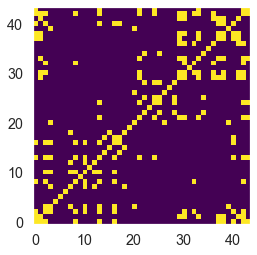

In [29]:
X_rp = RecurrencePlot().set_params(**PARAMETROS_RP).fit_transform(X)
plt.imshow(X_rp[0,:], cmap='viridis', origin='lower')
plt.grid(False)

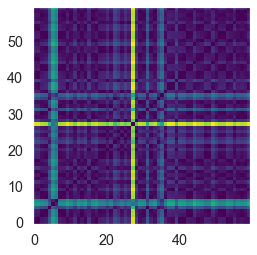

In [31]:
PARAMETROS_RP2 = {
    "dimension": 1,
    "time_delay": 1,
    "threshold": None,
    "percentage": 10
}
X_rp = RecurrencePlot().set_params(**PARAMETROS_RP2).fit_transform(X)
plt.imshow(X_rp[0,:], cmap='viridis', origin='lower')
plt.grid(False)

In [32]:
X_rp

array([[[0.        , 0.00582504, 0.05967903, ..., 0.0553112 ,
         0.03347778, 0.0363903 ],
        [0.00582504, 0.        , 0.06550407, ..., 0.06113625,
         0.03930283, 0.03056526],
        [0.05967903, 0.06550407, 0.        , ..., 0.00436783,
         0.02620125, 0.09606934],
        ...,
        [0.0553112 , 0.06113625, 0.00436783, ..., 0.        ,
         0.02183342, 0.09170151],
        [0.03347778, 0.03930283, 0.02620125, ..., 0.02183342,
         0.        , 0.06986809],
        [0.0363903 , 0.03056526, 0.09606934, ..., 0.09170151,
         0.06986809, 0.        ]],

       [[0.        , 0.05205345, 0.01862383, ..., 0.4054451 ,
         0.41977167, 0.39064074],
        [0.05205345, 0.        , 0.03342962, ..., 0.45749855,
         0.47182512, 0.44269419],
        [0.01862383, 0.03342962, 0.        , ..., 0.42406893,
         0.4383955 , 0.40926456],
        ...,
        [0.4054451 , 0.45749855, 0.42406893, ..., 0.        ,
         0.01432657, 0.01480436],
        [0.4

In [39]:
X_rp[0,:].min()

0.0